## Preamble 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 
import scipy.optimize as opt
import pickle 

In [3]:
#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/',
SMFF = '/Users/Ismael/code/lensing/SMFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

In [4]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

In [5]:
def plot_matrix(matrix, param_names): 

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    n,_ = matrix.shape #assume square matrix
    plt.xticks(list(plt.xticks()[0]), [None] + param_names)
    plt.yticks(list(plt.yticks()[0]), [None] + param_names)
    
    plt.tick_params(labelsize=20)


    ax.matshow(matrix, cmap=plt.cm.Blues)


    for i in xrange(n):
        for j in xrange(n):
            c = matrix[j,i]
            ax.text(i, j, '{:.2g}'.format(c), va='center', ha='center',size=20)

## Simulate a single chip 

In [6]:
#to simulate the following files need whole weaklensing deblending package to run.
#need OneDegSq.fits, found in ftp://ftp.slac.stanford.edu/groups/desc/WL/

In [ ]:
os.chdir('/Users/Ismael/code/lensing/WeakLensingDeblending/')

In [ ]:
filename = ''
section_name = 'section-{}.fits'.format(filename)

noise_iamge = 'noise_image.fits'
table_file = 'table.fits'


In [ ]:
cosmic_shear_g1 = 0. 
cosmic_shear_g2 = 0. 
job_number = 1
i,j = 0,0
image_width = 4500
image_height = 4500

In [12]:
cmd = './simulate.py --catalog-name OneDegSq.fits --survey-name LSST --image-width {} --image-height {} --output-name section-{}{}{} --calculate-bias --cosmic-shear-g1 {} --cosmic-shear-g2 {} --verbose'.format(image_width,image_height,i,j,job_number,cosmic_shear_g1,cosmic_shear_g2)
os.system(cmd)

256

In [ ]:
noise_seed = 0
#get image
fits_section = fitsio.FITS(file_name)
stamp = fits_section[0].read()


reader = descwl.output.Reader(section_name)
results = reader.results
generator = galsim.random.BaseDeviate(seed = noise_seed)
noise = galsim.PoissonNoise(rng = generator, sky_level = results.survey.mean_sky_level)
full_stamp_galsim = galsim.Image(array=stamp,wcs=galsim.PixelScale(pixel_scale),bounds=galsim.BoundsI(xmin=0, xmax=total_width-1, ymin=0, ymax=total_height-1)
full_stamp_galsim.addNoise(noise)

                                 
f = fits.PrimaryHDU(full_stamp_galsim.array)
f.writeto(inputs_slac['noise_image'])

## Get output with the following command (takes a long time and better to run in SLAC). 

In [8]:
#this is for the 5 final fits files. 
#the file to use is all-process.py (found in the folder WeakLensingDeblending/jobs)
#under the assumption you are currently logged in SLAC. 
cmds= [
"python all-process.py --simulate --job-number 1 --cosmic-shear-g1 0. --cosmic-shear-g2 0. --noise-seed 0"
"python all-process.py --simulate --job-number 2 --cosmic-shear-g1 0.01 --cosmic-shear-g2 0.01 --noise-seed 0"
"python all-process.py --simulate --job-number 3 --cosmic-shear-g1 -0.01 --cosmic-shear-g2 -0.01 --noise-seed 0"
"python all-process.py --simulate --job-number 4 --cosmic-shear-g1 0.02 --cosmic-shear-g2 0.02 --noise-seed 0"
"python all-process.py --simulate --job-number 5 --cosmic-shear-g1 -0.02 --cosmic-shear-g2 -0.02 --noise-seed 0"

"python all-process.py --combine --job-number 1 --cosmic-shear-g1 0. --cosmic-shear-g2 0. --noise-seed 0"
"python all-process.py --combine --job-number 2 --cosmic-shear-g1 0.01 --cosmic-shear-g2 0.01 --noise-seed 0"
"python all-process.py --combine --job-number 3 --cosmic-shear-g1 -0.01 --cosmic-shear-g2 -0.01 --noise-seed 0"
"python all-process.py --combine --job-number 4 --cosmic-shear-g1 0.02 --cosmic-shear-g2 0.02 --noise-seed 0"
"python all-process.py --combine --job-number 5 --cosmic-shear-g1 -0.02 --cosmic-shear-g2 -0.02 --noise-seed 0"

"python all-process.py --extract --job-number 1 --cosmic-shear-g1 0. --cosmic-shear-g2 0. --noise-seed 0"
"python all-process.py --extract --job-number 2 --cosmic-shear-g1 0.01 --cosmic-shear-g2 0.01 --noise-seed 0"
"python all-process.py --extract --job-number 3 --cosmic-shear-g1 -0.01 --cosmic-shear-g2 -0.01 --noise-seed 0"
"python all-process.py --extract --job-number 4 --cosmic-shear-g1 0.02 --cosmic-shear-g2 0.02 --noise-seed 0"
"python all-process.py --extract --job-number 5 --cosmic-shear-g1 -0.02 --cosmic-shear-g2 -0.02 --noise-seed 0"


]

## Prepare input 

In [6]:
#files , the order is as follows 
#g1,g2=0,0
#g1,g2=.01,.01
#g1,g2=-.01,-.01
#g1,g2=.02,.02
#g1,g2=-.02,-.02
#respectively. 
files = dict(
final_fitsLSST1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-20/final_fits.fits', 
final_fitsLSST2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-15/final_fits.fits', 
final_fitsLSST3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-10/final_fits.fits', 
final_fitsLSST4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-5/final_fits.fits', 
final_fitsLSST5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_0/final_fits.fits', 
final_fitsLSST6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_5/final_fits.fits', 
final_fitsLSST7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_10/final_fits.fits', 
final_fitsLSST8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_15/final_fits.fits', 
final_fitsLSST9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_20/final_fits.fits', 
    
final_fitsDES1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-20/final_fits.fits', 
final_fitsDES2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-15/final_fits.fits', 
final_fitsDES3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-10/final_fits.fits', 
final_fitsDES4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-5/final_fits.fits', 
final_fitsDES5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_0/final_fits.fits', 
final_fitsDES6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_5/final_fits.fits', 
final_fitsDES7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_10/final_fits.fits', 
final_fitsDES8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_15/final_fits.fits', 
final_fitsDES9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_20/final_fits.fits', 
    
final_fitsHSC1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-20/final_fits.fits', 
final_fitsHSC2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-15/final_fits.fits', 
final_fitsHSC3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-10/final_fits.fits', 
final_fitsHSC4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-5/final_fits.fits', 
final_fitsHSC5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_0/final_fits.fits', 
final_fitsHSC6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_5/final_fits.fits', 
final_fitsHSC7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_10/final_fits.fits', 
final_fitsHSC8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_15/final_fits.fits', 
final_fitsHSC9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_20/final_fits.fits', 

)

files_temps = dict() 
for f in files: 
    l = files[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    files_temps[f] = temp_file

    
files_slac = dict()
for f in files: 
    l = files[f].split("/")
    index_data = l.index("aegis")
    str_slac = "/".join(l[index_data:])
    slac_file = '{0}{1}'.format('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/',str_slac)
    files_slac[f] = slac_file

In [7]:
files

{'final_fitsDES1': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-20/final_fits.fits',
 'final_fitsDES2': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-15/final_fits.fits',
 'final_fitsDES3': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-10/final_fits.fits',
 'final_fitsDES4': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-5/final_fits.fits',
 'final_fitsDES5': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_0/final_fits.fits',
 'final_fitsDES6': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_5/final_fits.fits',
 'final_fitsDES7': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_10/final_fits.fits',
 'final_fitsDES8': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_15/final_fits.fits',
 'final_fitsDES9': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_20/final_fits.fits',
 'final_fitsHSC1': '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-20/final_fits.fits',
 'final_fitsHSC2': '/Users/I

## Samples 

In [8]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 5) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1']) < bias_cut) & (np.absolute(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1_grp']) < bias_cut) & (np.absolute(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut,point=0: cat[np.absolute(cat[param] - point) < cut]
unphysical_iso = lambda cat: cat[(np.absolute(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(np.absolute(cat['bias_g1_grp']) > 1.) | (np.absolute(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

#filter rare (bad) objs. Which will not be good for our purposes. 
not_bad = lambda cat: cat[(cat['snr_grp'] != 0) & (cat['ds_grp']!= inf) ]

In [9]:
def get_non_duplicated_cat(cat):
    #get non-duplicated and duplicated objects
    seen = set()
    duplic = set()
    a = list(cat['db_id'])

    for x in a:
        if x in seen: 
            duplic.add(x)
        if x not in seen:
            seen.add(x)

    #get duplicated objects
    duplic_cat, non_duplic_cat = get_slice(cat, 'db_id', duplic,non_selection='True')    
    return non_duplic_cat

In [10]:
#smaller random samples 
def leaveRandom(sz,cat):
    new_cat = deepcopy(cat)
    rm_rows = random.sample(xrange(0,len(cat)-1), len(cat) - sz)
    new_cat.remove_rows(rm_rows)
    return new_cat 

#get a smaller sample of each of the catalogs for illustrative purposes 
small = lambda cat,N: leaveRandom(N, cat)

In [11]:
def get_filter_cats(cats,filters): 
    filter_cats = []
    for c in cats: 
        cat = deepcopy(c)
        for fil in filters:
            cat = fil(cat) 
        filter_cats.append(cat)
    return filter_cats

def selection_filter(cats,filters): 
    #use shear = 0 as the galaxies to be selected across samples to avoid selection bias 
    filter_cats = []
    shear_zero_cat = deepcopy(cats[4]) #assume the middle one is the one with 0 shear. 
    for fil in filters: 
        shear_zero_cat = fil(shear_zero_cat)
        
    shear_zero_ids = set(shear_zero_cat['db_id'])
    
    for cat in cats: 
        filter_cats.append(get_slice(cat, 'db_id', shear_zero_ids))
        
    return get_intersection_cats(filter_cats) #double make sure all ids are the same. 

In [12]:
#this function returns the rows of cat that are in selection. 
def get_slice(cat, field, selection,non_selection=False): 
    bool_slice = []
    for data in cat[field]: 
        bool_slice.append(data in selection)
        
    if not non_selection: 
        return cat[bool_slice]
    else: 
        return cat[bool_slice], cat[np.invert(bool_slice)]

In [13]:
#gets the ids of the galaxies that is contained in each cat in cats and returns a new list new_cats 
#that contains only this galaxies
def get_intersection_cats(cats,other_cats=False): 
    intersection = set() 
    for i,cat in enumerate(cats): 
        if i==0: 
            intersection = set(cat['db_id']) 
        intersection = intersection.intersection(cat['db_id'])
            
    #convert intersection ids to indices , then remove indices that are not those ones:
    new_cats = []
    new_non_cats = [] 
    for cat in cats: 
        new_cat, new_non_cat = get_slice(cat, 'db_id', intersection, non_selection=True)
        new_cats.append(new_cat)
        new_non_cats.append(new_non_cat)
        
    if other_cats: 
        return new_cats,new_non_cats
    else: 
        return new_cats

In [14]:
#create hash map of db_id of galaxies to some parameter. 
def hash_param(cat, param): 
    hash_map = {} 
    for i in range(len(cat)): 
        hash_map[cat['db_id'][i]] = cat[param][i]
    return hash_map

In [15]:
def bootstrap_param_cat(cat, param, N, func): 
    #return a bootstrapped list of some function of parameters(median, mean, etc.) from some catalogue
    bootstrapped_list = []
    n = len(cat)
    for i in range(N):
        sample = np.random.choice(cat[param],size=n)
        bootstrapped_list.append(func(sample))
    return bootstrapped_list

def bootstrap_param_zero_cats(cats, param, N, func, zero_shear_cat): 
    """
    - Return a bootstrapped list of some function of parameters(median, mean, etc.) from some catalogue
    this function is designed to work when cats is the output of the selection filter (so that all the cats have the 
    same galaxies per their galaxy id, this is not technically necessary but makes things easier overall). You bootstrap the galaxy 
    ids and then use that to obtain sample of func. 
    - You should pass in as one argument the 0 shear cat just for clarity. 
    - Recall the main reason for doing this is so each id_sample is repeated across 9 galaxies. 
    """
    
    ids = zero_shear_cat['db_id']
    bootstrapped_params = [[] for i in range(len(cats))]
    n = len(ids)
    hash_maps = [hash_param(cat, param) for cat in cats] #get a hash map of param for cats for quick look up 

    # for each cat produce a bootstrapped sample of N funcs 
    for i in range(N):
        id_sample = np.random.choice(ids,size=n)
        for j, cat in enumerate(cats): 
            bootstrapped_params[j].append(func([hash_maps[j][gal_id] for gal_id in id_sample]))
    return bootstrapped_params

In [16]:
def get_bias_covariance_matrices(main_cats,gi): 
    #notice that this function limits the ellipticity bias grp to be between +1.5,-1.5 since mean function 
    # would be heavily biased otherwise. 
    num_cats = len(main_cats)
    covariance_matrix = np.zeros((num_cats, num_cats))
    covariance_matrix_grp = np.zeros((num_cats, num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            cat_i = main_cats[i]
            cat_j = main_cats[j]
            cut_cat1 = abs_cut(cat_i,'bias_{}_grp'.format(gi),1.5)
            cut_cat2 = abs_cut(cat_j,'bias_{}_grp'.format(gi),1.5)
            cut_intersection_cats = get_intersection_cats([cut_cat1,cut_cat2])
            cut_intersect_cat1 = cut_intersection_cats[0]
            cut_intersect_cat2 = cut_intersection_cats[1]
            cut_length_intersection = float(len(cut_intersect_cat1))
            b1_mean_grp,b2_mean_grp = np.mean(cut_intersect_cat1['bias_{}_grp'.format(gi)]),np.mean(cut_intersect_cat2['bias_{}_grp'.format(gi)])
            b1_mean,b2_mean = np.mean(cut_intersect_cat1['bias_{}'.format(gi)]),np.mean(cut_intersect_cat2['bias_{}'.format(gi)])
            covariance_matrix_grp[i,j] = np.sum((cut_intersect_cat1['bias_{}_grp'.format(gi)] - b1_mean_grp)*(cut_intersect_cat2['bias_{}_grp'.format(gi)] - b2_mean_grp))/(cut_length_intersection-1)
            covariance_matrix[i,j] = np.sum((cut_intersect_cat1['bias_{}'.format(gi)] - b1_mean)*(cut_intersect_cat2['bias_{}'.format(gi)] - b2_mean))/(cut_length_intersection-1)
            
            #make symmetric by copying elements 
            covariance_matrix[j,i] = covariance_matrix[i,j]
            covariance_matrix_grp[j,i] = covariance_matrix_grp[i,j]
            
    #also calculate correlation matrices just for fun. 
    correlation_matrix = np.zeros((num_cats, num_cats))
    correlation_matrix_grp = np.zeros((num_cats,num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            correlation_matrix[i,j] = covariance_matrix[i,j]/ np.sqrt(covariance_matrix[i,i]*covariance_matrix[j,j])
            correlation_matrix_grp[i,j] = covariance_matrix_grp[i,j]/ np.sqrt(covariance_matrix_grp[i,i]*covariance_matrix_grp[j,j])
            
            #make symmetric by copying elements 
            correlation_matrix[j,i] = correlation_matrix[i,j]
            correlation_matrix_grp[j,i] = correlation_matrix_grp[i,j]
            

    return covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp

In [22]:
def get_boostrap_covariance_matrix(main_cats,gi): 
    #notice that this function limits the ellipticity bias grp to be between +1.5,-1.5 since mean function 
    # would be heavily biased otherwise. 
    num_cats = len(main_cats)
    covariance_matrix = np.zeros((num_cats, num_cats))
    covariance_matrix_grp = np.zeros((num_cats, num_cats))
    
    
    # default size of sample. 
    N=10000
    
    #from each cat we get a boostrap cat of medians iso, grp    
    true_medians_iso = [np.median(cat['bias_{}'.format(gi)]) for cat in main_cats]
    true_medians_grp =[np.median(cat['bias_{}_grp'.format(gi)]) for cat in main_cats]
    medians_cat_iso = bootstrap_param_zero_cats(main_cats, 'bias_{}'.format(gi), N, np.median, main_cats[4])
    medians_cat_grp = bootstrap_param_zero_cats(main_cats, 'bias_{}_grp'.format(gi), N, np.median, main_cats[4])
    
    #now calculate covariance for each case. 
    
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            medians_iso_cat_i = np.array(medians_cat_iso[i]) 
            medians_iso_cat_j = np.array(medians_cat_iso[j]) 
            medians_grp_cat_i = np.array(medians_cat_grp[i])
            medians_grp_cat_j = np.array(medians_cat_grp[j])
            
            true_median_iso_i = true_medians_iso[i]
            true_median_iso_j = true_medians_iso[j]
            true_median_grp_i = true_medians_grp[i]
            true_median_grp_j = true_medians_grp[j]

            covariance_matrix_grp[i,j] = np.sum(( medians_grp_cat_i - true_median_grp_i)*(medians_grp_cat_j - true_median_grp_j))/(N-1)
            covariance_matrix[i,j] = np.sum(( medians_iso_cat_i - true_median_iso_i)*(medians_iso_cat_j - true_median_iso_j))/(N-1)
            
            #make symmetric by copying elements 
            covariance_matrix[j,i] = covariance_matrix[i,j]
            covariance_matrix_grp[j,i] = covariance_matrix_grp[i,j]
            
    #also calculate correlation matrices just for fun. 
    correlation_matrix = np.zeros((num_cats, num_cats))
    correlation_matrix_grp = np.zeros((num_cats,num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            correlation_matrix[i,j] = covariance_matrix[i,j]/ np.sqrt(covariance_matrix[i,i]*covariance_matrix[j,j])
            correlation_matrix_grp[i,j] = covariance_matrix_grp[i,j]/ np.sqrt(covariance_matrix_grp[i,i]*covariance_matrix_grp[j,j])
            
            #make symmetric by copying elements 
            correlation_matrix[j,i] = correlation_matrix[i,j]
            correlation_matrix_grp[j,i] = correlation_matrix_grp[i,j]
            

    return covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp

In [23]:
selection_sample = selection_filter(main_catsLSST,[best,good])

In [24]:
%%time 
covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_boostrap_covariance_matrix(selection_sample,'g1')

CPU times: user 2h 59min 27s, sys: 4min 54s, total: 3h 4min 22s
Wall time: 3h 16min 15s


In [28]:
boot_covariance_matrix, boot_covariance_matrix_grp, boot_correlation_matrix, boot_correlation_matrix_grp = covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp

In [27]:
pickle.dump((covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp),open("bootstrap_matrices.p","wb"))

In [25]:
correlation_matrix

array([[ 1.        ,  0.97797313,  0.95635686,  0.92480101,  0.79969562,
         0.84740521,  0.82717808,  0.80360748,  0.78797672],
       [ 0.97797313,  1.        ,  0.97652309,  0.9430429 ,  0.81046521,
         0.86414776,  0.84627848,  0.82144512,  0.80654225],
       [ 0.95635686,  0.97652309,  1.        ,  0.96719919,  0.84141255,
         0.88715651,  0.86492587,  0.84278135,  0.82794758],
       [ 0.92480101,  0.9430429 ,  0.96719919,  1.        ,  0.89354465,
         0.919076  ,  0.88497226,  0.87291338,  0.85433417],
       [ 0.79969562,  0.81046521,  0.84141255,  0.89354465,  1.        ,
         0.91465789,  0.85665203,  0.85140032,  0.83248946],
       [ 0.84740521,  0.86414776,  0.88715651,  0.919076  ,  0.91465789,
         1.        ,  0.96217625,  0.94699069,  0.92800505],
       [ 0.82717808,  0.84627848,  0.86492587,  0.88497226,  0.85665203,
         0.96217625,  1.        ,  0.96643509,  0.95229808],
       [ 0.80360748,  0.82144512,  0.84278135,  0.87291338,  0

In [23]:
print correlation_matrix
print correlation_matrix_grp

[[  1.00000000e+00   4.71713673e-01   1.86655084e-01   6.87705514e-01
    3.13981324e+00   1.27140591e+00  -4.86875490e-01   1.44825787e+00
    1.17058567e+00]
 [  4.71713673e-01   1.00000000e+00   4.70471002e-01   6.37748254e-01
    2.37947515e+00   1.17798061e+00  -2.58495960e-01   1.54848160e+00
    1.34394441e+00]
 [  1.86655084e-01   4.70471002e-01   1.00000000e+00   7.45067924e-01
    1.97382476e+00   1.37459561e+00  -9.69027135e-03   2.12017114e+00
    1.96142571e+00]
 [  6.87705514e-01   6.37748254e-01   7.45067924e-01   1.00000000e+00
    1.42595216e+00   1.84247653e+00   4.30578116e-01   3.31773304e+00
    3.22639536e+00]
 [  3.13981324e+00   2.37947515e+00   1.97382476e+00   1.42595216e+00
    1.00000000e+00   5.51606224e+00   2.47791488e+00   1.12082345e+01
    1.12602683e+01]
 [  1.27140591e+00   1.17798061e+00   1.37459561e+00   1.84247653e+00
    5.51606224e+00   1.00000000e+00   8.61240853e-01   2.47398740e+00
    2.59622477e+00]
 [ -4.86875490e-01  -2.58495960e-01  -9.

## Read and filter out duplicated and bad objects.

In [73]:
#in the order that corresponds to the catalogues. 
g1s = [-.02,-.015,-.01,-.005,0.,.005,.01,.015,.02]

In [21]:
main_catsLSST = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsLSST1','final_fitsLSST2','final_fitsLSST3','final_fitsLSST4','final_fitsLSST5','final_fitsLSST6','final_fitsLSST7','final_fitsLSST8','final_fitsLSST9']:
    results = fits.open(files[key])
    main_catsLSST.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [ ]:
main_catsDES = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsDES1','final_fitsDES2','final_fitsDES3','final_fitsDES4','final_fitsDES5','final_fitsDES6','final_fitsDES7','final_fitsDES8','final_fitsDES9']:
    results = fits.open(files[key])
    main_catsDES.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [18]:
main_catsHSC = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsHSC1','final_fitsHSC2','final_fitsHSC3','final_fitsHSC4','final_fitsHSC5','final_fitsHSC6','final_fitsHSC7','final_fitsHSC8','final_fitsHSC9']:
    results = fits.open(files[key])
    main_catsHSC.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [19]:
#write down explicity the names for each input. 
names = ['One square degree galaxies with g1 = 0','One square degree galaxies with g1 = 0.1','One square degree galaxies with g1 = -0.1','One square degree galaxies with g1 = 0.2','One square degree galaxies with g1 = -0.2']

In [32]:
cat = main_catsLSST[4]
cat[cat['db_id']== 402715332898]['bias_g1_grp'][0]

95.31739

## Scatter plot showing the different detected/undetected and ambiguously blended pairs. 

In [15]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


def purity_snr_scatter_final(fraction,analyze_cat,colors,power,full_cat,ax,name,save=None):
    #divide into 4 groups 

    high_pur_high_snr = up_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    high_pur_low_snr = down_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    low_pur_high_snr = up_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    low_pur_low_snr = down_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(analyze_cat)
    p2 = float(len(high_pur_low_snr))/len(analyze_cat)
    p3 = float(len(low_pur_high_snr))/len(analyze_cat)
    p4 = float(len(low_pur_low_snr))/len(analyze_cat)
    
    #create smaller catalogues to plot them and reduce the density of points in each region. 
    small_hphs = small(high_pur_high_snr,int(len(high_pur_high_snr)* fraction))
    small_hpls = small(high_pur_low_snr,int(len(high_pur_low_snr)* fraction))
    small_lphs = small(low_pur_high_snr,int(len(low_pur_high_snr) * fraction))
    small_lpls = small(low_pur_low_snr,int(len(low_pur_low_snr)* fraction))

    orig_ticks = np.array([0.,0.142,0.5402,.785,1])
    new_ticks = []
    for label in orig_ticks: 
        new_ticks.append('{:.2g}'.format(label**(1./12)))
    
    #plot each group separately with different colors 
    plt.scatter(small_hphs['snr_grpf'],small_hphs['purity']**(power),alpha=.2,color=colors[0])
    
    #replace original ticks with of new ones. Do that for all. 
    plt.yticks(orig_ticks, new_ticks)
    
    plt.scatter(small_hpls['snr_grpf'],small_hpls['purity']**(power),alpha=.2,color=colors[1])
    plt.yticks(orig_ticks, new_ticks)

    plt.scatter(small_lphs['snr_grpf'],small_lphs['purity']**(power),alpha=.2,color=colors[2])
    plt.yticks(orig_ticks, new_ticks)
    
    plt.scatter(small_lpls['snr_grpf'],small_lpls['purity']**(power),alpha=.2,color=colors[3])
    plt.yticks(orig_ticks, new_ticks)


    #annotate with colors the percentages
    plt.annotate("{0:.1f}\%".format(p1*100), xy=(0.525, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p2*100), xy=(0.015, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p3*100), xy=(0.525, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p4*100), xy=(0.015, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.text(.380,.01,'Fraction of full catalogue:{0:.1f}\%'.format(float(len((analyze_cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=25)
    
    

    plt.xlabel(r'$\nu_{\rm grpf}$',fontsize=40)
    plt.ylabel(r'$\rho$',fontsize=40)
    plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
    plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)
    plt.xlim(0,30)
    plt.ylim(0.,1.)
    plt.title(name)



 

In [16]:
scatter_cat = deepcopy(main_catsLSST[4])

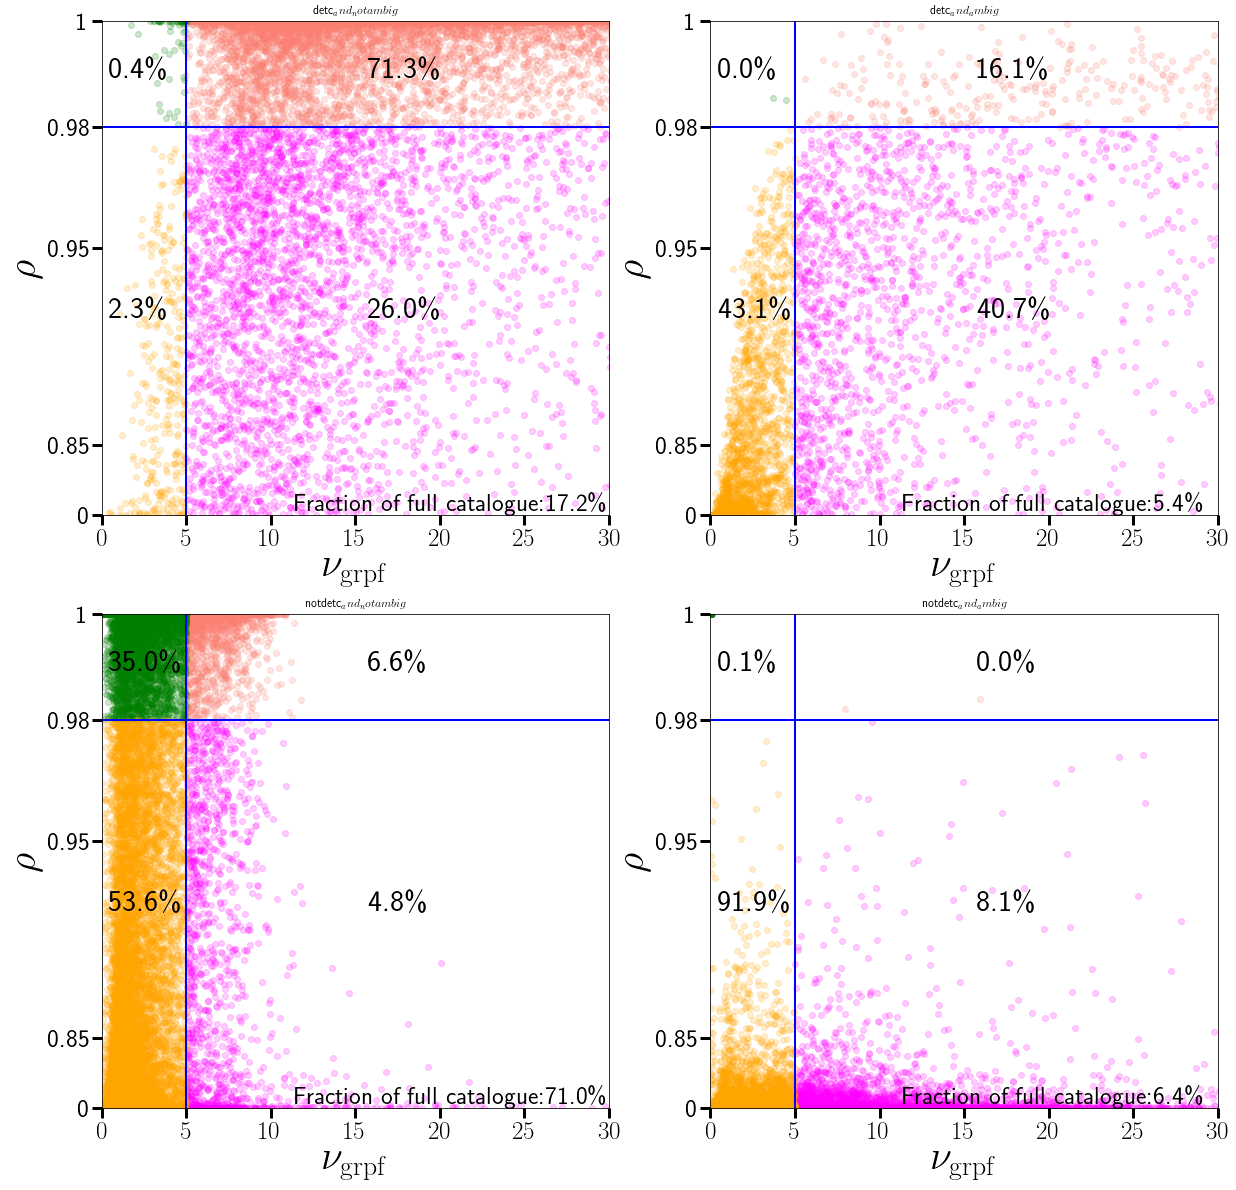

In [17]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 2,2
power = 12. 

cats =[detc_and_notambig(scatter_cat),detc_and_ambig(scatter_cat),notdetc_and_notambig(scatter_cat),notdetc_and_ambig(scatter_cat)]
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
colors= ['salmon', 'green', 'magenta', 'orange','black']
fractions = [1./10,1./10, 1./20, 1.]

for i,(name,temp_cat,fraction) in enumerate(zip(names,cats,fractions)):
    ax = plt.subplot(nrow, ncol, i+1)
    plt.axhline(.98**power,color='blue',linewidth=2)
    plt.axvline(5,color='blue',linewidth=2)
    purity_snr_scatter_final(fraction, temp_cat,colors,power,scatter_cat,ax,name)
    #as reference for debugging, 

plt.xlim(0,30)
fig.savefig('/Users/Ismael/Desktop/scatter_1.jpg')

In [101]:
temp = detc_and_notambig(scatter_cat)
temp2 = up_cut(up_cut(temp,'purity',.98),'snr_grpf',6)

print 'percentage in plot should be:{}'.format(float(len(temp2))/ len(temp )) 

print 'this catalogue includes objects above snr_grpf of 30: {}'.format(len(temp2[temp2['snr_grpf']>30])) 

percentage in plot should be:0.706653782441
this catalogue includes objects above snr_grpf of 30: 34549


## Money plot using bootstrap variance. 

In [77]:
intersection = set() 
for i,cat in enumerate(main_catsLSST): 
    if i==0: 
        intersection = set(cat['db_id']) 
    print 'intersection {}'.format(len(intersection))
    print 'curr catalogue {}'.format(len(cat))
    intersection = intersection.intersection(cat['db_id'])
#does not change that much. 

intersection 844272
curr catalogue 844272
intersection 844272
curr catalogue 844660
intersection 843818
curr catalogue 844465
intersection 843498
curr catalogue 844290
intersection 843355
curr catalogue 844643
intersection 843192
curr catalogue 844705
intersection 843150
curr catalogue 844212
intersection 843071
curr catalogue 844384
intersection 843040
curr catalogue 844742


In [79]:
intersection = set() 
for i,cat in enumerate(get_filter_cats(main_catsDES,[good,best])): 
    if i==0: 
        intersection = set(cat['db_id']) 
    print 'intersection {}'.format(len(intersection))
    print 'curr catalogue {}'.format(len(cat))
    intersection = intersection.intersection(cat['db_id'])
#does not change that much. 

intersection 15671
curr catalogue 15671
intersection 15671
curr catalogue 15801
intersection 13461
curr catalogue 15866
intersection 12517
curr catalogue 15839
intersection 12006
curr catalogue 15714
intersection 11630
curr catalogue 15768
intersection 11309
curr catalogue 15842
intersection 11099
curr catalogue 15826
intersection 10907
curr catalogue 15735


In [64]:
for gal_id in 
intersection

{402700320819,
 402716098565,
 2212495366,
 2208301068,
 402716098579,
 402703515668,
 402701418518,
 402707709976,
 402714001435,
 2206553434,
 402716098591,
 2216689696,
 402701418531,
 402715788272,
 402714001451,
 402705612844,
 402714001453,
 2216689712,
 402714001458,
 2212495413,
 2209349641,
 2217388724,
 402711904314,
 402709807164,
 402711904318,
 2214592578,
 402716098627,
 2211100898,
 2200597769,
 2202009682,
 402703515733,
 2210398294,
 402709457594,
 402716098654,
 2202009699,
 2204106853,
 402716098662,
 2211097276,
 2214592619,
 2214592623,
 402710156648,
 2214592629,
 2216340159,
 2202009726,
 402716961448,
 2208650603,
 2204106884,
 2208301078,
 2209000129,
 2216689806,
 402711904404,
 402703515802,
 402707710110,
 2210398367,
 402701418659,
 2202009765,
 2216689830,
 402705612967,
 402703515816,
 2209441187,
 402711904427,
 402701418669,
 402711904430,
 402707710134,
 2210398391,
 402711904444,
 402709807294,
 402705612993,
 2206204098,
 2208301251,
 2204106950,
 22

In [29]:
intersection_matrix = np.zeros((len(main_catsLSST), len(main_catsLSST)))
for i in range(len(main_catsLSST)): 
    for j in range(len(main_catsLSST)): 
        cat_i = main_catsLSST[i]
        cat_j = main_catsLSST[j]
        filter_cats = get_filter_cats([cat_i, cat_j],[gold,best])
        intersection_cats = get_intersection_cats(filter_cats)
        length_intersection = float(len(intersection_cats[0]))
        intersection_matrix[i,j] = length_intersection/ max([len(cat) for cat in filter_cats])
        
        

In [33]:
filter_cats = get_filter_cats([main_catsLSST[0], main_catsLSST[-1]],[gold,best])
intersection_cats = get_intersection_cats(filter_cats)
print len(intersection_cats[0]), len(intersection_cats[1]), len(filter_cats[0]), len(filter_cats[1])
print float(len(intersection_cats[0]))/ max([len(cat) for cat in filter_cats])

117523 117523 123195 123047
0.953959170421


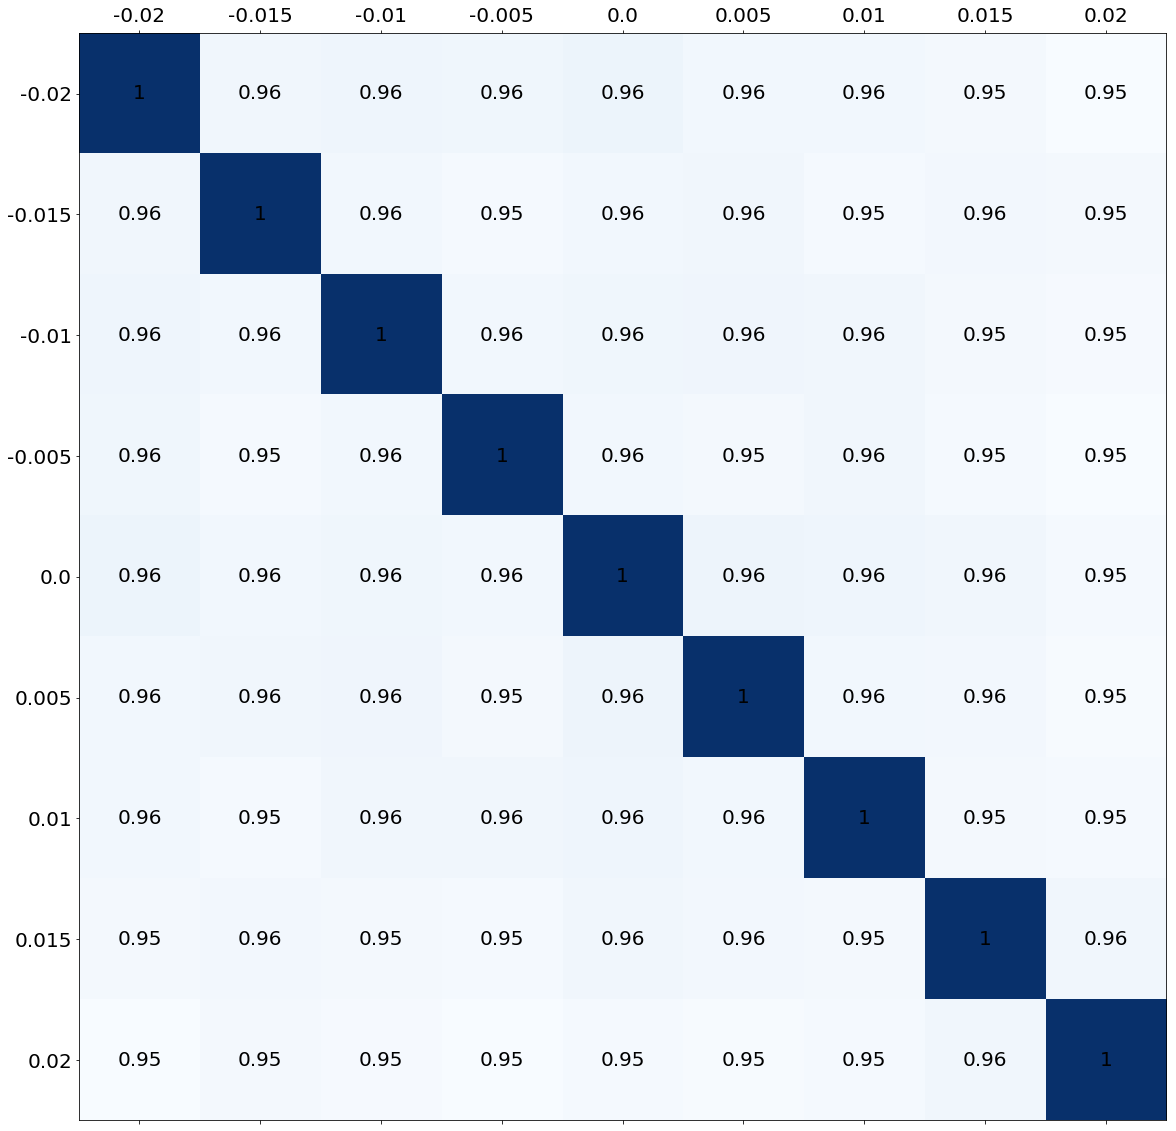

In [31]:
plot_matrix(intersection_matrix,g1s)

## what do the objects that do not intersect look like? 

In [16]:
filtered_cats = get_filter_cats(main_catsLSST,[good,best])
intersect_cats,non_intersect_cats = get_intersection_cats(filtered_cats,other_cats=True)

In [17]:
print [len(cat) for cat in intersect_cats]
print [len(cat) for cat in filtered_cats]
print [len(cat) for cat in non_intersect_cats]

[85638, 85638, 85638, 85638, 85638, 85638, 85638, 85638, 85638]
[105161, 105017, 105182, 105091, 105015, 105009, 105169, 104932, 104948]
[19523, 19379, 19544, 19453, 19377, 19371, 19531, 19294, 19310]


In [38]:
def plot_histogram(cat,title=None): 
    g_min,g_max = -2,2
    plt.hist(cat['bias_g1_grp'],histtype='step',bins=100,range=[g_min,g_max],color='red',label='blending on')
    plt.hist(cat['bias_g1'],histtype='step',bins=100,range=[g_min,g_max],color='green',label='blending off')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlim(g_min,g_max)
    plt.yscale('log')
    plt.legend(prop={'size':15})
    if title!= None: 
        plt.title(title,size=20)

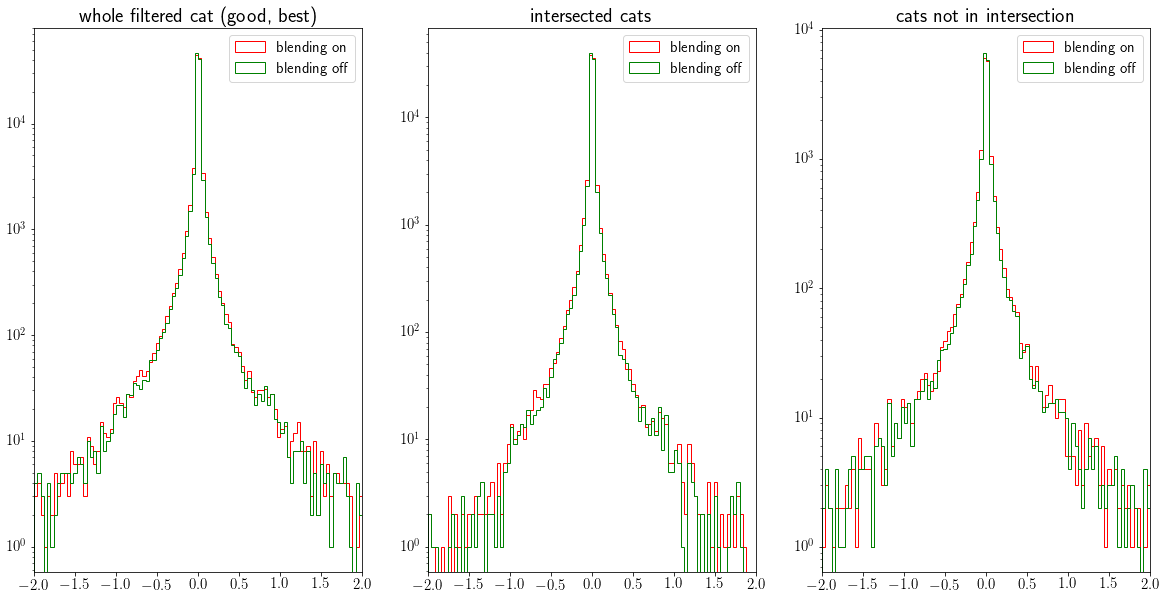

In [105]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(131) 
plot_histogram(filtered_cats[4],title='whole filtered cat (good, best)')
fig.add_subplot(132) 
plot_histogram(intersect_cats[4],title='intersected cats')
fig.add_subplot(133) 
plot_histogram(non_intersect_cats[4],title='cats not in intersection')

In [33]:
# lets also calculate their mean for g1= 0 
err_mean_iso_fil = errs_mean_boot([filtered_cats[4]],'bias_g1',[])[0]
err_median_iso_fil = errs_med_boot([filtered_cats[4]],'bias_g1',[])[0]
err_mean_grp_fil = errs_mean_boot([filtered_cats[4]],'bias_g1_grp',[])[0]
err_median_grp_fil = errs_med_boot([filtered_cats[4]],'bias_g1_grp',[])[0]


cut_cat = abs_cut(intersect_cats[4], 'bias_g1_grp', 1.5) 
err_mean_iso_int = errs_mean_boot([cut_cat],'bias_g1',[])[0]
err_median_iso_int = errs_med_boot([intersect_cats[4]],'bias_g1',[])[0]
err_mean_grp_int = errs_mean_boot([cut_cat],'bias_g1_grp',[])[0]
err_median_grp_int = errs_med_boot([intersect_cats[4]],'bias_g1_grp',[])[0]

cut_cat = abs_cut(non_intersect_cats[4], 'bias_g1_grp', 1.5) 
err_mean_iso_nint = errs_mean_boot([cut_cat],'bias_g1',[])[0]
err_median_iso_nint = errs_med_boot([non_intersect_cats[4]],'bias_g1',[])[0]
err_mean_grp_nint = errs_mean_boot([cut_cat],'bias_g1_grp',[])[0]
err_median_grp_nint = errs_med_boot([non_intersect_cats[4]],'bias_g1_grp',[])[0]




just to check that symmetry is respected print both percentiles: [ 0.00061657  0.00062139]
just to check that symmetry is respected print both percentiles: [  7.81939988e-08   2.18029111e-07]
just to check that symmetry is respected print both percentiles: [ 0.01804685  0.01770155]
just to check that symmetry is respected print both percentiles: [  3.05515349e-06   2.70950920e-06]
just to check that symmetry is respected print both percentiles: [ 0.00026366  0.00026588]
just to check that symmetry is respected print both percentiles: [  1.37357144e-07   1.17082319e-07]
just to check that symmetry is respected print both percentiles: [ 0.00029024  0.00029812]
just to check that symmetry is respected print both percentiles: [  2.65441690e-06   2.78775381e-06]
just to check that symmetry is respected print both percentiles: [ 0.00129316  0.00125753]
just to check that symmetry is respected print both percentiles: [  7.00633591e-06   1.65774545e-05]
just to check that symmetry is respected

filtered: 
Mean bias_iso for cat: -0.000166170793818
Error on mean bias_iso for all cat: 0.000621386872372
median bias_iso for cat: 2.03614014538e-08
error on median bias_iso for cat: 2.1802911121e-07
Mean bias_grp for cat: -0.000171507839696
Error on mean bias_grp for all cat: 0.0177015521098
median bias_grp for cat: -1.19844196433e-06
error on median bias_grp for cat: 2.70950920367e-06

 intersected: 
Mean bias_iso for cat: -0.000282631051959
Error on mean bias_iso for all cat: 0.000265880633451
median bias_iso for cat: -1.83991166747e-09
error on median bias_iso for cat: 1.17082319284e-07
Mean bias_grp for cat: -0.000295991339954
Error on mean bias_grp for all cat: 0.000298123902467
median bias_grp for cat: -2.85155033453e-06
error on median bias_grp for cat: 2.78775381446e-06

 not in intersected: 
Mean bias_iso for cat: 0.000353573210305
Error on mean bias_iso for all cat: 0.00125752738793
median bias_iso for cat: 7.06284663465e-06
error on median bias_iso for cat: 1.65774545167e-

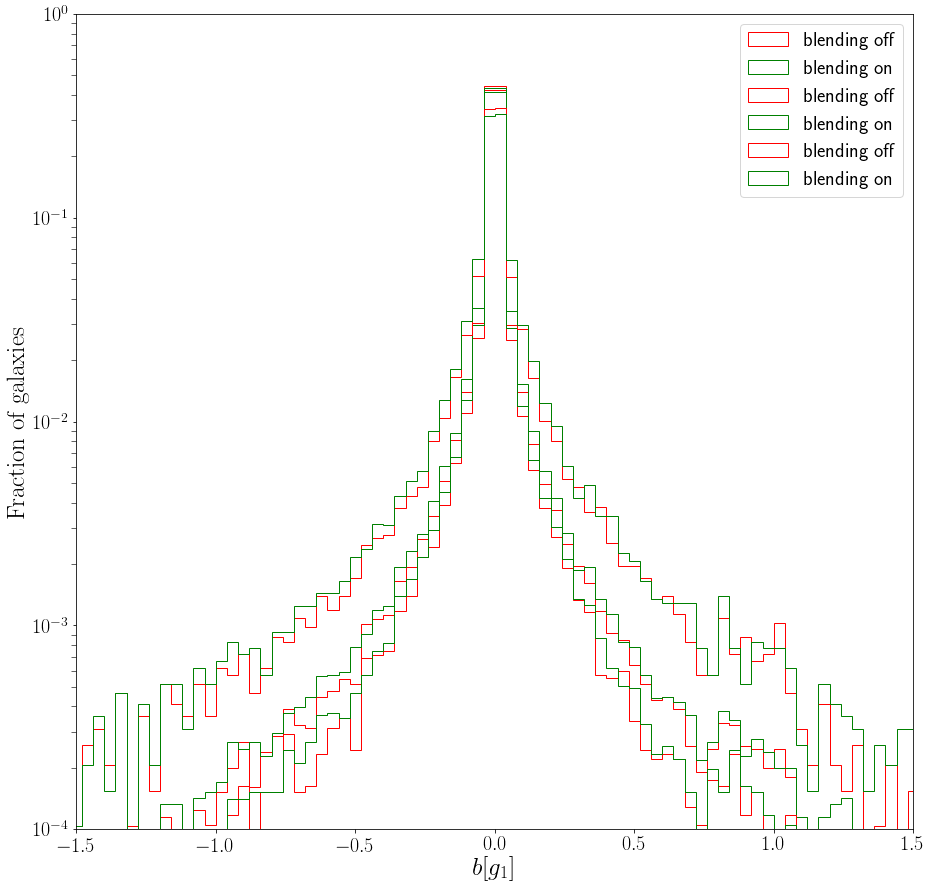

In [34]:
#all filtered cats 
fig = plt.figure(figsize=(15,15))
g_min = -2
g_max = 2
colors = ('red','green')


print 'filtered: '
shear_biases_hists(filtered_cats[4],colors,g_min,g_max,err_mean_iso_fil,err_median_iso_fil,err_mean_grp_fil,err_median_grp_fil)
plt.legend(prop={'size':20})

print '\n intersected: '

shear_biases_hists(intersect_cats[4],colors,g_min,g_max,err_mean_iso_int,err_median_iso_int,err_mean_grp_int,err_median_grp_int)
plt.legend(prop={'size':20})

print '\n not in intersected: '


shear_biases_hists(non_intersect_cats[4],colors,g_min,g_max,err_mean_iso_nint,err_median_iso_nint,err_mean_grp_nint,err_median_grp_nint)
plt.legend(prop={'size':20})



In [21]:
# lets also calculate their mean for g1= 0.2 
err_mean_iso_fil = errs_mean_boot([filtered_cats[8]],'bias_g1',[])[0]
err_median_iso_fil = errs_med_boot([filtered_cats[8]],'bias_g1',[])[0]
err_mean_grp_fil = errs_mean_boot([filtered_cats[8]],'bias_g1_grp',[])[0]
err_median_grp_fil = errs_med_boot([filtered_cats[8]],'bias_g1_grp',[])[0]


cut_cat = abs_cut(intersect_cats[8], 'bias_g1_grp', 1.5) 
err_mean_iso_int = errs_mean_boot([cut_cat],'bias_g1',[])[0]
err_median_iso_int = errs_med_boot([intersect_cats[8]],'bias_g1',[])[0]
err_mean_grp_int = errs_mean_boot([cut_cat],'bias_g1_grp',[])[0]
err_median_grp_int = errs_med_boot([intersect_cats[8]],'bias_g1_grp',[])[0]

cut_cat = abs_cut(non_intersect_cats[8], 'bias_g1_grp', 1.5) 
err_mean_iso_nint = errs_mean_boot([cut_cat],'bias_g1',[])[0]
err_median_iso_nint = errs_med_boot([non_intersect_cats[8]],'bias_g1',[])[0]
err_mean_grp_nint = errs_mean_boot([cut_cat],'bias_g1_grp',[])[0]
err_median_grp_nint = errs_med_boot([non_intersect_cats[8]],'bias_g1_grp',[])[0]





just to check that symmetry is respected print both percentiles: [ 0.00069276  0.00068867]
just to check that symmetry is respected print both percentiles: [  1.95439912e-06   2.14913052e-06]
just to check that symmetry is respected print both percentiles: [ 0.00801329  0.0080771 ]
just to check that symmetry is respected print both percentiles: [  5.75631595e-06   4.75358553e-06]
just to check that symmetry is respected print both percentiles: [ 0.00026766  0.00026558]
just to check that symmetry is respected print both percentiles: [  1.52192886e-06   1.81866380e-06]
just to check that symmetry is respected print both percentiles: [ 0.00029144  0.00028951]
just to check that symmetry is respected print both percentiles: [  4.44132093e-06   4.05896571e-06]
just to check that symmetry is respected print both percentiles: [ 0.00124295  0.00128261]
just to check that symmetry is respected print both percentiles: [  4.13880916e-05   3.67255416e-05]
just to check that symmetry is respected

filtered: 
Mean bias_iso for cat: 0.00156144739594
Error on mean bias_iso for all cat: 0.0006886687316
median bias_iso for cat: 2.42437763518e-05
error on median bias_iso for cat: 2.14913052332e-06
Mean bias_grp for cat: 0.00181018281728
Error on mean bias_grp for all cat: 0.0080770965293
median bias_grp for cat: 5.30756442458e-05
error on median bias_grp for cat: 4.75358552649e-06

 intersected: 
Mean bias_iso for cat: 0.0013725257013
Error on mean bias_iso for all cat: 0.000265575284138
median bias_iso for cat: 1.70180919667e-05
error on median bias_iso for cat: 1.81866380444e-06
Mean bias_grp for cat: 0.00150713452604
Error on mean bias_grp for all cat: 0.000289510264993
median bias_grp for cat: 3.58332617907e-05
error on median bias_grp for cat: 4.05896571465e-06

 not in intersected: 
Mean bias_iso for cat: 0.00240734382533
Error on mean bias_iso for all cat: 0.00128260631114
median bias_iso for cat: 0.000300635874737
error on median bias_iso for cat: 3.67255415767e-05
Mean bias_g

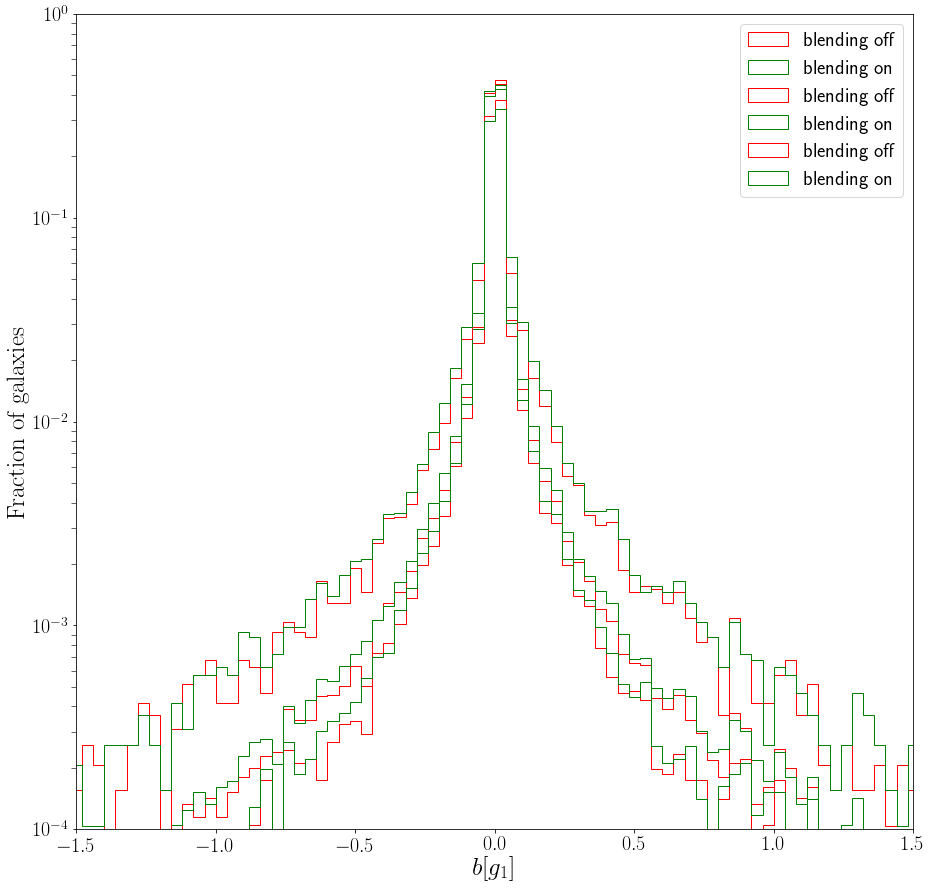

In [24]:
#all filtered cats 
fig = plt.figure(figsize=(15,15))
g_min = -2
g_max = 2
colors = ('red','green')


print 'filtered: '
shear_biases_hists(filtered_cats[8],colors,g_min,g_max,err_mean_iso_fil,err_median_iso_fil,err_mean_grp_fil,err_median_grp_fil)
plt.legend(prop={'size':20})

print '\n intersected: '

shear_biases_hists(intersect_cats[8],colors,g_min,g_max,err_mean_iso_int,err_median_iso_int,err_mean_grp_int,err_median_grp_int)
plt.legend(prop={'size':20})

print '\n not in intersected: '


shear_biases_hists(non_intersect_cats[8],colors,g_min,g_max,err_mean_iso_nint,err_median_iso_nint,err_mean_grp_nint,err_median_grp_nint)
plt.legend(prop={'size':20})




# Calculate a quasi-covariance matrix for each set of 9 catalogs 

In [20]:
filters = [good,best]
filter_cats = get_filter_cats(main_catsLSST, filters)
covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_covariance_matrices(filter_cats)


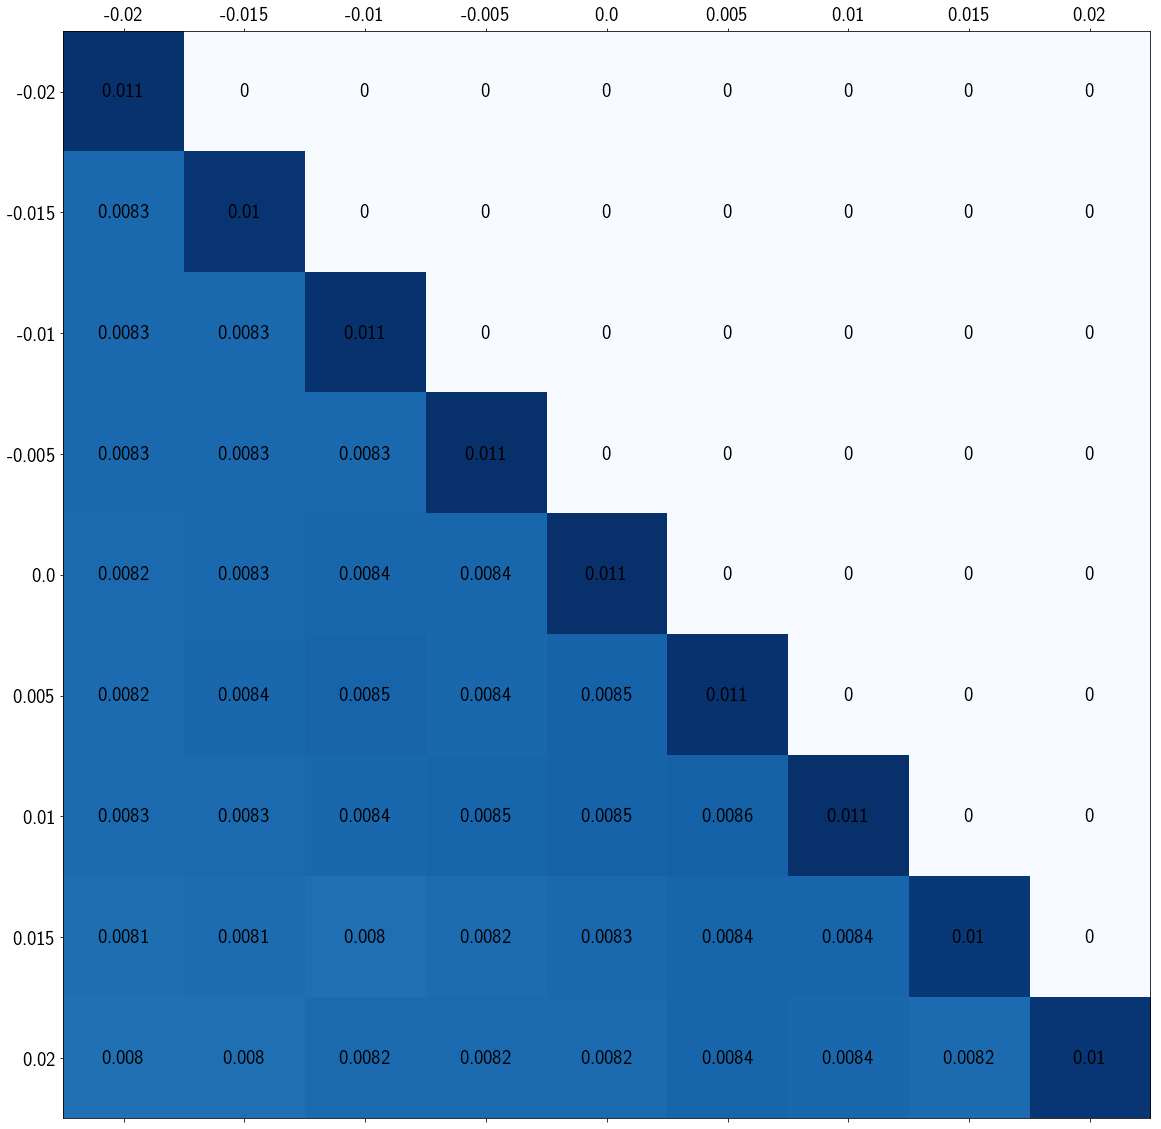

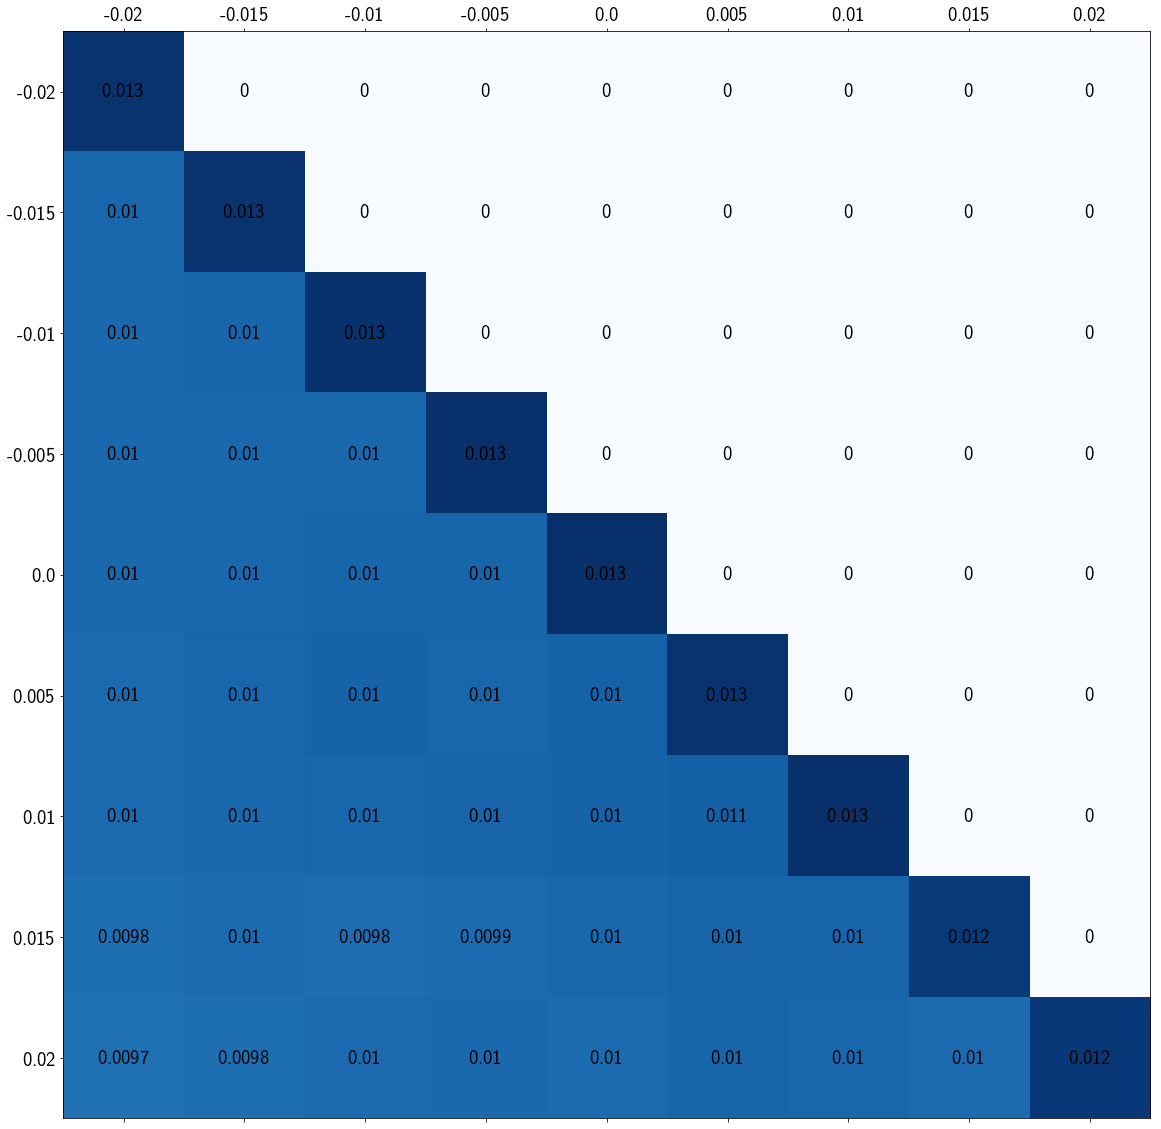

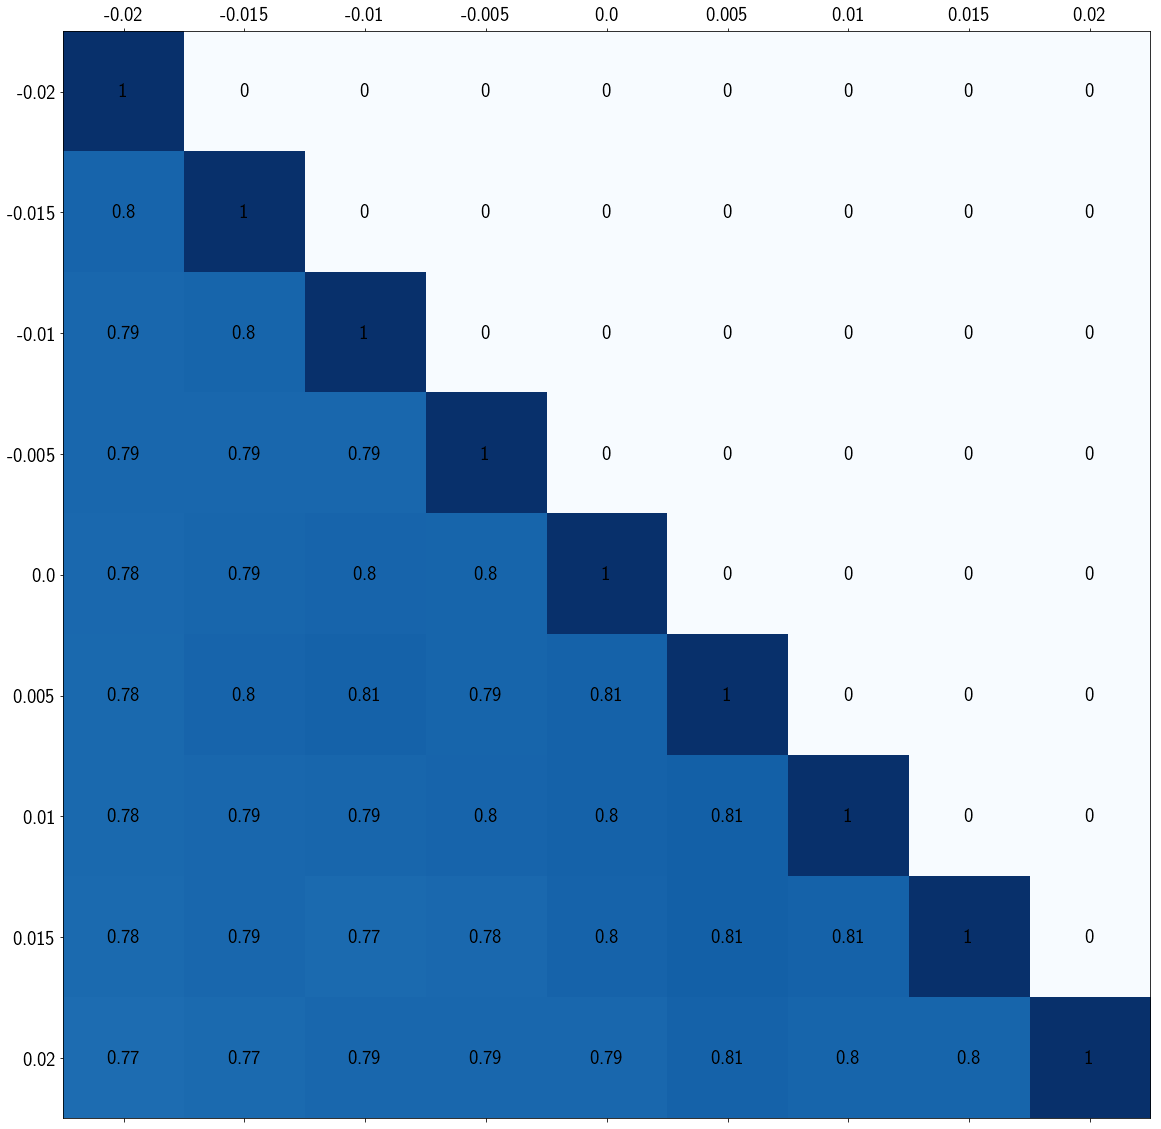

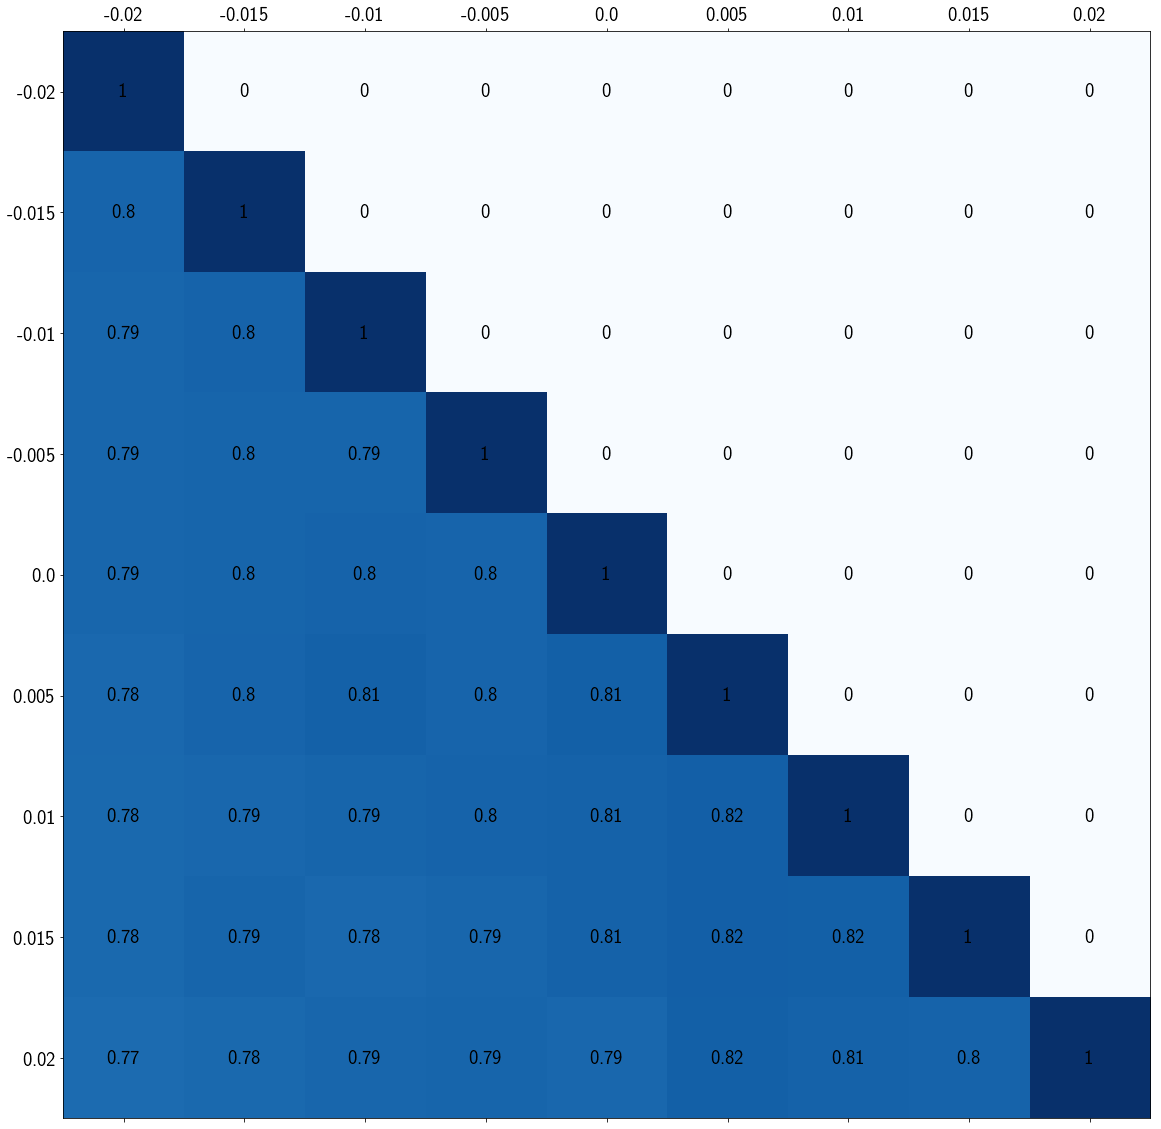

In [28]:
#plot the matrices obtained
plot_matrix(covariance_matrix,g1s)
plot_matrix(covariance_matrix_grp,g1s)
plot_matrix(correlation_matrix,g1s)
plot_matrix(correlation_matrix_grp,g1s)

## Functions for money plot 

In [67]:
#use boostrap to calculate error on the func (median, mean, etc.) 
def errs_param_boot(cats, param, func):
    stds = []
    for cat in cats: 
        true_func = func(cat[param])
    
        #generate random N sample with replacement of func
        N = 10000
        funcs = bootstrap_param_cat(cat, param, N, func)
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print 'just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(funcs,[16,84]) - true_func))
        stds.append(np.absolute(np.percentile(funcs,84) - true_func))
    return stds

In [59]:
#use boostrap to calculate error on the median. 
def errs_mean_boot(cats,param):
    stds = []
    for cat in cats: 
        true_mean = np.mean(cat[param])
        n = len(cat)
    
        #generate random N sample with replacement 
        N = 10000
        means = bootstrap_param_cat(cat, param, N, np.mean)
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print 'just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(means,[16,84]) - true_mean))
        stds.append(np.absolute(np.percentile(means,84) - true_mean))
    return stds


def errs_med_boot(cats,param):
    stds = []
    for cat in cats: 
        n = len(cat)
        true_median = np.median(cat[param])
        N = 10000

        median = bootstrap_param_cat(cat, param, N, np.mean)
        #generate random N sample of medians with replacement 
        meds = []
        for i in range(N):
            sample = np.random.choice(cat[param],size=n)
            meds.append(np.median(sample))
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print 'just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(meds,[16,84]) - true_median))
        stds.append(np.absolute(np.percentile(meds,84) - true_median))
    return stds
    

In [60]:
#calculate error on the slope for a linear function that goes through the origin with bootstrap. 

#WILL NOT BE USED. 
def err_slope_boot(cats,param,filters): 
    meds = [] #each of this is a tuple of 9 medians to fit
    
    filter_cats = get_filter_cats(main_cats,filters)        
    intersect_cats = get_intersection_cats(filter_cats)
      
    #generate random N samples of the slope. 
    N = 10000
    slopes = []

In [61]:
#chi-squared function to calculate linear regression coefficients using covariance matrix. 
def get_mixcov(corr,errs):
    #we obtain a new covariance matrix: 
    mixcov = np.zeros(corr.shape) 
    for i in range(corr.shape[0]): 
        for j in range(corr.shape[1]): 
            mixcov[i,j] = corr[i,j] * errs[i] * errs[j]
            mixcov[j,i] = mixcov[i,j]
        
    return mixcov

def chisqfunc((b0,b1),cov, med_shear_bias,app_shear,inv=None): 
    #errs is a vector of errors on the median shear biases calculated using bootstrap 
    #corr is the correlation matrix calculated between the common elements of the 9 samples. 
    invcov = np.linalg.inv(cov)
    
    if inv: 
        invcov = inv 
    
    #now we used the mixed covariance matrix to calculate the chi-squared: 
    model = b1 + b0*app_shear
    chi2 = np.dot((med_shear_bias - model), np.dot(invcov, med_shear_bias - model))
    
    return chi2

#chi-squared function to calculate linear regression coefficients using covariance matrix. 
def chisq_cov(cov, med_shear_bias,app_shear,inv=None):
    invcov = np.linalg.inv(cov)
    
    if inv: 
        invcov = inv 
    
    #get H matrix, 
    H = np.zeros((len(app_shear), 2)) # 2 refers to b0,b1
    for i in range(len(app_shear)): 
        for j in range(2):
            if j == 0: 
                H[i,j] = app_shear[i]
            else: 
                H[i,j] = 1. 
    
    return np.linalg.inv(np.dot(H.T,np.dot(invcov,H)))

In [62]:
def f(B, x):
    '''Linear function y = m*x that passes thorugh origin.'''
    # B is the slope of the line that passes through the origin.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def linear_fit(g1s,medians,errs,iso_or_grp,fit_args): 
    import scipy.odr
    linear = scipy.odr.Model(f)
    mydata = scipy.odr.RealData(g1s, medians, sy=errs)
    myodr = scipy.odr.ODR(mydata, linear, beta0=[1.,2.])
    myoutput = myodr.run()
    #myoutput.pprint()
    beta0 = myoutput.beta[0]
    beta1 = myoutput.beta[1]
    
    print
    print 'value b0:     {:.3e}'.format(beta0)
    print 'error b0:     {:.3e}'.format(np.sqrt(myoutput.cov_beta[0,0]))
    print 'std error b0: {:.3e}'.format(np.sqrt(myoutput.sd_beta[0]))

    print 'value b1:     {:.3e}'.format(beta1) 
    print 'error b1:     {:.3e}'.format(np.sqrt(myoutput.cov_beta[1,1]))
    print 'std error b1: {:.3e}'.format(np.sqrt(myoutput.sd_beta[1]))
    print 
    
    return beta0, beta1 
    
def chi_sq_fit(g1s,medians,errs,iso_or_grp,fit_args): 
    x0=np.array([0,0])
    print g1s
    cov = fit_args['cov_{}'.format(iso_or_grp)]
    inv = fit_args['inv_{}'.format(iso_or_grp)]
    result =  opt.minimize(chisqfunc,x0,args=(cov,medians,np.array(g1s), inv))
    print result
    #assert result.success==True
    b0,b1 = result.x
    print 
    print
    #get covariance matrix of estimated parameters. 
    param_cov = chisq_cov(cov, medians,np.array(g1s),inv)
    
    print
    print 'value b0:     {:.3e}'.format(b0)
    print 'error b0:     {:.3e}'.format(np.sqrt(param_cov[0,0]))
    print 'value b1:     {:.3e}'.format(b1) 
    print 'error b1:     {:.3e}'.format(np.sqrt(param_cov[1,1]))
    print 
    
#     print
#     print 'chisq cov:', param_cov
    
    return b0,b1
    

In [63]:
def get_money_plot(g1s,gi,errs_grp,errs_iso,main_cats,fit_procedure,fit_args,ticks1=None,ticks2=None,ticks3=None,labely1=None):
    plt.rc('text', usetex=True)

    figure1 = plt.figure(figsize=(20, 20))
    figure2 = plt.figure(figsize=(10, 10))

    ####################BLENDED        
    means = [np.mean(main_cat['bias_{}_grp'.format(gi)]) for main_cat in main_cats]
    medians = [np.median(main_cat['bias_{}_grp'.format(gi)]) for main_cat in main_cats]
    sigmas = [mad(main_cat['bias_{}_grp'.format(gi)]) for main_cat in main_cats]
    # use the method describe in the page above for std of the median 
    errs = errs_grp

    ax1 = figure1.add_subplot(111)
    ax2 = figure2.add_subplot(111)

    print 'means grp:', means
    print 'medians grp:',medians
    print 'sigmas grp:',sigmas 
    print 'errs grp:',errs
    ax1.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',capsize=3)
    
    beta0, beta1 = fit_procedure(g1s,medians,errs,'grp',fit_args)
    
    
    #plot line, 
    x= g1s
    y = [beta0*g1 + beta1 for g1 in x]
    ax1.plot(x,y,c='b')


    ####second plot 
    plt.figure()
    x = g1s[4:]
    y = []
    yerrs= []
    for i,median in enumerate(medians[4:]): 
        y.append(medians[i] + medians[-(i+1)])
        yerrs.append(np.sqrt(errs[i]**2 + errs[-(i+1)]**2))


    ax2.errorbar(x,y,yerr=yerrs,marker='o',linestyle=' ',color='blue',capsize=3)
    
    print 
    print '###################################'

    ################UNBLENDED 

    means = [np.mean(main_cat['bias_{}'.format(gi)]) for main_cat in main_cats]
    medians = [np.median(main_cat['bias_{}'.format(gi)]) for main_cat in main_cats]
    sigmas = [mad(main_cat['bias_{}'.format(gi)]) for main_cat in main_cats]
    # use the method describe in the page above for std of the median 
    errs = errs_iso


    print 'means iso:',  means
    print 'medians iso:',medians
    print 'sigmas iso:',sigmas 
    print 'errs iso:',errs
    ax1.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red',capsize=3)


    beta0, beta1 = fit_procedure(g1s,medians,errs,'iso', fit_args)

    #plot line, 
    x = g1s
    y = [beta0*g1 + beta1 for g1 in x]
    ax1.plot(x,y,c='r')


    ####second plot 
    x = g1s[4:]
    y = []
    yerrs= []
    for i,median in enumerate(medians[4:]): 
        y.append(medians[i] + medians[-(i+1)])
        yerrs.append(np.sqrt(errs[i]**2 + errs[-(i+1)]**2))

    ax2.errorbar(x,y,yerr=yerrs,marker='o',linestyle=' ',color='red',capsize=3)

    ################################################################################################
    #formatting 
    
    #plt.ylim(-10,10)
    ax1.set_xlim([-.025,.025])


    ax1.tick_params(axis='both', which='major', labelsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=30)


    # ax1.yticks(size=20)
    num = gi[1:]

    ax1.set_xlabel(r'$g_{}$'.format(num),size=40)
    
    if labely1 != None: 
        ax1.set_ylabel(r'\rm {}'.format(labely1),size=40)

    ax2.set_xlabel(r'${}$'.format(gi),size=40)


    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    # ax.get_yaxis().get_offset_text().set_size(1)

    ax1.axhline(0,c='g')
    ax2.axhline(0,c='g')

    ax1.tick_params(axis='both', size=10,width=3,which='both')
    ax2.tick_params(axis='both', size=10,width=3,which='both')


    if ticks1 != None: 
        ax1.set_yticklabels(ticks1)
    
    
    if ticks2 != None: 
        ax2.set_yticklabels(ticks2)
        
    if ticks3 != None: 
        ax2.set_xticklabels(ticks3)


# LSST 

### Gold galaxies 

In [63]:
filters = [gold,best]

#### g1 

In [64]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
errs_LSSTgold_g1grp = errs_med_boot(main_catsLSST,'bias_g1_grp',filters) 
errs_LSSTgold_g1iso = errs_med_boot(main_catsLSST,'bias_g1', filters) 

just to check that symmetry is respected print both percentiles: [  6.20954233e-06   5.81716813e-06]
just to check that symmetry is respected print both percentiles: [  5.04236596e-06   5.48605021e-06]
just to check that symmetry is respected print both percentiles: [  5.09204619e-06   4.25651539e-06]
just to check that symmetry is respected print both percentiles: [  4.07121115e-06   4.87147099e-06]
just to check that symmetry is respected print both percentiles: [  3.42151952e-06   3.03529470e-06]
just to check that symmetry is respected print both percentiles: [  3.34785591e-06   3.40373663e-06]
just to check that symmetry is respected print both percentiles: [  4.24434620e-06   4.19613571e-06]
just to check that symmetry is respected print both percentiles: [  4.54118708e-06   5.38920358e-06]
just to check that symmetry is respected print both percentiles: [  5.71398763e-06   6.45759064e-06]
just to check that symmetry is respected print both percentiles: [  2.51451456e-06   2.4714

means grp: [1.2066029, 0.048811562, -1.5960439, -0.99830681, -0.043228138, -0.030435104, 0.4886778, 0.00065465068, 0.052717518]
medians grp: [-6.4274347e-05, -4.6882971e-05, -2.8643775e-05, -1.5612506e-05, -2.0888037e-06, 8.1217795e-06, 2.0092788e-05, 3.750695e-05, 5.6936067e-05]
sigmas grp: [0.0073884875, 0.0073501216, 0.0073839985, 0.0073391749, 0.0073685776, 0.0073742955, 0.0073544933, 0.0073503884, 0.0073657655]
errs grp: [5.817168130306527e-06, 5.4860502132214606e-06, 4.2565153853502092e-06, 4.8714709919295274e-06, 3.0352946964740113e-06, 3.4037366276606917e-06, 4.196135705569759e-06, 5.3892035793978721e-06, 6.457590643549338e-06]
Beta: [  2.86612174e-03  -3.87151761e-06]
Beta Std Error: [  8.55183444e-05   1.10351905e-06]
Beta Covariance: [[  4.16667430e-02  -6.19264889e-07]
 [ -6.19264889e-07   6.93794185e-06]]
Residual Variance: 1.75520971855e-07
Inverse Condition #: 0.0130680158884
Reason(s) for Halting:
  Sum of squares convergence
means iso: [-0.079700664, -0.069176853, -0.0

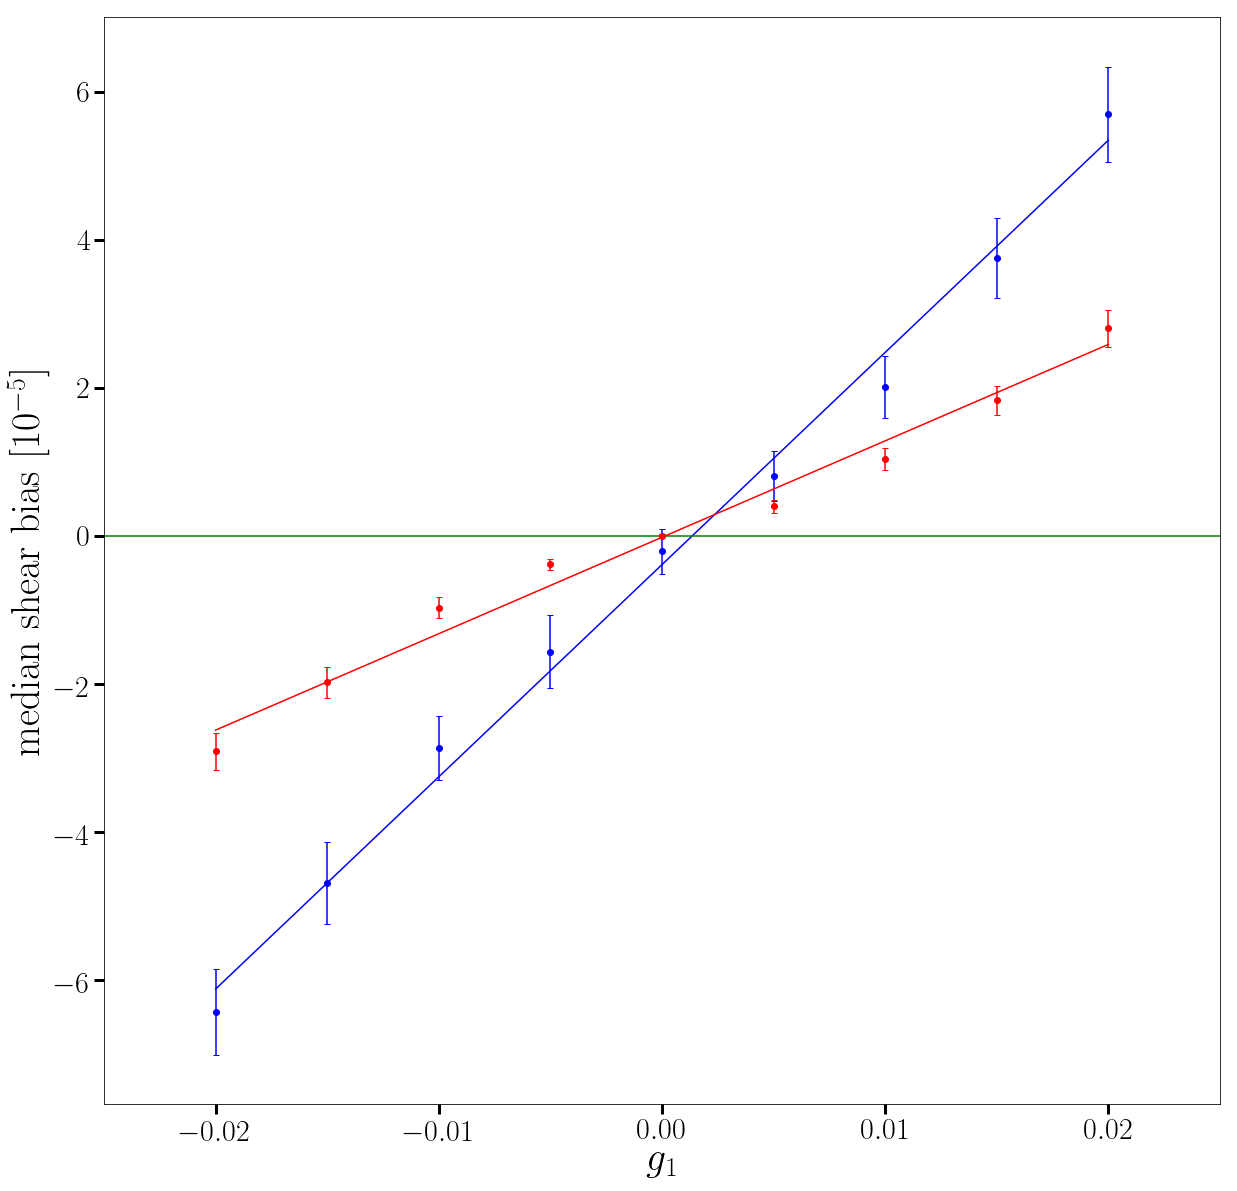

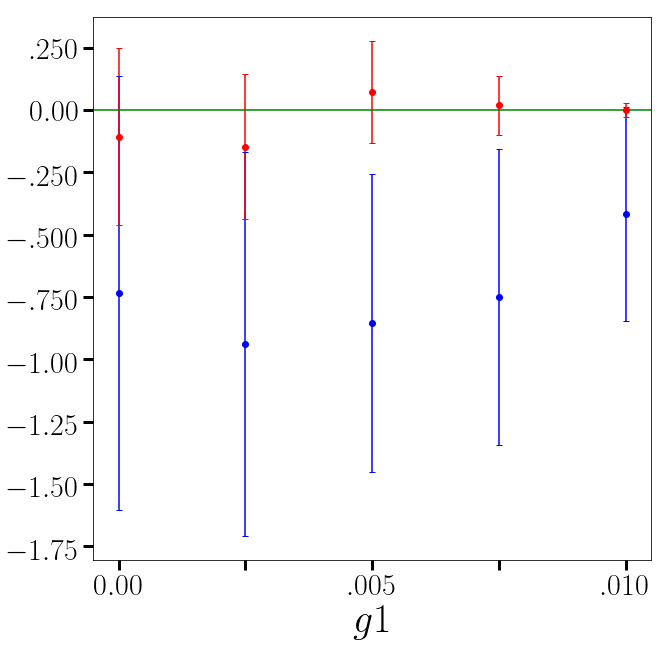

In [65]:
ticks1 = ['','$-6$', '$-4$','$-2$','$0$','$2$','$4$','$6$']
ticks2 = ['','$-1.75$','$-1.50$', '$-1.25$','$-1.00$','$-.750$','$-.500$','$-.250$','$0.00$','$.250$']
ticks3 = ['', '$0.00$','','$.005$','','$.010$','','$.015$','','$.020$']
labely1 = r'\rm median shear bias $[10^{-5}]$'

get_money_plot('g1', errs_LSSTgold_g1grp,errs_LSSTgold_g1iso,filters,main_catsLSST,ticks1,ticks2,ticks3,labely1)

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_LSSTgold_g2grp = sigma_med_boot(main_catsLSST,'bias_g2_grp',filters) 
stds_LSSTgold_g2iso = sigma_med_boot(main_catsLSST,'bias_g2', filters) 

In [ ]:
get_money_plot('g2', stds_LSSTgold_g2grp, stds_LSSTgold_g2iso,filters,main_catsLSST,ticks1,ticks2,ticks3,labely1)

### good galaxies 

In [68]:
filters = [good,best]

#### g1 

In [69]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
filter_cats = get_filter_cats(main_catsLSST, filters) 
errs_LSSTgood_g1grp = errs_param_boot(filter_cats, 'bias_g1_grp', np.median)
errs_LSSTgood_g1iso = errs_param_boot(filter_cats,'bias_g1', np.median) 

just to check that symmetry is respected print both percentiles: [  4.79333903e-06   5.24842835e-06]
just to check that symmetry is respected print both percentiles: [  4.83861615e-06   5.11657345e-06]
just to check that symmetry is respected print both percentiles: [  3.92857510e-06   3.90757850e-06]
just to check that symmetry is respected print both percentiles: [  4.23357505e-06   3.84715986e-06]
just to check that symmetry is respected print both percentiles: [  3.08344545e-06   2.62147205e-06]
just to check that symmetry is respected print both percentiles: [  3.15132456e-06   3.17865679e-06]
just to check that symmetry is respected print both percentiles: [  3.94003837e-06   3.90226887e-06]
just to check that symmetry is respected print both percentiles: [  4.48919673e-06   4.55636837e-06]
just to check that symmetry is respected print both percentiles: [  5.78226172e-06   4.82014002e-06]
just to check that symmetry is respected print both percentiles: [  2.08519305e-06   1.9058

In [70]:
covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_bias_covariance_matrices(filter_cats,'g1')
mixcov_iso,mixcov_grp = get_mixcov(correlation_matrix,errs_LSSTgood_g1iso), get_mixcov(correlation_matrix_grp,errs_LSSTgood_g1grp)

linear fit 

means grp: [1.5145439, 0.13798019, -1.8140323, -1.1292536, -0.02054221, -0.015915656, 0.3697789, -0.015698154, 0.0035246527]
medians grp: [-5.4422708e-05, -3.9863149e-05, -2.6170201e-05, -1.3072816e-05, -1.198442e-06, 7.5850708e-06, 1.9745705e-05, 3.4588884e-05, 5.3075644e-05]
sigmas grp: [0.0049318839, 0.0048842202, 0.0048985714, 0.004852457, 0.0048913299, 0.0048699826, 0.0048894584, 0.0048642526, 0.0048834141]
errs grp: [5.2484283514786512e-06, 5.1165734475944191e-06, 3.9075785025488585e-06, 3.8471598600153811e-06, 2.6214720492134802e-06, 3.1786567888047991e-06, 3.9022688724799082e-06, 4.5563683670479804e-06, 4.8201400204561651e-06]

value b0:     2.566e-03
error b0:     6.642e-02
std error b0: 8.351e-03
value b1:     -2.192e-06
error b1:     8.553e-04
std error b1: 9.476e-04


###################################
means iso: [-0.0028434887, -0.002488645, -0.0016060944, -0.0013810674, -0.00091969536, 0.00042504145, 0.00053271587, 0.0012254076, 0.0021171072]
medians iso: [-

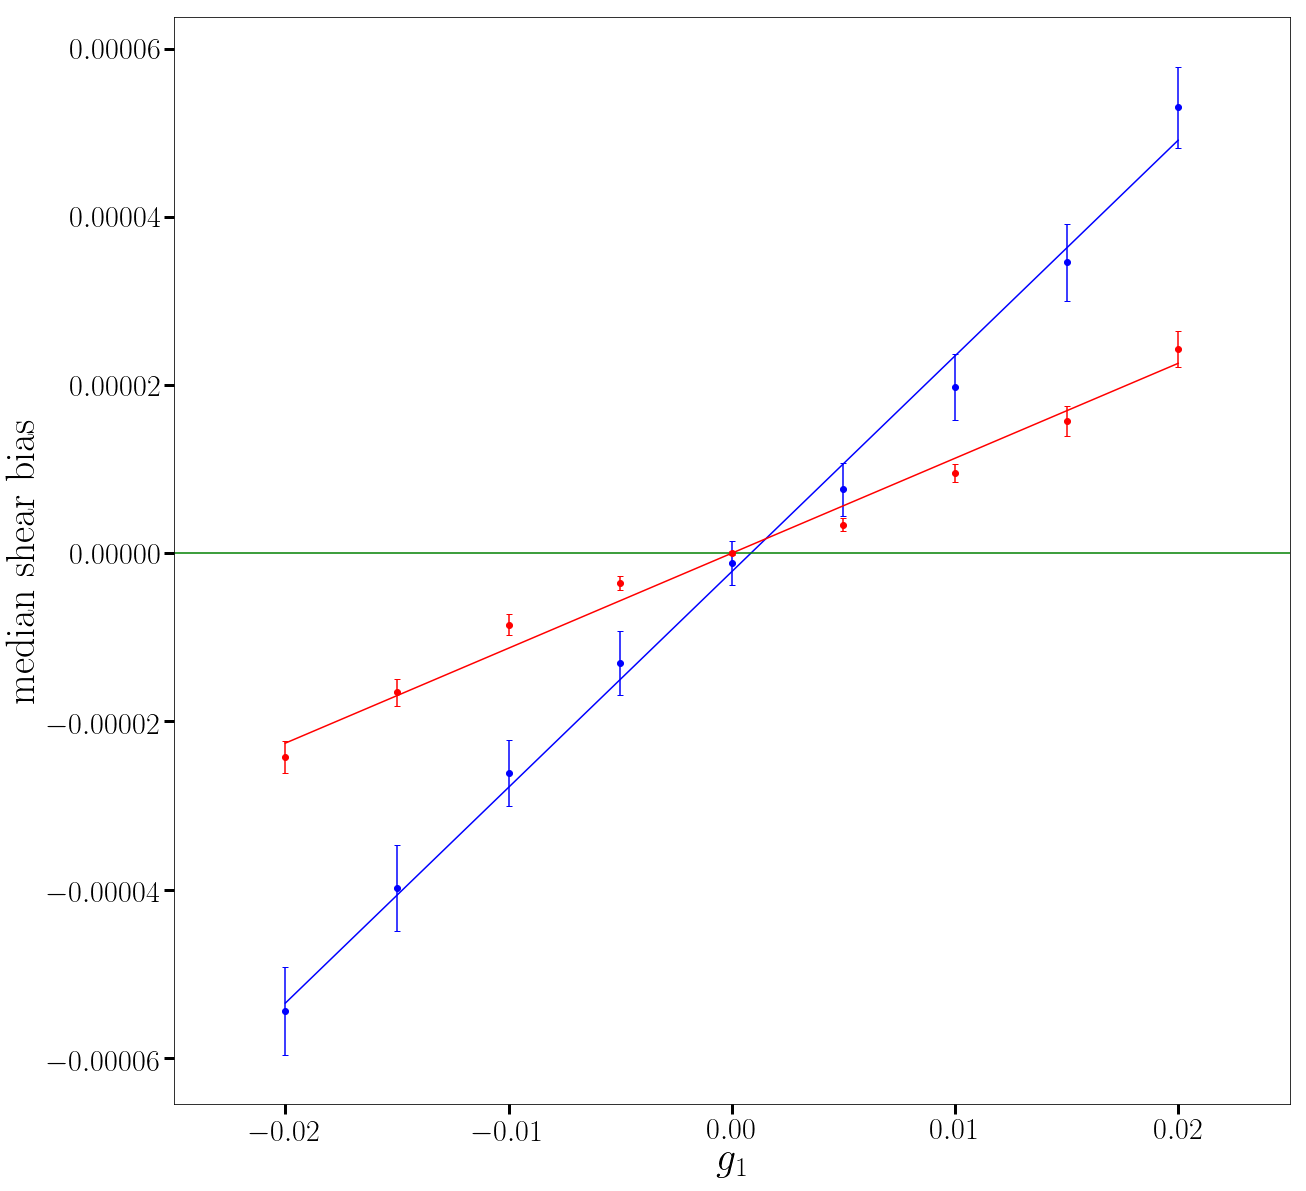

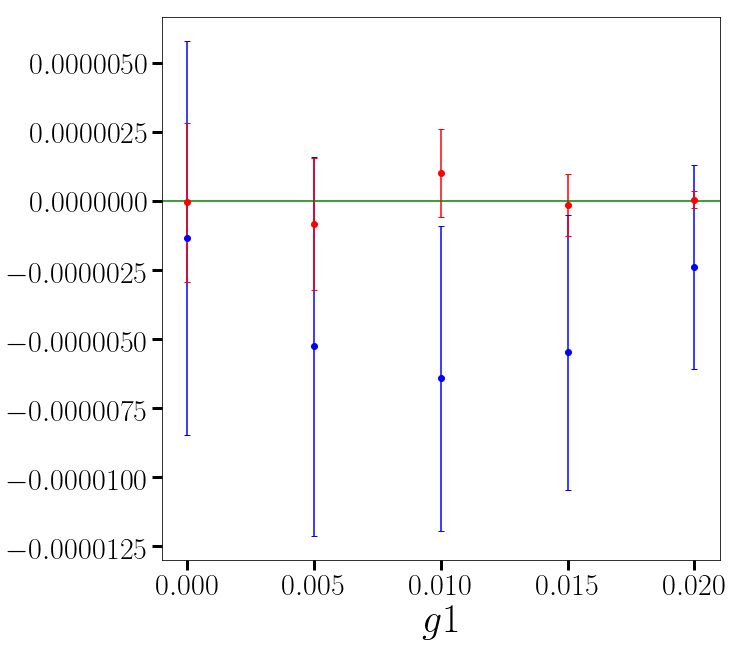

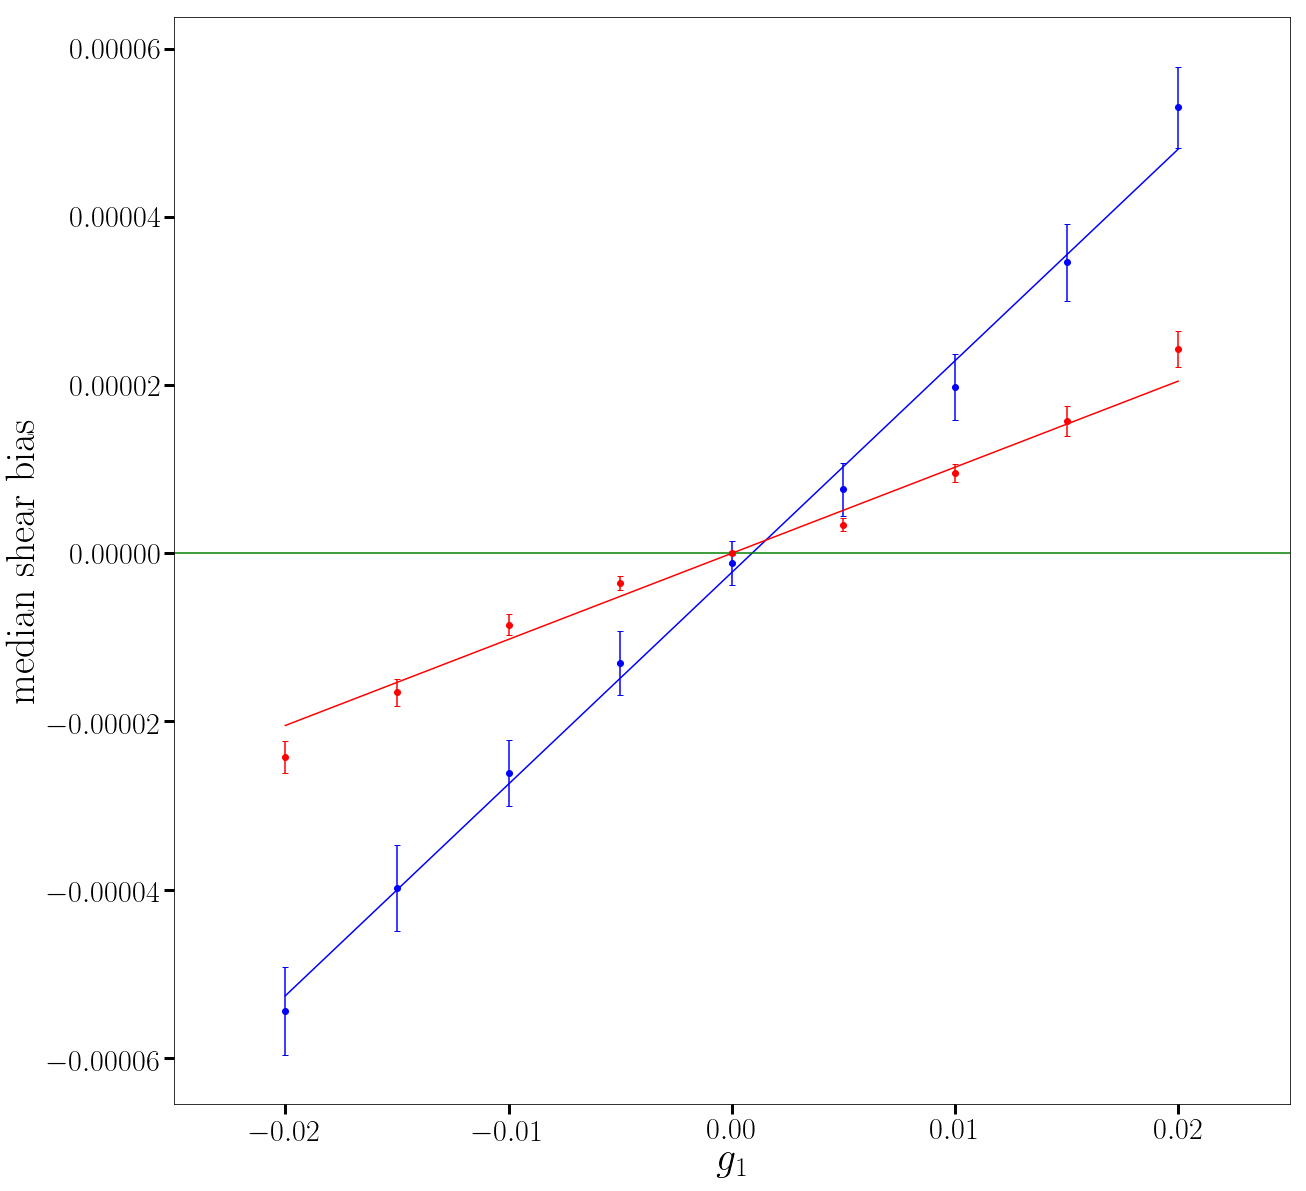

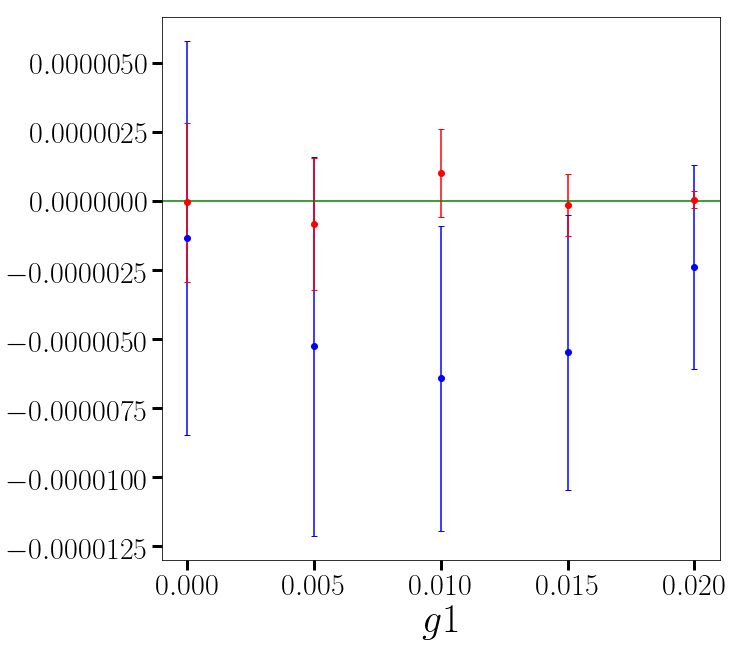

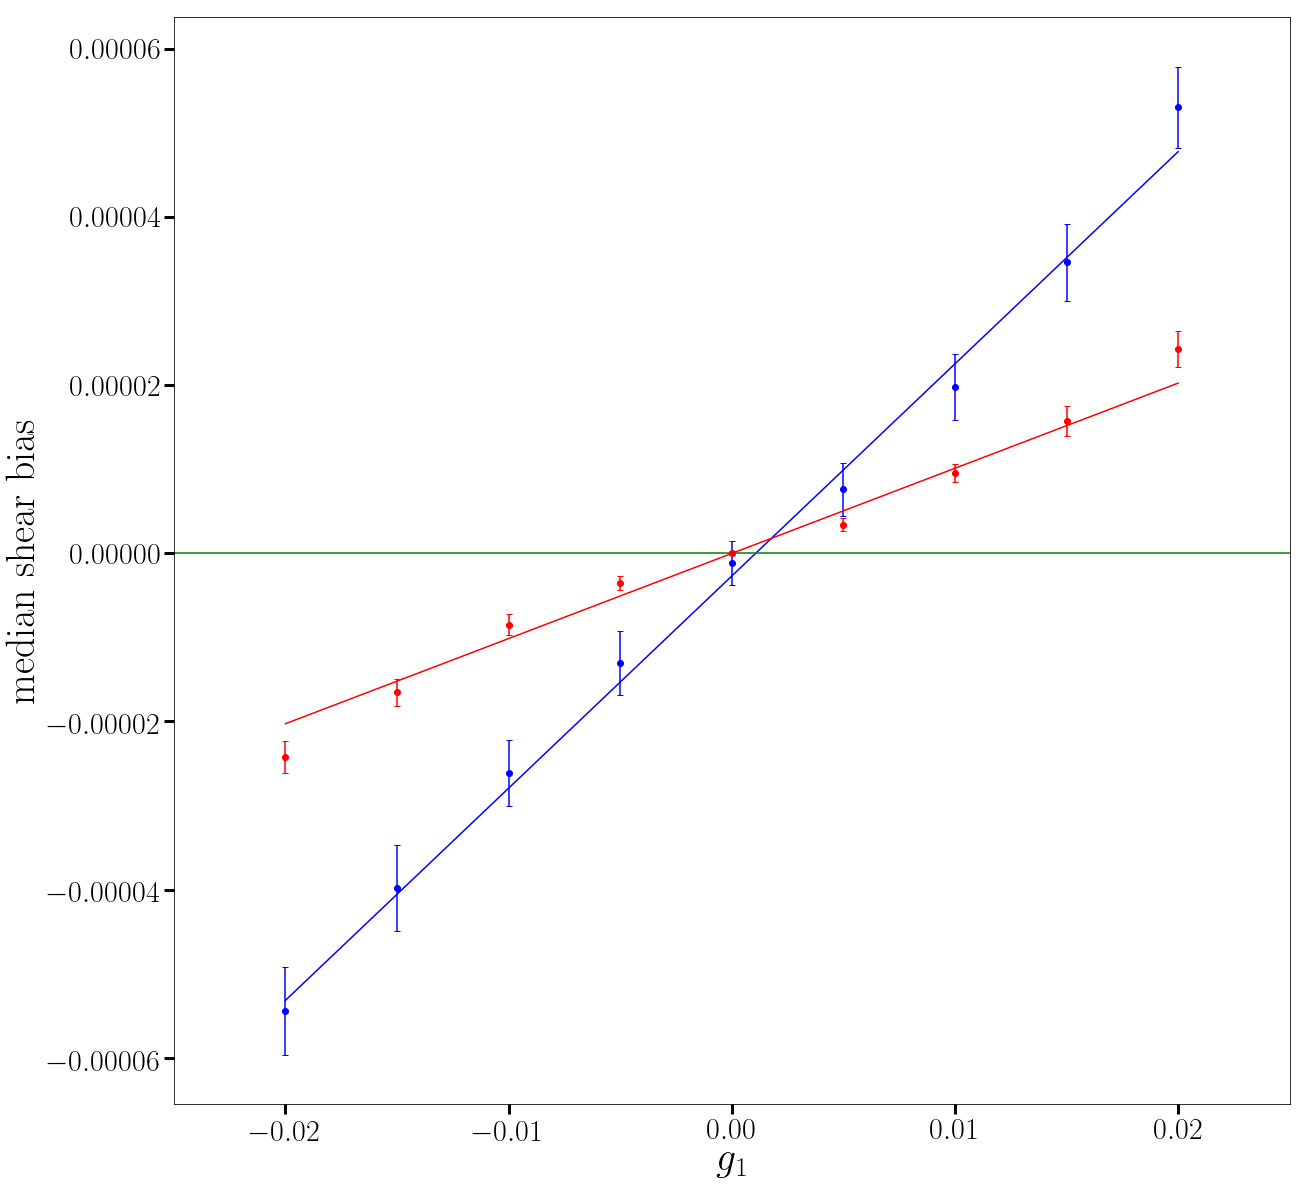

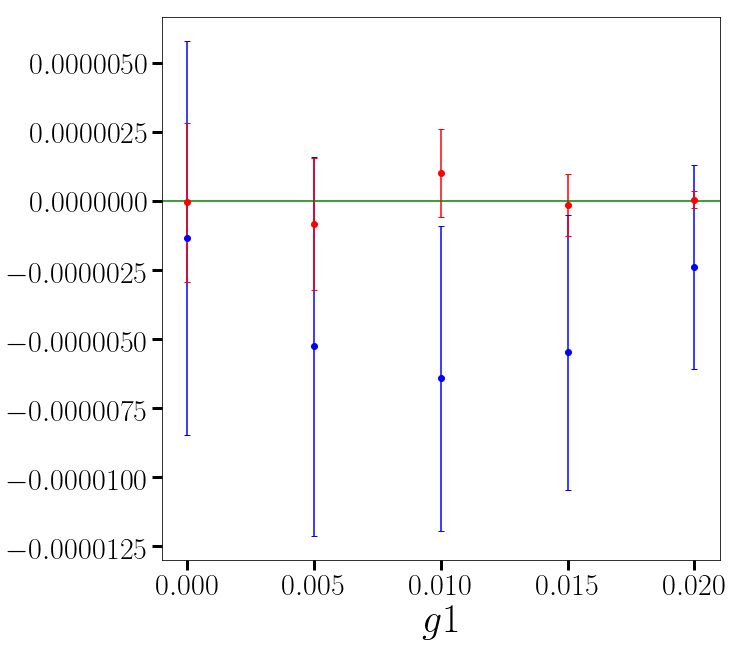

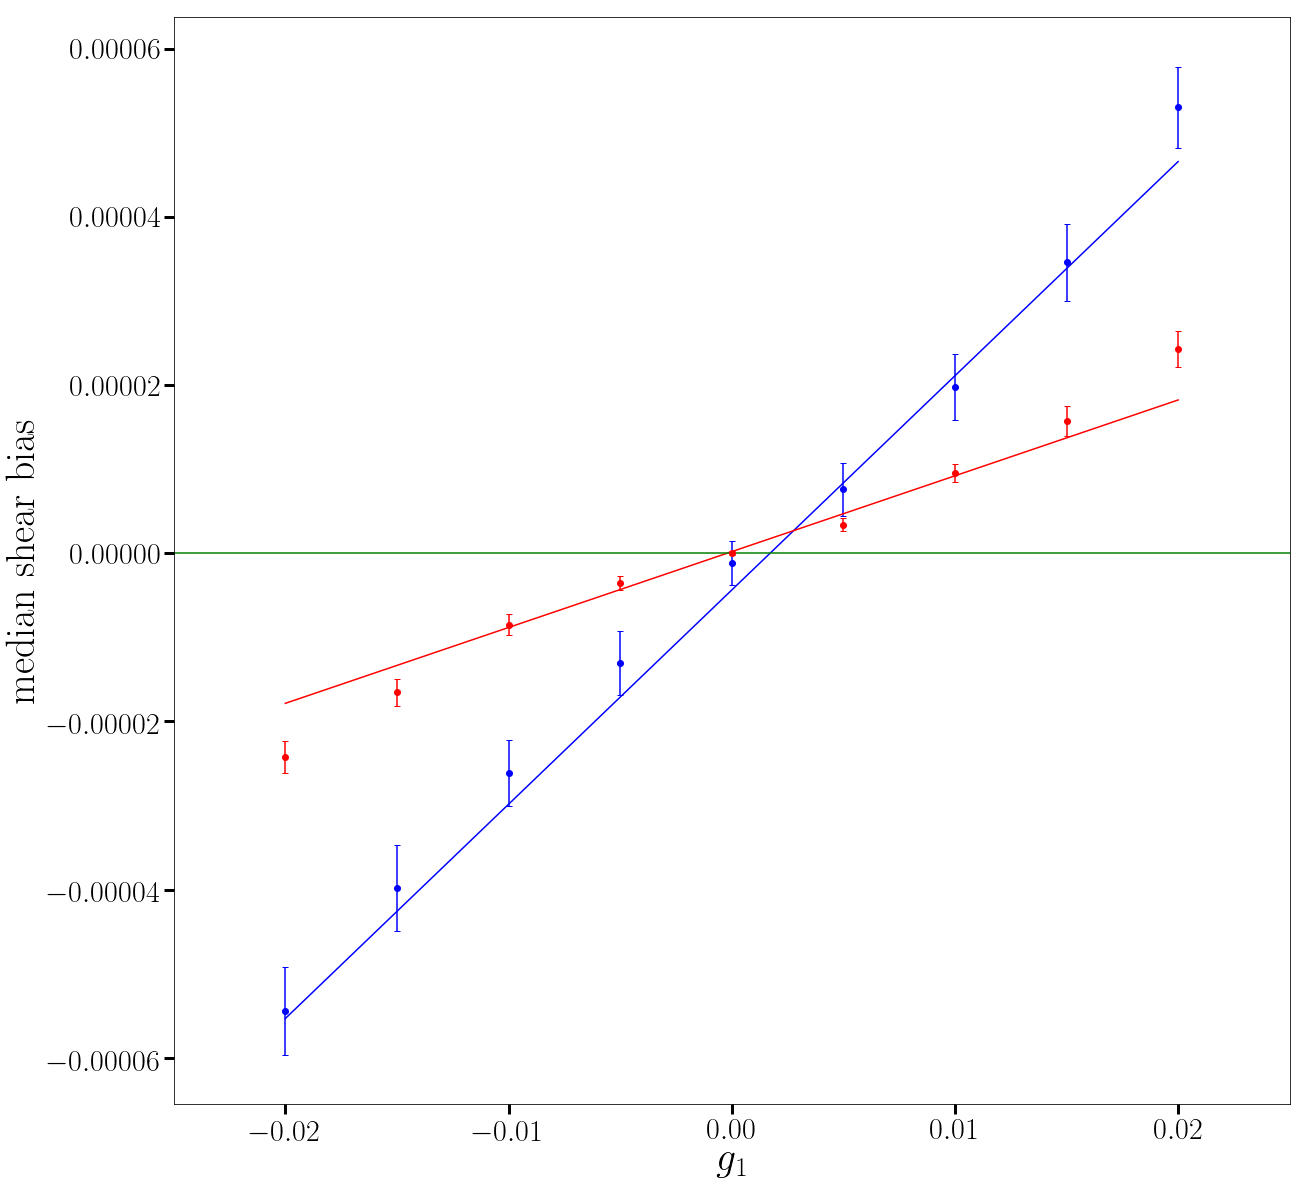

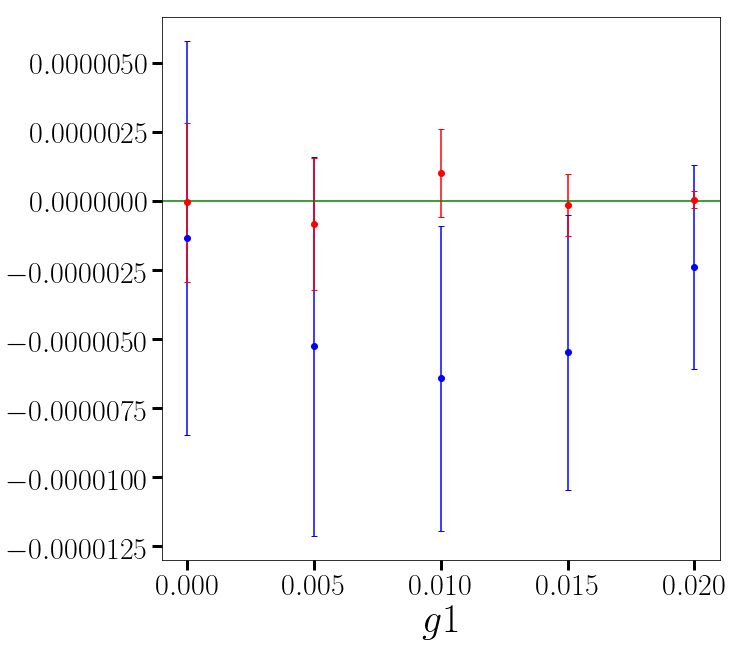

In [74]:
print 'linear fit '
print 
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,linear_fit,{},labely1='median shear bias')
print 
print '###################################################################################'
print 'independent covariance matrix'
print 

# inv_iso = np.diag(np.diag(np.linalg.inv(covariance_matrix)))
# inv_grp = np.diag(np.diag(np.linalg.inv(covariance_matrix_grp)))

#get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(covariance_matrix)), 'cov_grp':np.diag(np.diag(covariance_matrix_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(mixcov_iso)), 'cov_grp':np.diag(np.diag(mixcov_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')


# get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')


print 
print '###################################################################################'
print 'mixed covariance matrix '
print 


get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')

print 
print '###################################################################################'
print 'median bootstrap covariance matrix'
print

get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':boot_covariance_matrix, 'cov_grp':boot_covariance_matrix_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')



In [72]:
#this one filters the cats based only on the shear = 0 one. and then uses the same galaxy across 9 catalogues. 
filter_cats = selection_filter(main_catsLSST,filters)
errs_LSSTgood_g1grp = errs_param_boot(filter_cats,'bias_g1_grp', np.median) 
errs_LSSTgood_g1iso = errs_param_boot(filter_cats,'bias_g1', np.median) 
covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_bias_covariance_matrices(filter_cats,'g1')
mixcov_iso,mixcov_grp = get_mixcov(correlation_matrix,errs_LSSTgood_g1iso), get_mixcov(correlation_matrix_grp,errs_LSSTgood_g1grp)

just to check that symmetry is respected print both percentiles: [  5.72510180e-06   4.73427266e-06]
just to check that symmetry is respected print both percentiles: [  5.11637700e-06   5.12668339e-06]
just to check that symmetry is respected print both percentiles: [  3.86686224e-06   3.84015948e-06]
just to check that symmetry is respected print both percentiles: [  4.26376482e-06   3.84256509e-06]
just to check that symmetry is respected print both percentiles: [  3.11182669e-06   2.66964287e-06]
just to check that symmetry is respected print both percentiles: [  3.21062498e-06   3.38485279e-06]
just to check that symmetry is respected print both percentiles: [  4.03578451e-06   3.83108272e-06]
just to check that symmetry is respected print both percentiles: [  4.47273487e-06   5.00701935e-06]
just to check that symmetry is respected print both percentiles: [  5.34336505e-06   4.92200707e-06]
just to check that symmetry is respected print both percentiles: [  2.42736634e-06   2.0427

linear fit

means grp: [1.5178511, 0.13778824, -0.009943624, 0.010848825, -0.02054221, -0.016314005, 0.40791464, -0.015543934, 0.0043819253]
medians grp: [-5.7286583e-05, -3.9797149e-05, -2.580251e-05, -1.3072816e-05, -1.198442e-06, 9.2433702e-06, 2.1094133e-05, 3.6438461e-05, 5.3895998e-05]
sigmas grp: [0.0049184468, 0.0048864018, 0.0048824241, 0.0048724758, 0.0048913299, 0.004876487, 0.0048844591, 0.0048857946, 0.0048981225]
errs grp: [4.7342726611532303e-06, 5.126683390699327e-06, 3.8401594792958349e-06, 3.8425650927820243e-06, 2.6696428676586947e-06, 3.3848527891677804e-06, 3.8310827221721411e-06, 5.0070193537976593e-06, 4.9220070650335401e-06]

value b0:     2.644e-03
error b0:     6.841e-02
std error b0: 8.184e-03
value b1:     -1.832e-06
error b1:     8.812e-04
std error b1: 9.288e-04


###################################
means iso: [-0.0031766745, -0.0026869392, -0.0021853282, -0.0015513464, -0.00091969536, -0.00027027554, 0.00041992022, 0.0012576594, 0.0017476629]
medians iso:

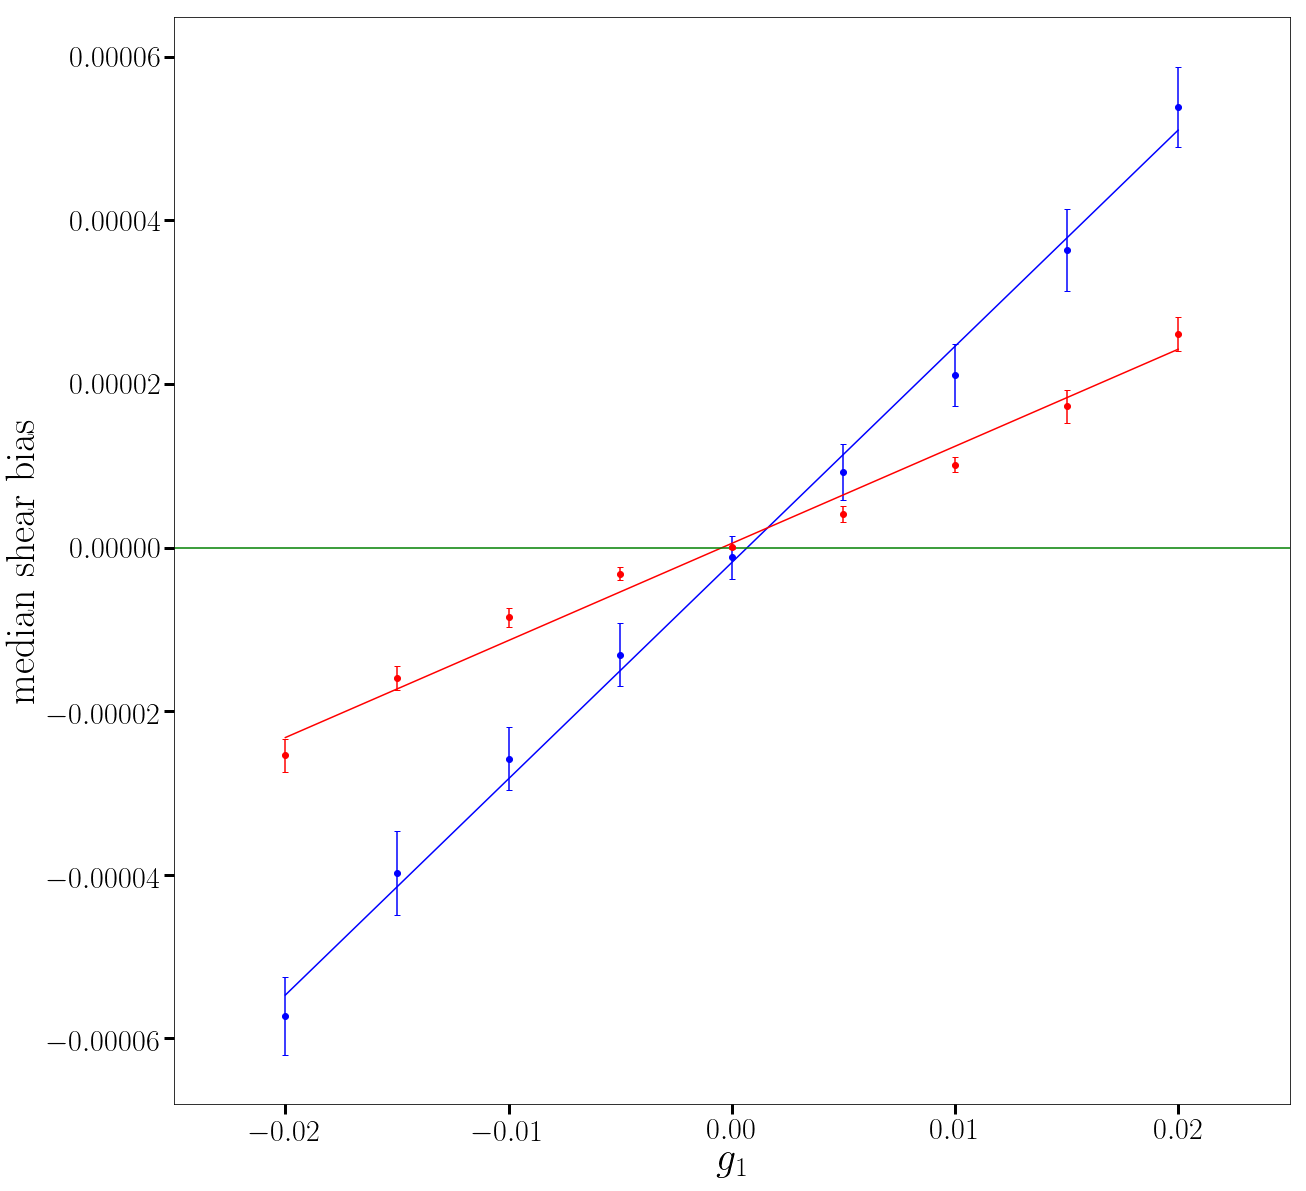

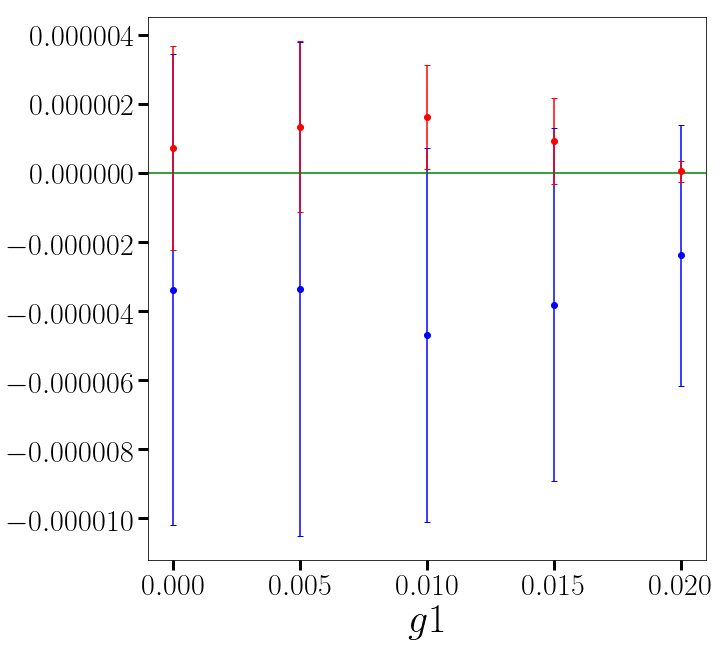

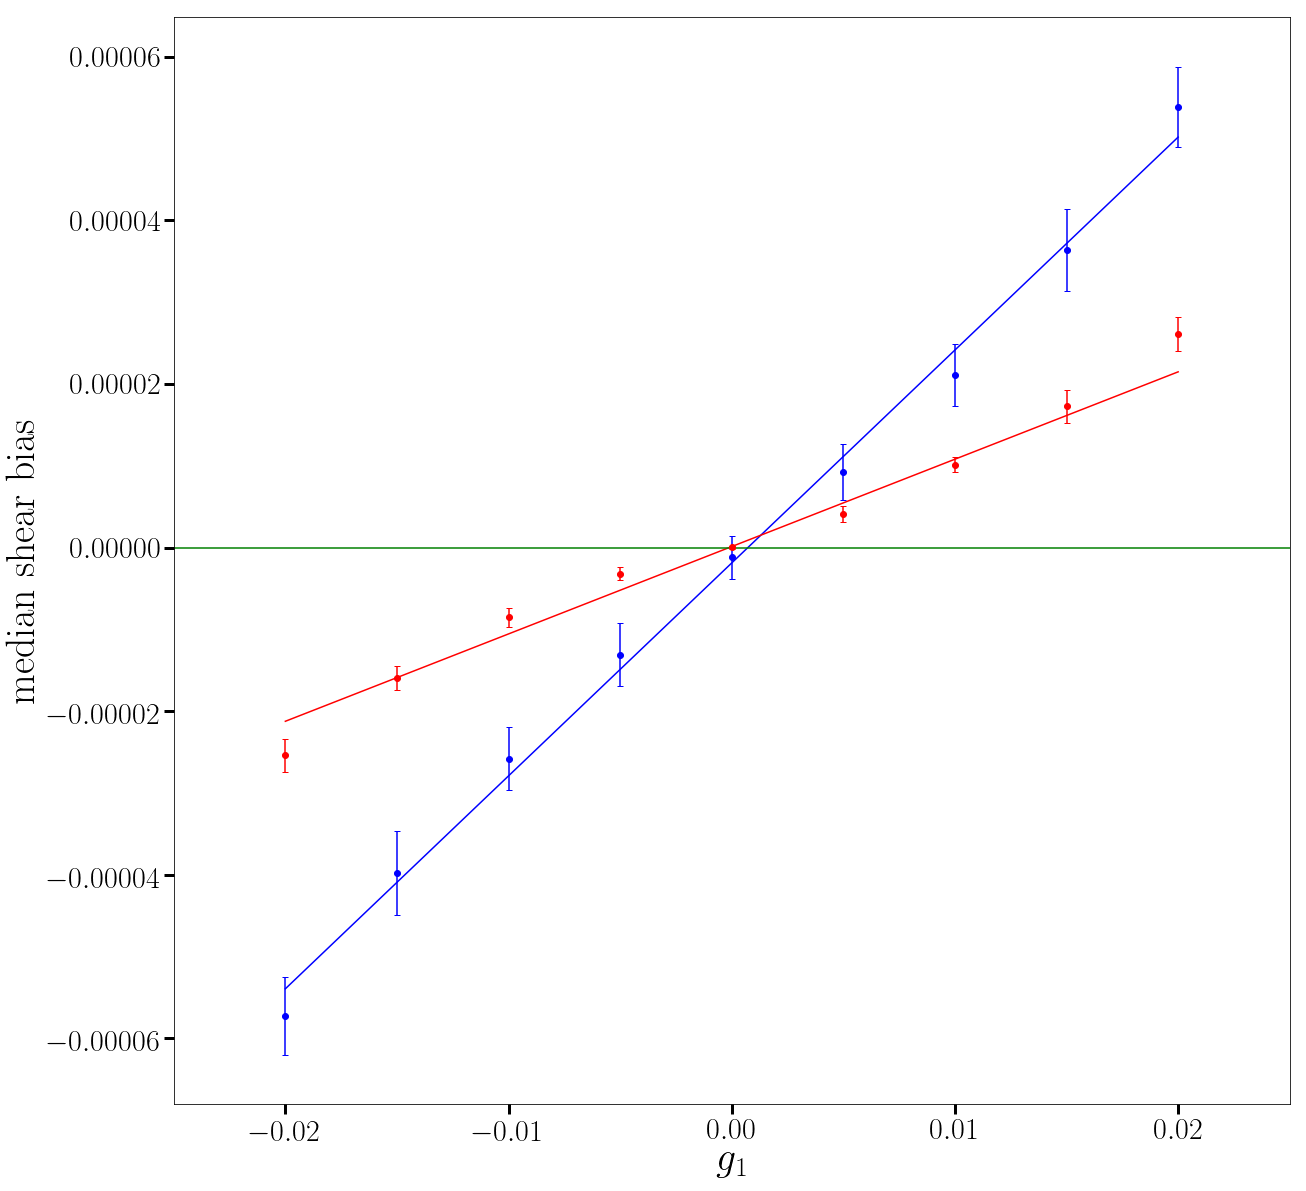

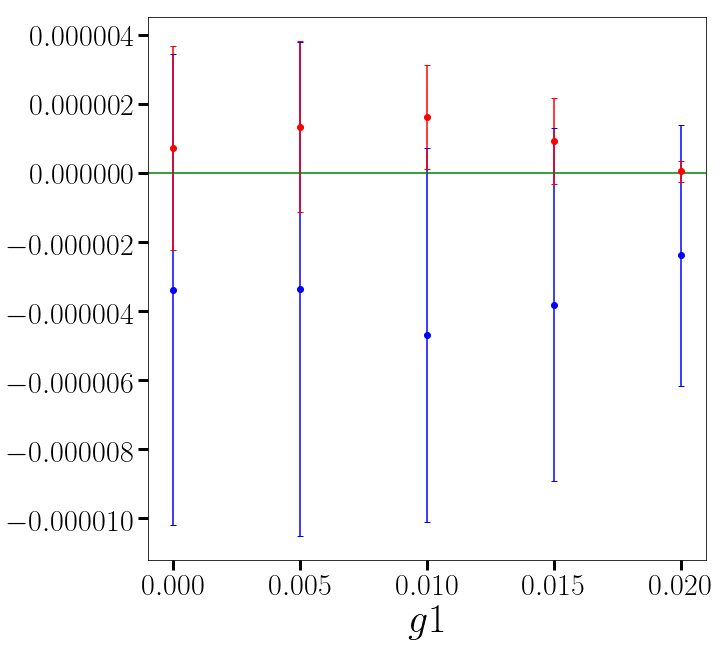

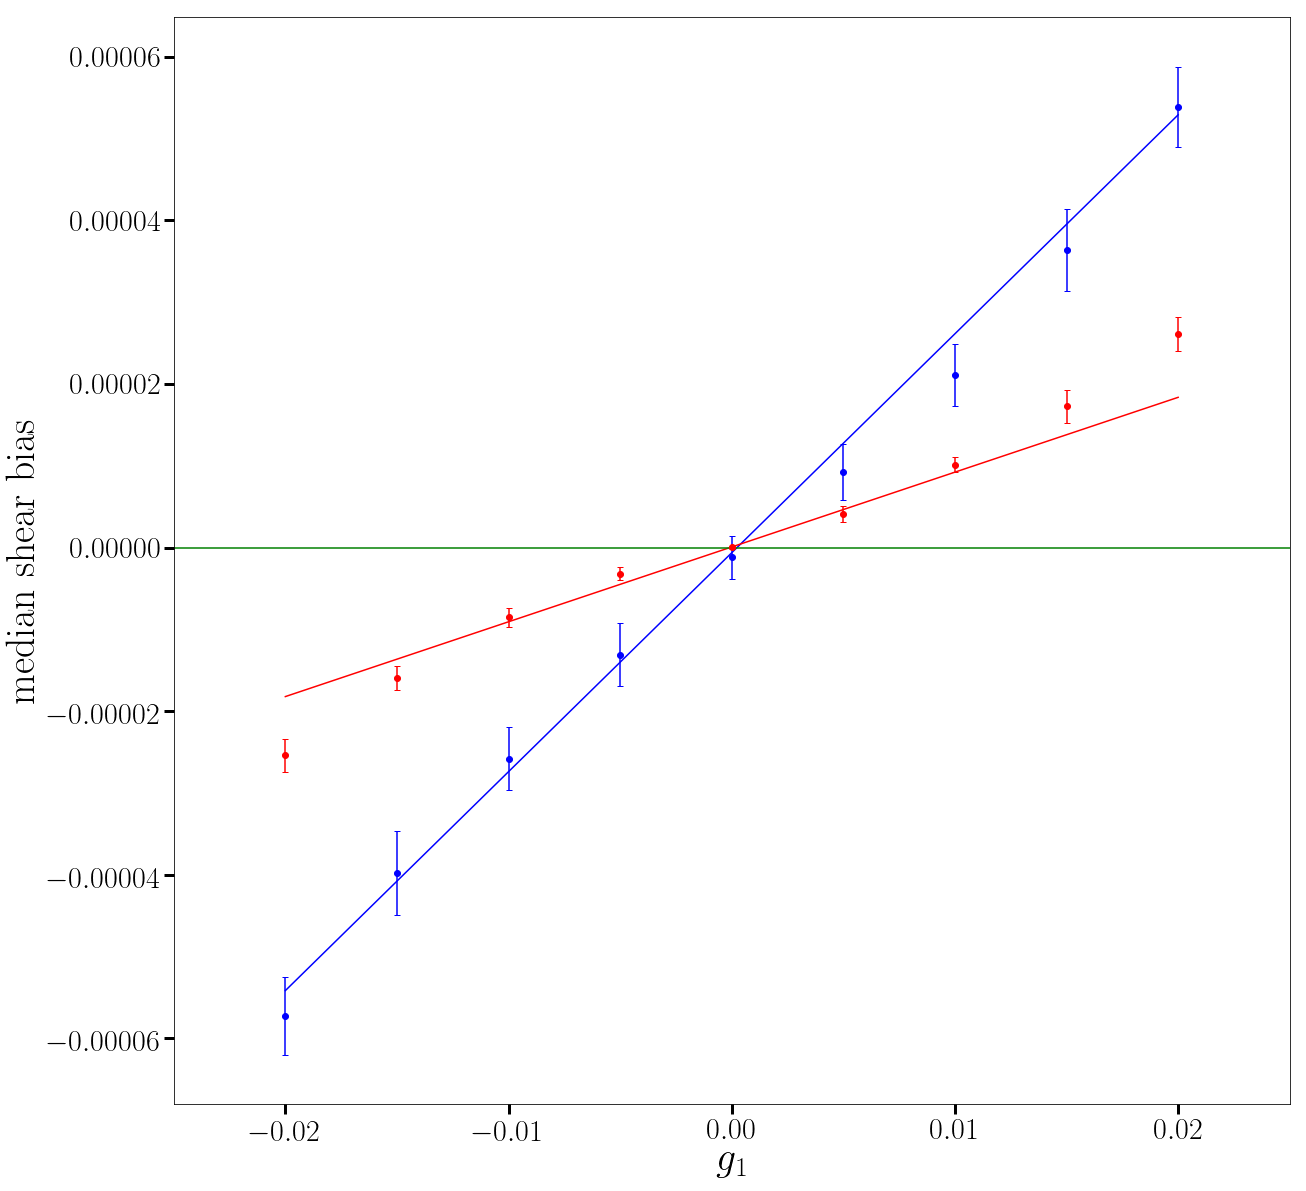

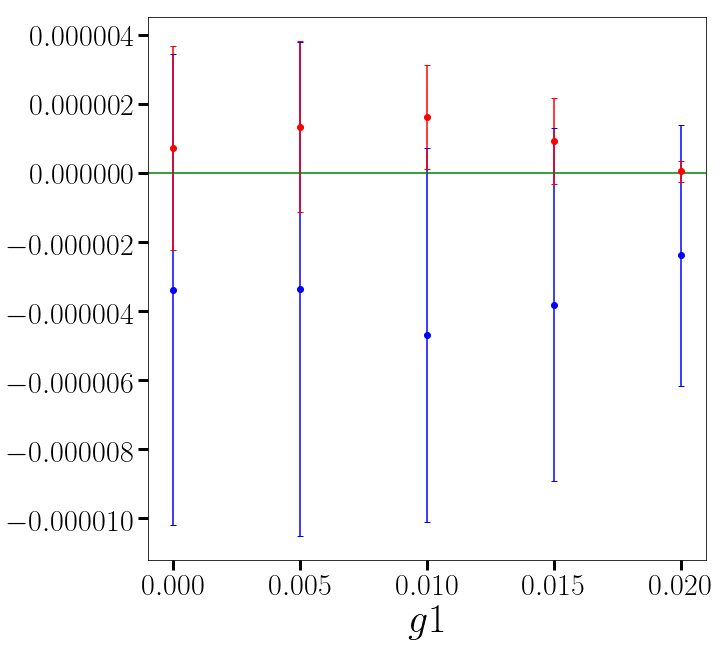

In [79]:
print 'linear fit'
print 
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,linear_fit,{},labely1='median shear bias')

print 
print '###################################################################################'

print 'independent chi sq '
print 

#get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(covariance_matrix)), 'cov_grp':np.diag(np.diag(covariance_matrix_grp))},labely1='median shear bias')
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(mixcov_iso)), 'cov_grp': np.diag(np.diag(mixcov_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')



print 
print '###################################################################################'

print 'mixed chi sq '
print

get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')

In [80]:
# the last option is to completely use the 85% galaxies that stay after intersection. 
#this one filters the cats based only on the shear = 0 one. and then uses the same galaxy across 9 catalogues. 
filter_cats = get_intersection_cats(get_filter_cats(main_catsLSST,filters))
errs_LSSTgood_g1grp = errs_med_boot(filter_cats,'bias_g1_grp') 
errs_LSSTgood_g1iso = errs_med_boot(filter_cats,'bias_g1') 
covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp = get_bias_covariance_matrices(filter_cats,'g1')
mixcov_iso,mixcov_grp = get_mixcov(correlation_matrix,errs_LSSTgood_g1iso), get_mixcov(correlation_matrix_grp,errs_LSSTgood_g1grp)

just to check that symmetry is respected print both percentiles: [  4.69566294e-06   4.91798710e-06]
just to check that symmetry is respected print both percentiles: [  4.15767739e-06   3.39517464e-06]
just to check that symmetry is respected print both percentiles: [  3.74007082e-06   3.46902925e-06]
just to check that symmetry is respected print both percentiles: [  4.04194179e-06   3.62911163e-06]
just to check that symmetry is respected print both percentiles: [  2.68503231e-06   2.80919941e-06]
just to check that symmetry is respected print both percentiles: [  2.55084024e-06   2.87356897e-06]
just to check that symmetry is respected print both percentiles: [  2.73808109e-06   2.97329592e-06]
just to check that symmetry is respected print both percentiles: [  3.77636541e-06   3.86419197e-06]
just to check that symmetry is respected print both percentiles: [  4.47867933e-06   4.18718264e-06]
just to check that symmetry is respected print both percentiles: [  1.55099857e-06   1.9263

linear fit

means grp: [-0.019624801, 0.010422705, -0.009438769, 0.016076708, -0.024706786, -0.01816, -0.0087735169, -0.018515399, 0.0062621487]
medians grp: [-4.390689e-05, -3.0467365e-05, -2.0881333e-05, -1.1358727e-05, -2.8515503e-06, 4.8045526e-06, 1.3521347e-05, 2.4394334e-05, 3.5833262e-05]
sigmas grp: [0.0034618084, 0.0034645433, 0.0034547779, 0.0034460481, 0.0034437273, 0.0034446106, 0.0034456556, 0.0034546473, 0.003471707]
errs grp: [4.9179870984517038e-06, 3.3951746445382014e-06, 3.4690292523009703e-06, 3.6291116339270918e-06, 2.8091994147416692e-06, 2.8735689738823567e-06, 2.9732959228567757e-06, 3.8641919672954828e-06, 4.1871826397255063e-06]

value b0:     1.903e-03
error b0:     4.922e-02
std error b0: 6.724e-03
value b1:     -3.435e-06
error b1:     6.342e-04
std error b1: 7.632e-04


###################################
means iso: [-0.0018960793, -0.0014509897, -0.0010071399, -0.00056510477, -0.00012216262, 0.00032115789, 0.0007647507, 0.0012082338, 0.0016523468]
medians

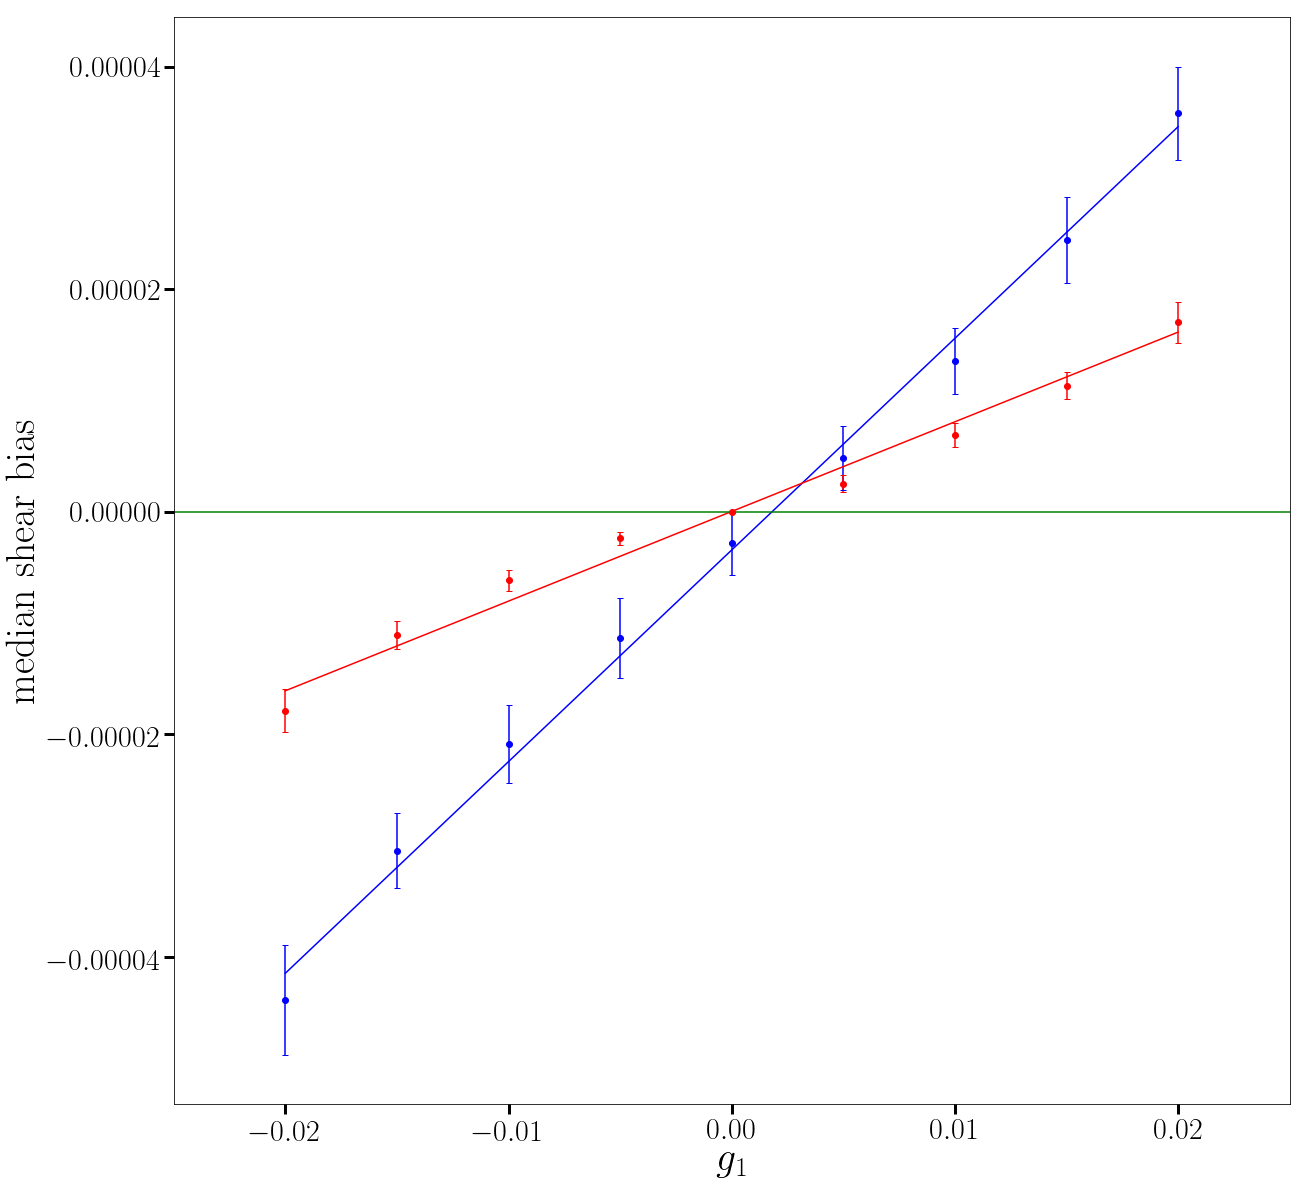

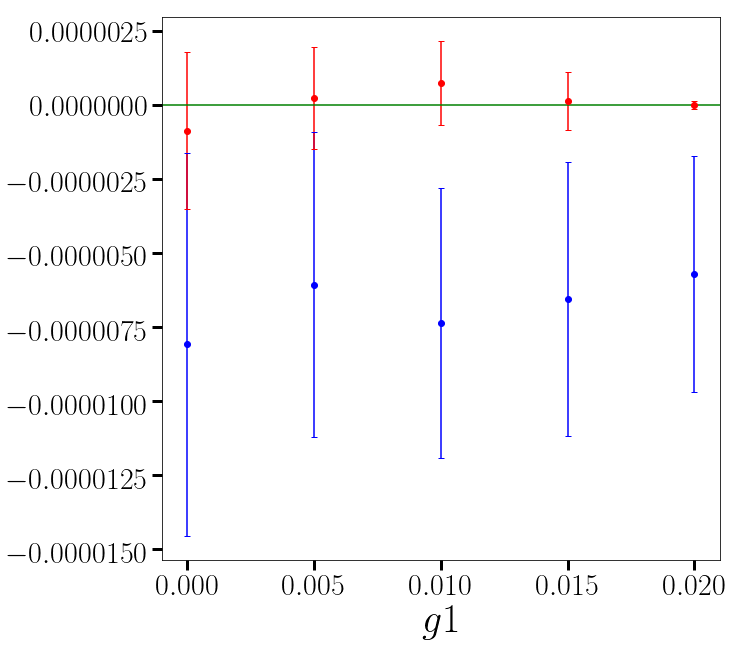

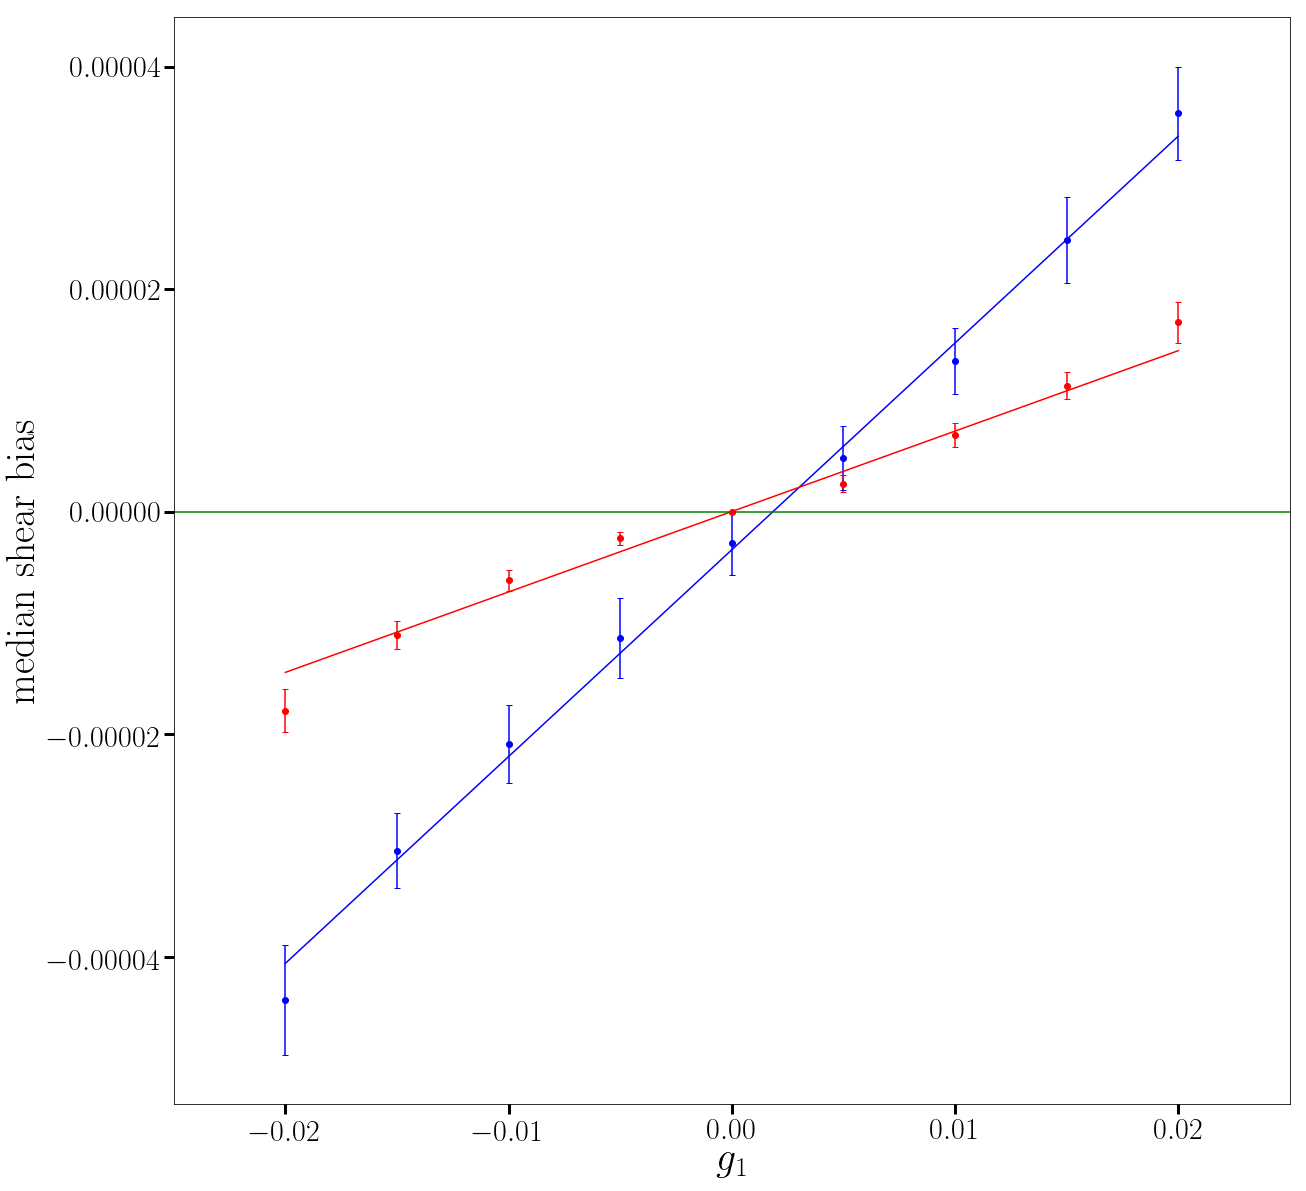

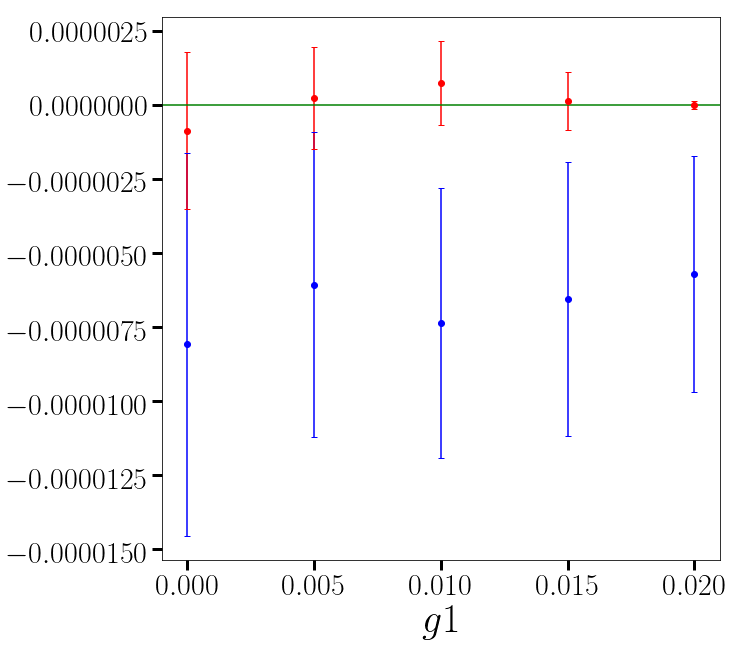

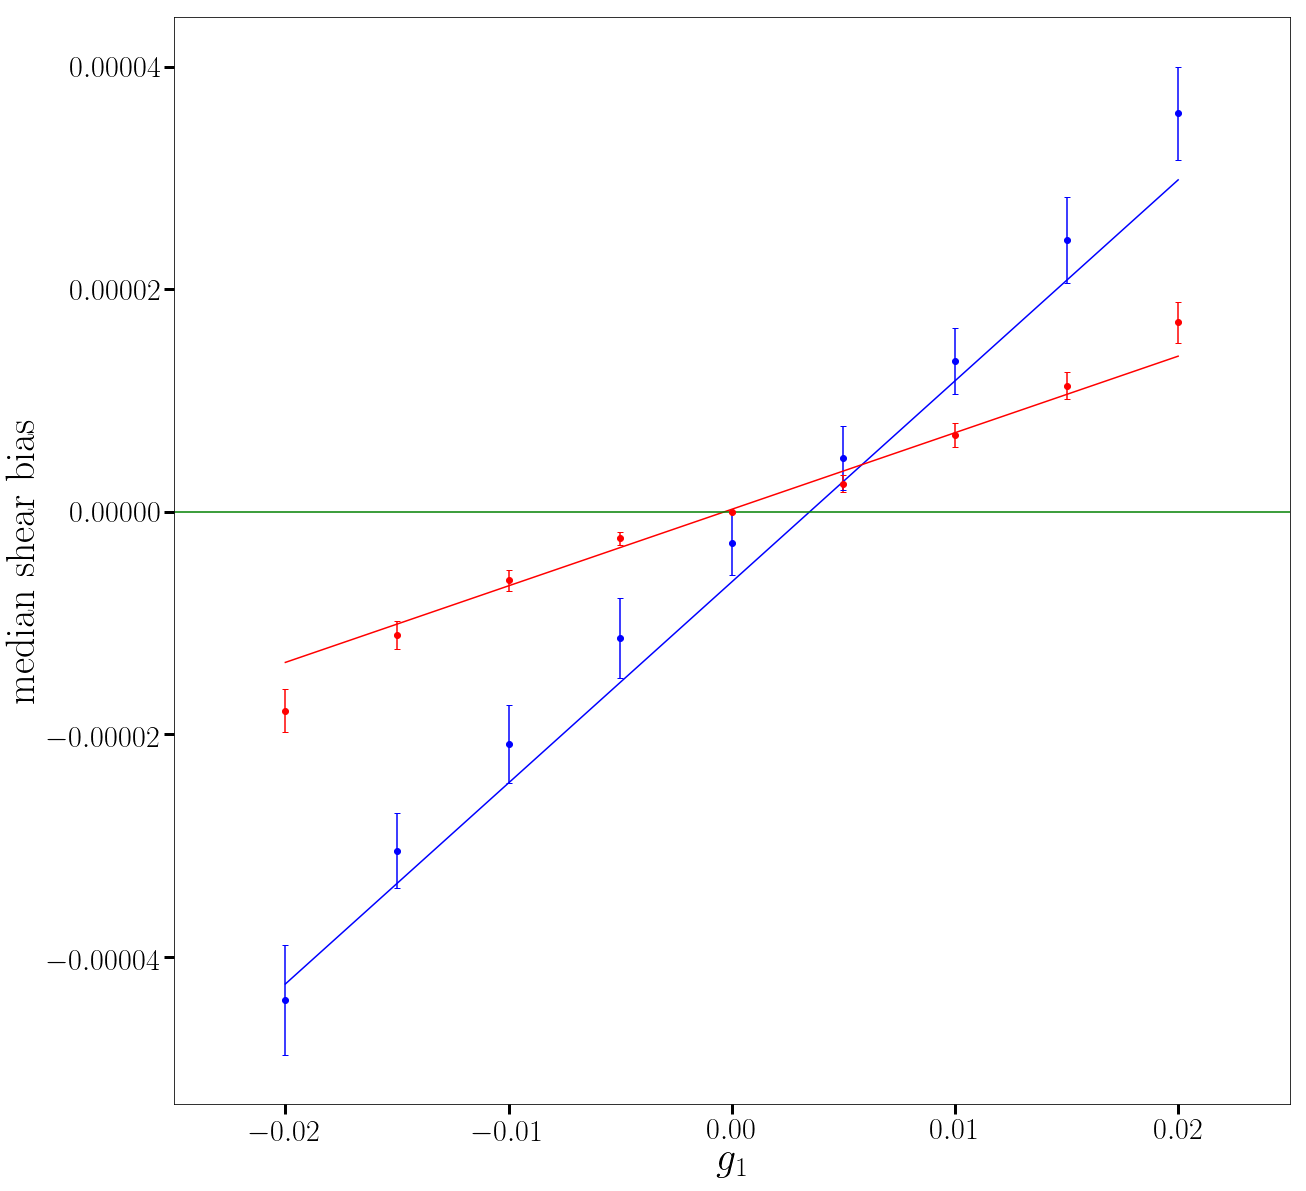

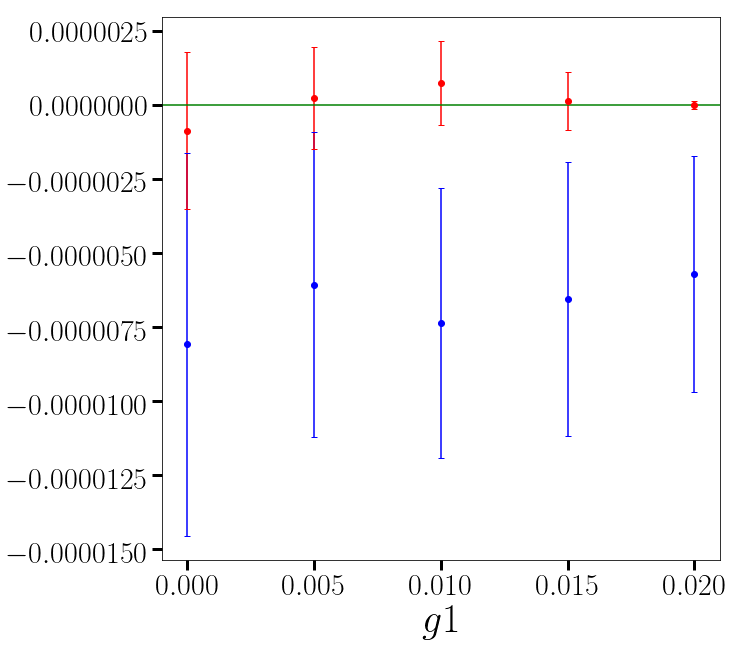

In [81]:
print 'linear fit'
print 
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,linear_fit,{},labely1='median shear bias')

print 
print '###################################################################################'

print 'independent chi sq '
print 

#get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(covariance_matrix)), 'cov_grp':np.diag(np.diag(covariance_matrix_grp))},labely1='median shear bias')
get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':np.diag(np.diag(mixcov_iso)), 'cov_grp': np.diag(np.diag(mixcov_grp)),'inv_iso':None,'inv_grp':None},labely1='median shear bias')



print 
print '###################################################################################'

print 'mixed chi sq '
print

get_money_plot(g1s, 'g1', errs_LSSTgood_g1grp, errs_LSSTgood_g1iso,filter_cats,chi_sq_fit,{'cov_iso':mixcov_iso, 'cov_grp':mixcov_grp,'inv_iso':None,'inv_grp':None},labely1='median shear bias')

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_LSSTgood_g2grp = sigma_med_boot(main_catsLSST,'bias_g2_grp',filters) 
stds_LSSTgood_g2iso = sigma_med_boot(main_catsLSST,'bias_g2',filters) 

In [ ]:
get_money_plot('g2', stds_LSSTgood_g2grp, stds_LSSTgood_g2iso,filters,main_catsLSST)

# DES 

## Gold

In [21]:
filters = [gold,best]

#### g1

In [24]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgold_g1grp = sigma_med_boot(main_catsDES,'bias_g1_grp',filters) 
stds_DESgold_g1iso = sigma_med_boot(main_catsDES,'bias_g1',filters) 

medians grp: [-6.083382e-05, -4.3239692e-05, -3.0325526e-05, -1.9896146e-05, -1.7860621e-05, 1.9478223e-06, 1.096516e-05, 2.3857307e-05, 3.8978156e-05]
sigmas grp: [0.0050557679, 0.0050973729, 0.0051644775, 0.0052130572, 0.0051384792, 0.0050382288, 0.0051085027, 0.0051329629, 0.0050904029]
errs grp: [1.5543656e-05, 1.481764e-05, 1.6068832e-05, 1.4794075e-05, 1.4766653e-05, 1.3792296e-05, 1.4928709e-05, 1.4897316e-05, 1.6175911e-05]
Beta: [ 0.00240815]
Beta Std Error: [ 0.00030801]
Beta Covariance: [[ 0.02126463]]
Residual Variance: 4.46145857229e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.543715e-05, -9.2823739e-06, -4.2521724e-06, -1.2076104e-06, 2.5281606e-08, 3.6787555e-06, 7.4198456e-06, 1.2083221e-05, 1.6988095e-05]
sigmas iso: [0.0026806057, 0.0026587714, 0.0027063512, 0.0026739959, 0.0026560463, 0.0027038625, 0.0026652717, 0.0026803096, 0.0026562614]
errs iso: [4.1221606e-06, 3.1559425e-06, 2.1079518e-06, 1.2314691e-06, 7.794

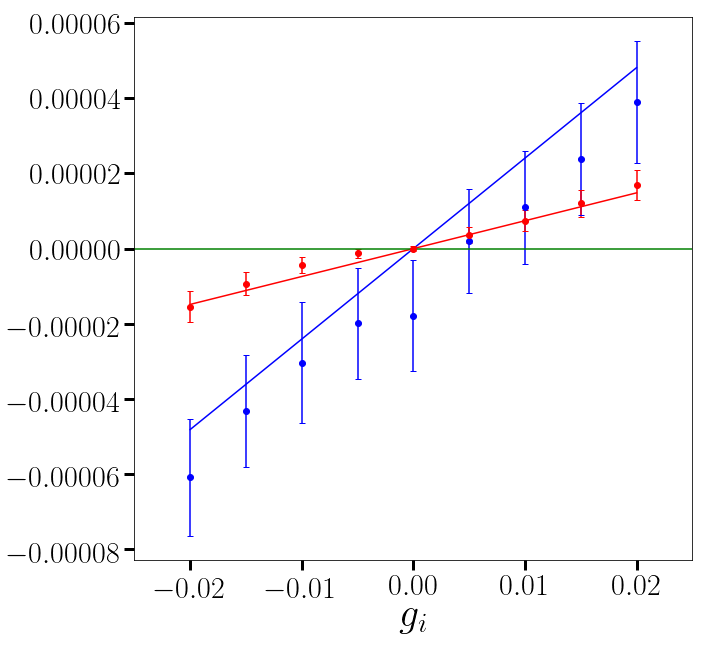

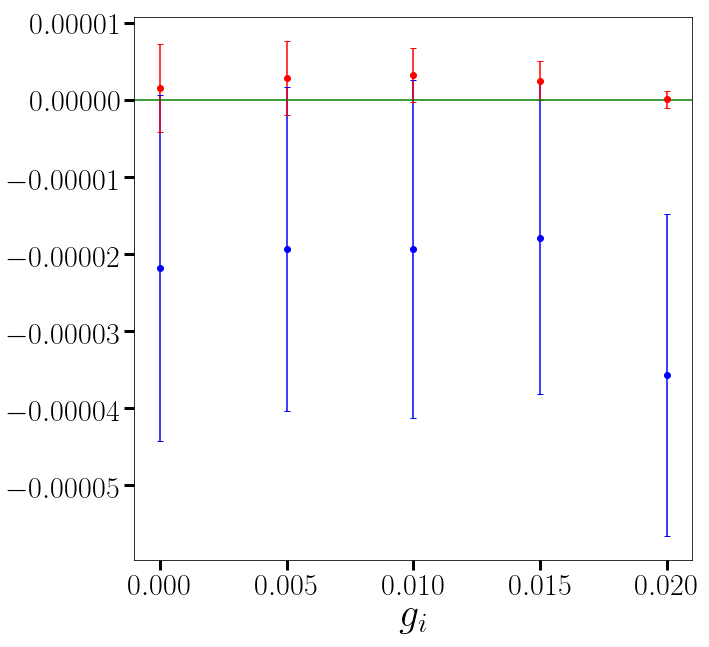

In [25]:
get_money_plot(stds_DESgold_g1grp,stds_DESgold_g1iso,filters,main_catsDES)

#### g2

In [26]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgold_g2grp = sigma_med_boot(main_catsDES,'bias_g2_grp',filters) 
stds_DESgold_g2iso = sigma_med_boot(main_catsDES,'bias_g2',filters) 

medians grp: [-4.8809266e-05, -5.3331063e-05, -3.3100583e-05, -2.3308481e-05, -8.4600324e-06, -8.5996553e-06, 7.4287959e-06, 1.9147945e-05, 3.6636287e-05]
sigmas grp: [0.005082902, 0.0050200773, 0.0050637429, 0.0051006461, 0.0050867735, 0.0050713206, 0.0050623468, 0.0051053031, 0.004978708]
errs grp: [1.711914e-05, 1.7336662e-05, 1.5518926e-05, 1.4438348e-05, 1.3799219e-05, 1.4496674e-05, 1.4229798e-05, 1.5389593e-05, 1.5893127e-05]
Beta: [ 0.00226451]
Beta Std Error: [ 0.00036924]
Beta Covariance: [[ 0.02051133]]
Residual Variance: 6.6469944466e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.5677531e-05, -1.2066728e-05, -7.5291532e-06, -4.7085073e-06, -3.6765162e-08, 1.5745287e-06, 5.387471e-06, 8.748294e-06, 1.4423226e-05]
sigmas iso: [0.0025842227, 0.002599868, 0.0026365533, 0.0026410888, 0.0025925057, 0.0025965425, 0.0026063628, 0.0026259248, 0.0026298282]
errs iso: [3.6038286e-06, 3.4319855e-06, 2.8980144e-06, 2.2094623e-06, 8.0927

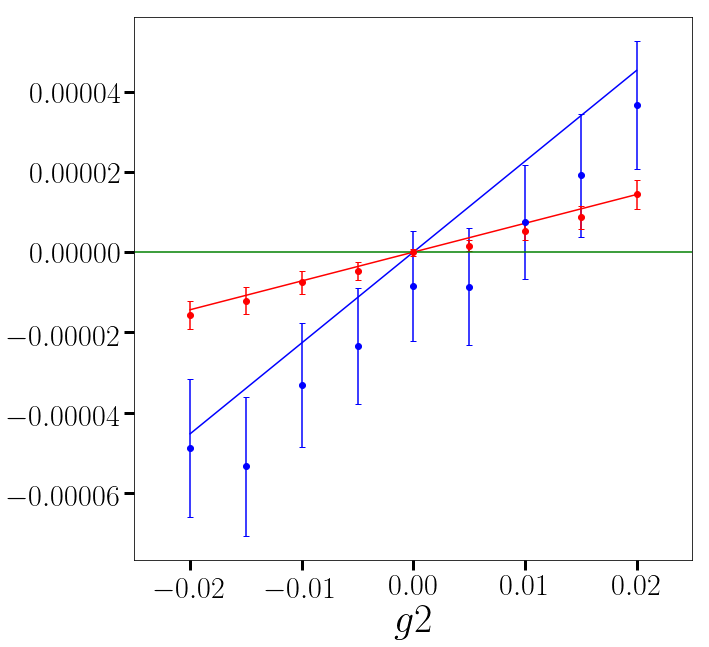

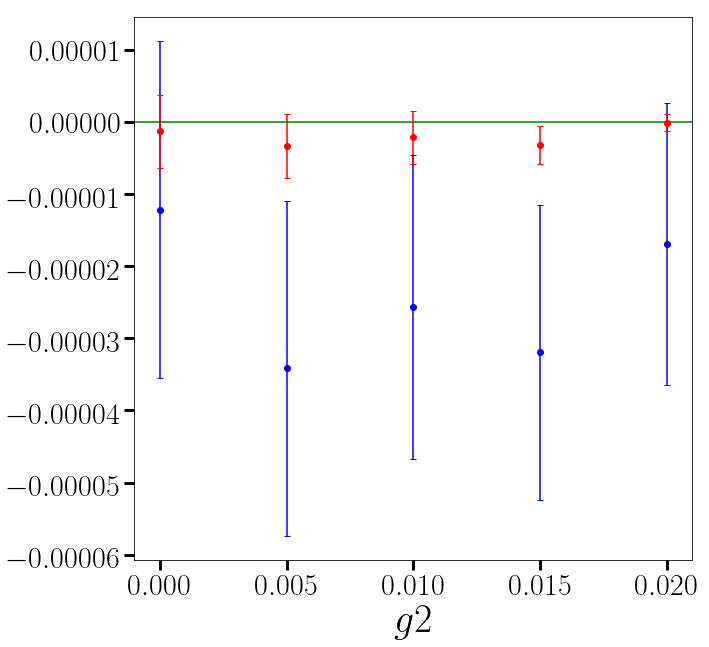

In [30]:
get_money_plot('g2',stds_DESgold_g2grp,stds_DESgold_g2iso,filters,main_catsDES)

## Good 

In [33]:
filters = [good,best]

#### g1 

In [34]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgood_g1grp = sigma_med_boot(main_catsDES,'bias_g1_grp',filters) 
stds_DESgood_g1iso = sigma_med_boot(main_catsDES,'bias_g1',filters) 

medians grp: [-5.5454911e-05, -3.9322531e-05, -2.3943405e-05, -1.7330402e-05, -1.315392e-05, 7.3715464e-06, 1.2361077e-05, 2.6055046e-05, 3.1955802e-05]
sigmas grp: [0.0039629629, 0.0039917971, 0.0040171258, 0.0039887554, 0.0039751353, 0.0039275335, 0.0039849537, 0.0039491272, 0.0039199893]
errs grp: [1.4572613e-05, 1.3676154e-05, 1.4738329e-05, 1.3939954e-05, 1.3680605e-05, 1.3804965e-05, 1.45469e-05, 1.4341525e-05, 1.5618549e-05]
Beta: [ 0.00218862]
Beta Std Error: [ 0.0002396]
Beta Covariance: [[ 0.01372234]]
Residual Variance: 4.18353671355e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.3419607e-05, -7.9706615e-06, -3.1546401e-06, -9.3657115e-07, 1.2057097e-07, 4.2439119e-06, 7.4845548e-06, 1.2561743e-05, 1.5499449e-05]
sigmas iso: [0.0019544316, 0.0019638357, 0.001995727, 0.0019646748, 0.0019408262, 0.001967703, 0.0019724355, 0.0019677882, 0.0019763138]
errs iso: [3.6167132e-06, 2.7424173e-06, 1.7890374e-06, 1.0923292e-06, 7.54720

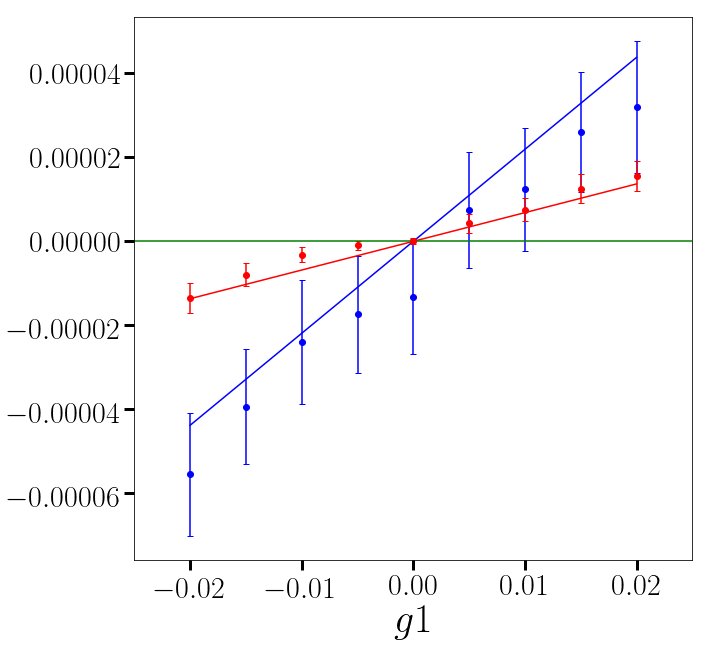

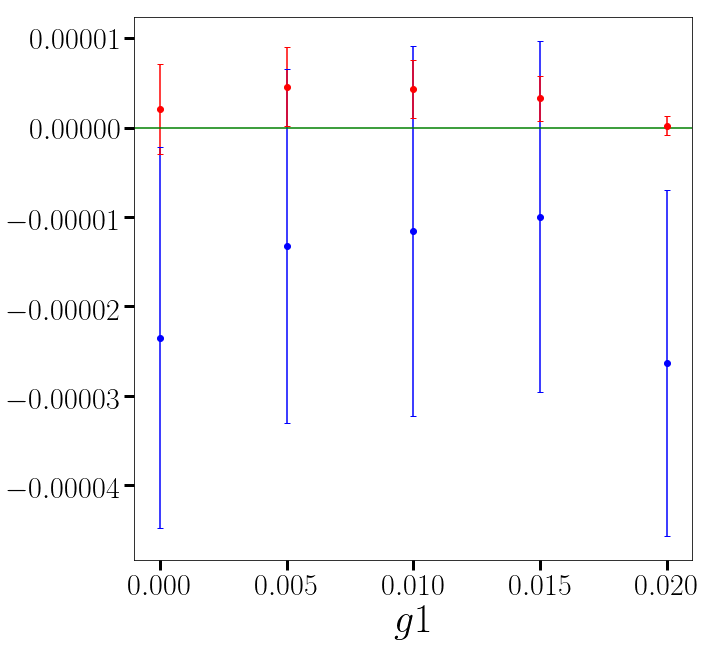

In [35]:
get_money_plot('g1', stds_DESgood_g1grp,stds_DESgood_g1iso,filters,main_catsDES)

#### g2 

In [38]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgood_g2grp = sigma_med_boot(main_catsDES,'bias_g2_grp',filters) 
stds_DESgood_g2iso = sigma_med_boot(main_catsDES,'bias_g2',filters) 

medians grp: [-4.1791842e-05, -4.3822591e-05, -3.2180295e-05, -2.1160226e-05, -6.6204402e-06, -8.3041487e-06, 1.1191978e-05, 2.5774425e-05, 3.9637904e-05]
sigmas grp: [0.003898503, 0.0038673063, 0.0038861404, 0.003903287, 0.0038105808, 0.0038384744, 0.0038999671, 0.0038913353, 0.0038131732]
errs grp: [1.6161157e-05, 1.5665251e-05, 1.4705206e-05, 1.3691537e-05, 1.3075204e-05, 1.3689654e-05, 1.3676748e-05, 1.5254018e-05, 1.5529673e-05]
Beta: [ 0.00218143]
Beta Std Error: [ 0.00027959]
Beta Covariance: [[ 0.01325054]]
Residual Variance: 5.89957398474e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.3941777e-05, -9.6360955e-06, -6.844607e-06, -3.9074425e-06, -1.1669465e-08, 1.8933351e-06, 5.4773755e-06, 9.578398e-06, 1.4279096e-05]
sigmas iso: [0.001856565, 0.001876912, 0.0019177868, 0.0019134633, 0.0018636324, 0.0018983085, 0.0019229609, 0.0018907761, 0.0019310936]
errs iso: [3.1081122e-06, 2.824004e-06, 2.5493796e-06, 1.9105948e-06, 7.0594

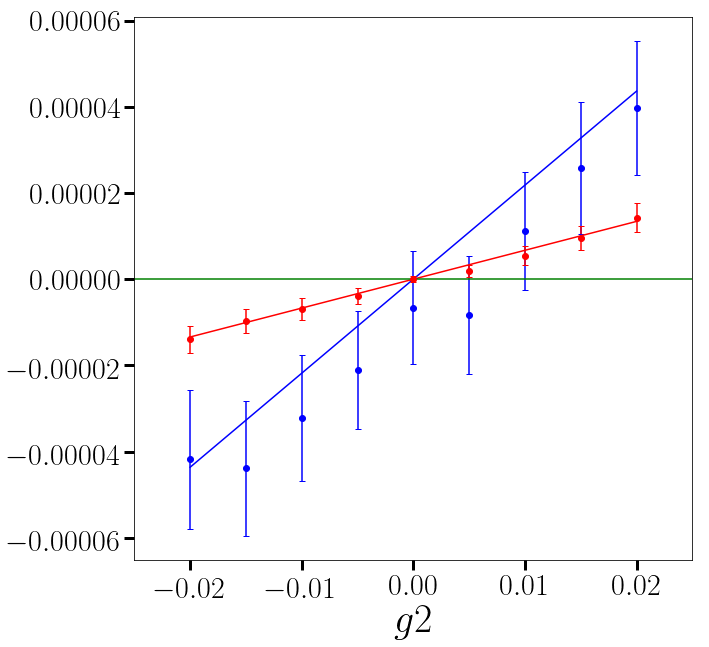

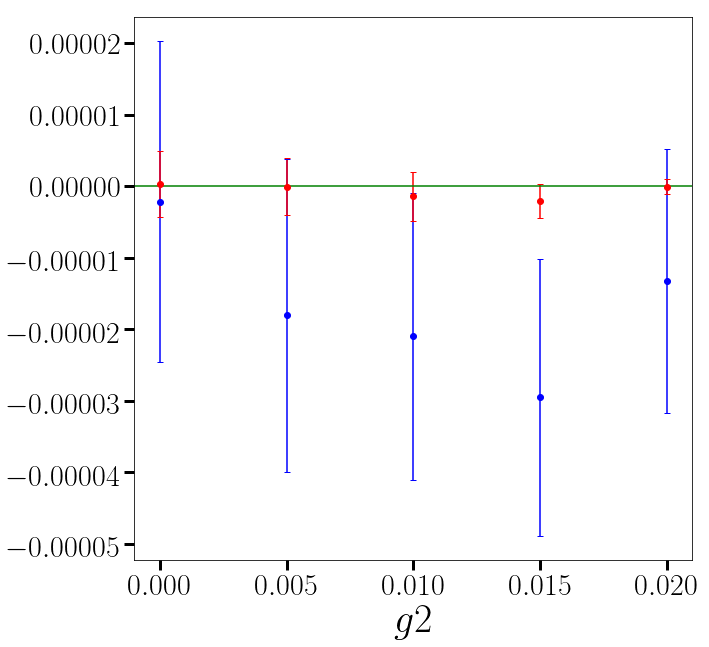

In [39]:
get_money_plot('g2', stds_DESgood_g2grp,stds_DESgood_g2iso,filters,main_catsDES)

# HSC

## Gold

In [37]:
filters = [gold,best]

#### g1 

In [38]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgold_g1grp = sigma_med_boot(main_catsHSC,'bias_g1_grp',filters) 
stds_HSCgold_g1iso = sigma_med_boot(main_catsHSC,'bias_g1',filters) 

medians grp: [-3.9297778e-05, -2.7804846e-05, -1.6934511e-05, -9.3622584e-06, -1.7282907e-06, 6.8370728e-06, 1.5727026e-05, 2.4883284e-05, 3.1090287e-05]
sigmas grp: [0.0059498413, 0.0059921006, 0.0059759575, 0.0059318412, 0.0059918473, 0.0059429104, 0.0059776627, 0.006000055, 0.0059829261]
errs grp: [5.0246849e-06, 4.2489814e-06, 3.9989459e-06, 3.2789605e-06, 2.7549145e-06, 3.0782799e-06, 3.7440486e-06, 4.2047559e-06, 4.6149698e-06]
Beta: [ 0.00173915]
Beta Std Error: [  6.35191350e-05]
Beta Covariance: [[ 0.02582223]]
Residual Variance: 1.5624832369e-07
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.7232223e-05, -1.008198e-05, -5.8150554e-06, -2.4444894e-06, 2.6429667e-11, 3.2943615e-06, 8.0385307e-06, 1.4012641e-05, 2.010246e-05]
sigmas iso: [0.0044888449, 0.0045173261, 0.0045080744, 0.0044770516, 0.0045017079, 0.0044771312, 0.0045081484, 0.0044990489, 0.0045226542]
errs iso: [2.0567863e-06, 1.5259886e-06, 1.2350799e-06, 8.85021e-07, 2.

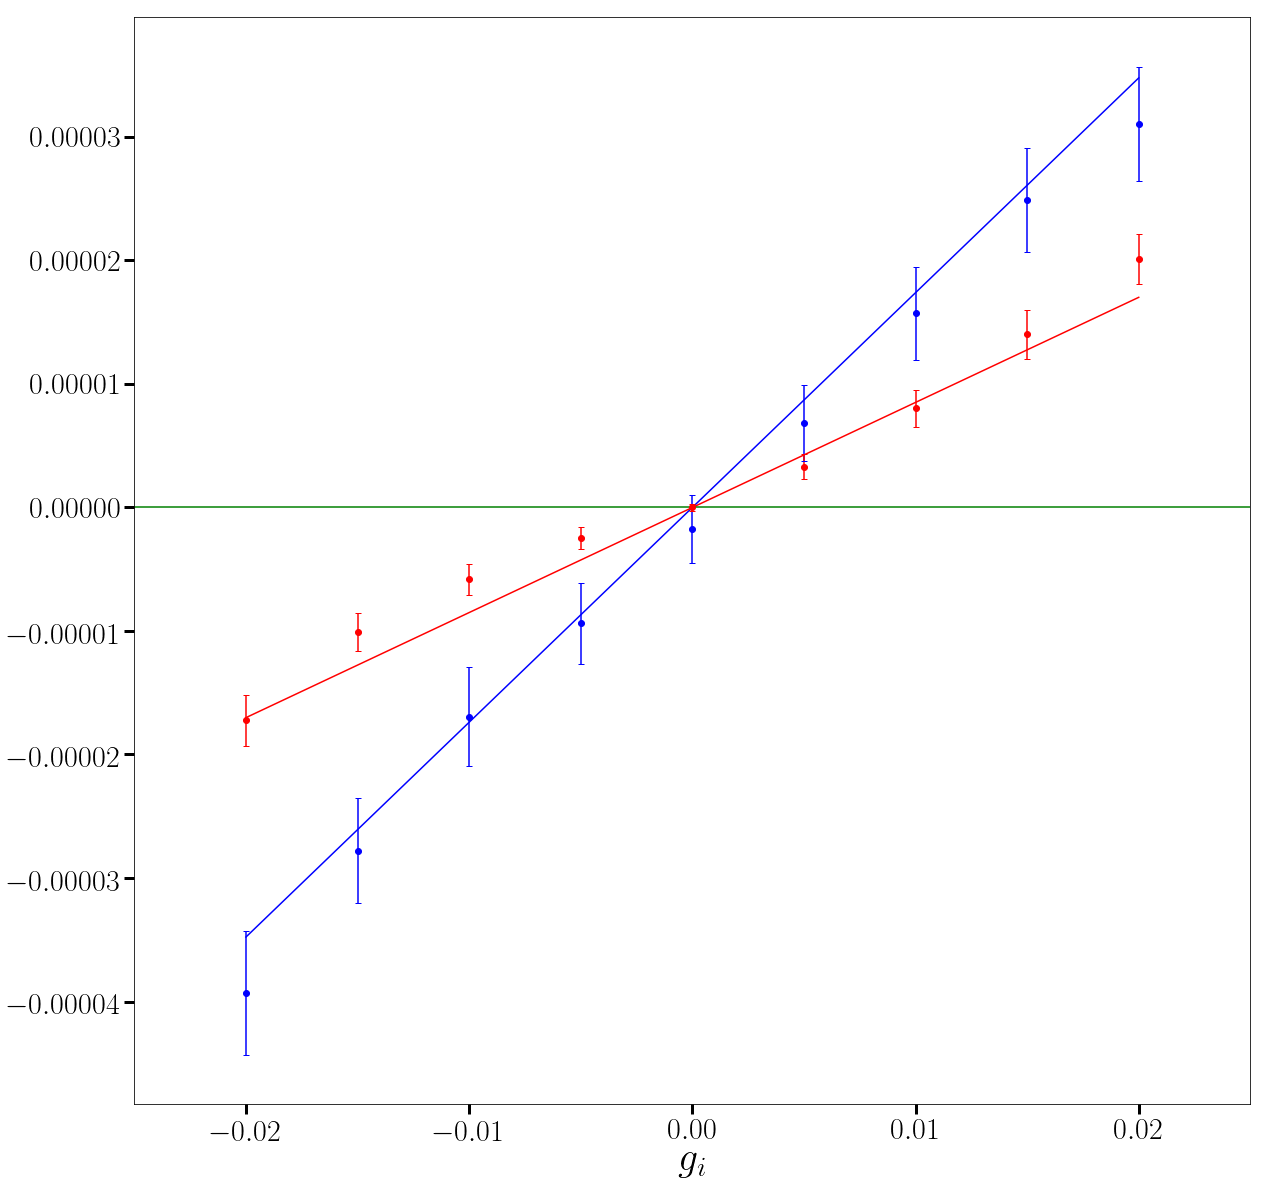

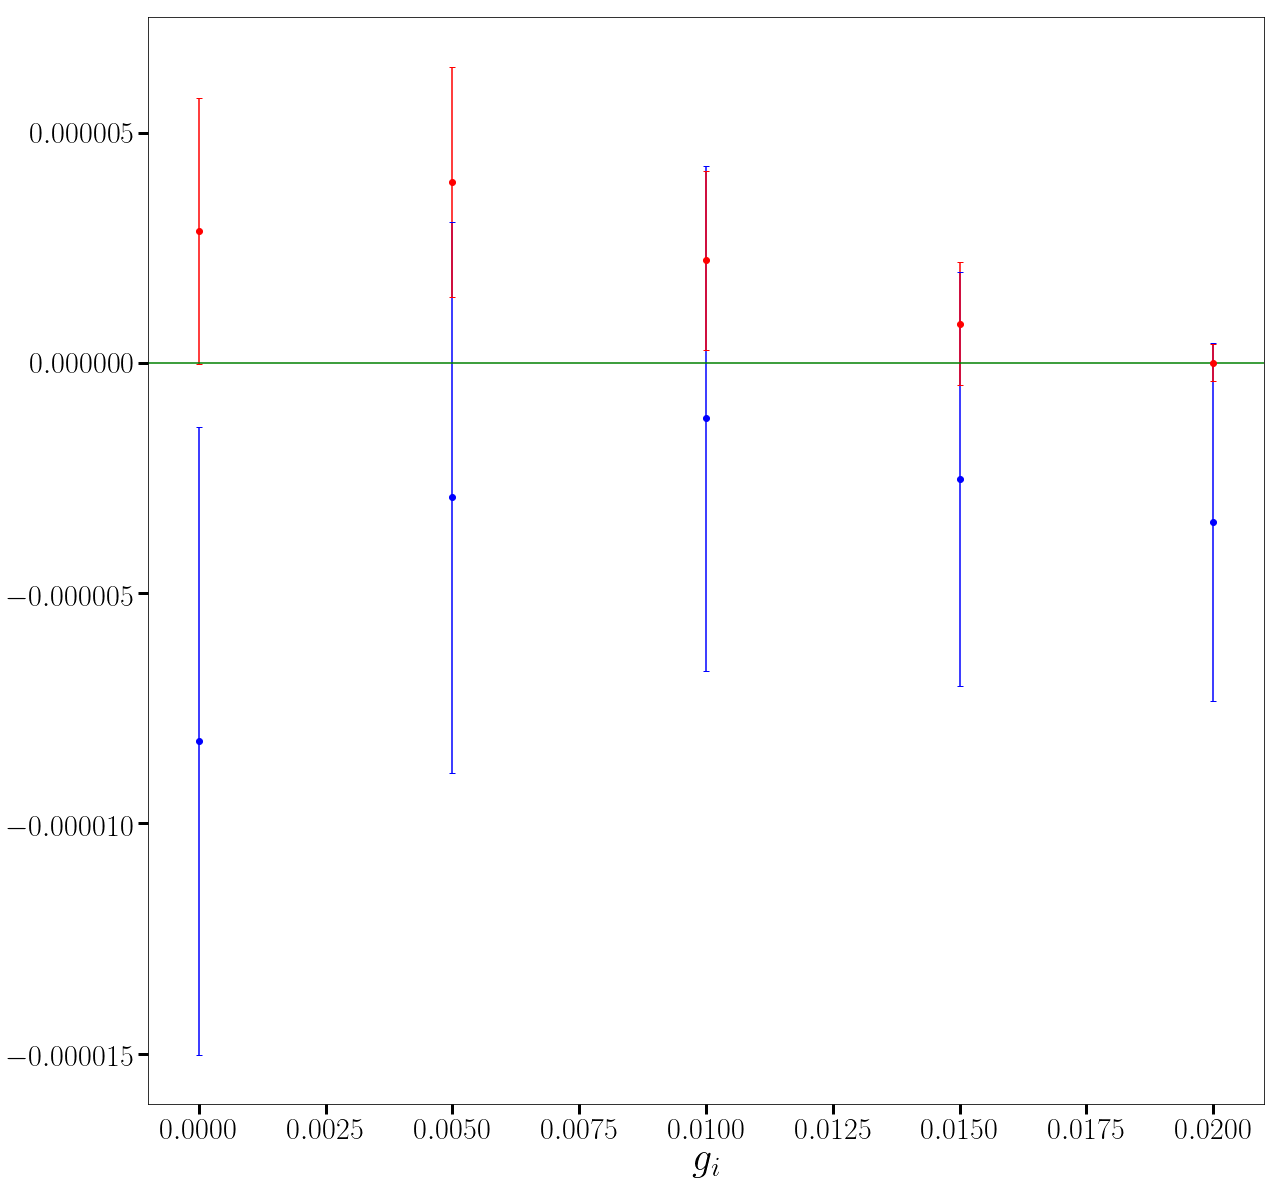

In [39]:
get_money_plot('g1', stds_HSCgold_g1grp,stds_HSCgold_g1iso,filters,main_catsHSC)

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgold_g2grp = sigma_med_boot(main_catsHSC,'bias_g2_grp',filters) 
stds_HSCgold_g2iso = sigma_med_boot(main_catsHSC,'bias_g2',filters) 

In [ ]:
get_money_plot('g2',stds_HSCgold_g2grp,stds_HSCgold_g2iso,filters,main_catsHSC)

## Good 

In [40]:
filters = [good,best]

#### g1 

In [41]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgood_g1grp = sigma_med_boot(main_catsHSC,'bias_g1_grp',filters) 
stds_HSCgood_g1iso = sigma_med_boot(main_catsHSC,'bias_g1',filters) 

medians grp: [-2.6274025e-05, -1.6921598e-05, -1.0513997e-05, -6.1388409e-06, -3.5439562e-08, 5.9420036e-06, 1.1555741e-05, 1.7475477e-05, 2.3183493e-05]
sigmas grp: [0.0027864773, 0.0028028633, 0.0027924096, 0.0027972078, 0.0028140338, 0.0027995664, 0.0028023976, 0.0028189735, 0.002808433]
errs grp: [3.5425237e-06, 3.4722195e-06, 2.9307757e-06, 2.6737887e-06, 2.4208018e-06, 2.6353002e-06, 3.1154882e-06, 3.379849e-06, 3.472288e-06]
Beta: [ 0.00119197]
Beta Std Error: [  2.83452517e-05]
Beta Covariance: [[ 0.00617946]]
Residual Variance: 1.30020024637e-07
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.0503341e-05, -5.943999e-06, -3.2926325e-06, -1.3680257e-06, 6.8840507e-08, 2.4525409e-06, 5.6402473e-06, 9.2367254e-06, 1.3948767e-05]
sigmas iso: [0.0019432416, 0.001943793, 0.0019469515, 0.0019405945, 0.0019430686, 0.0019349564, 0.0019406102, 0.0019458215, 0.0019538151]
errs iso: [1.4197554e-06, 1.09825e-06, 8.6974666e-07, 5.9315721e-07, 2.7

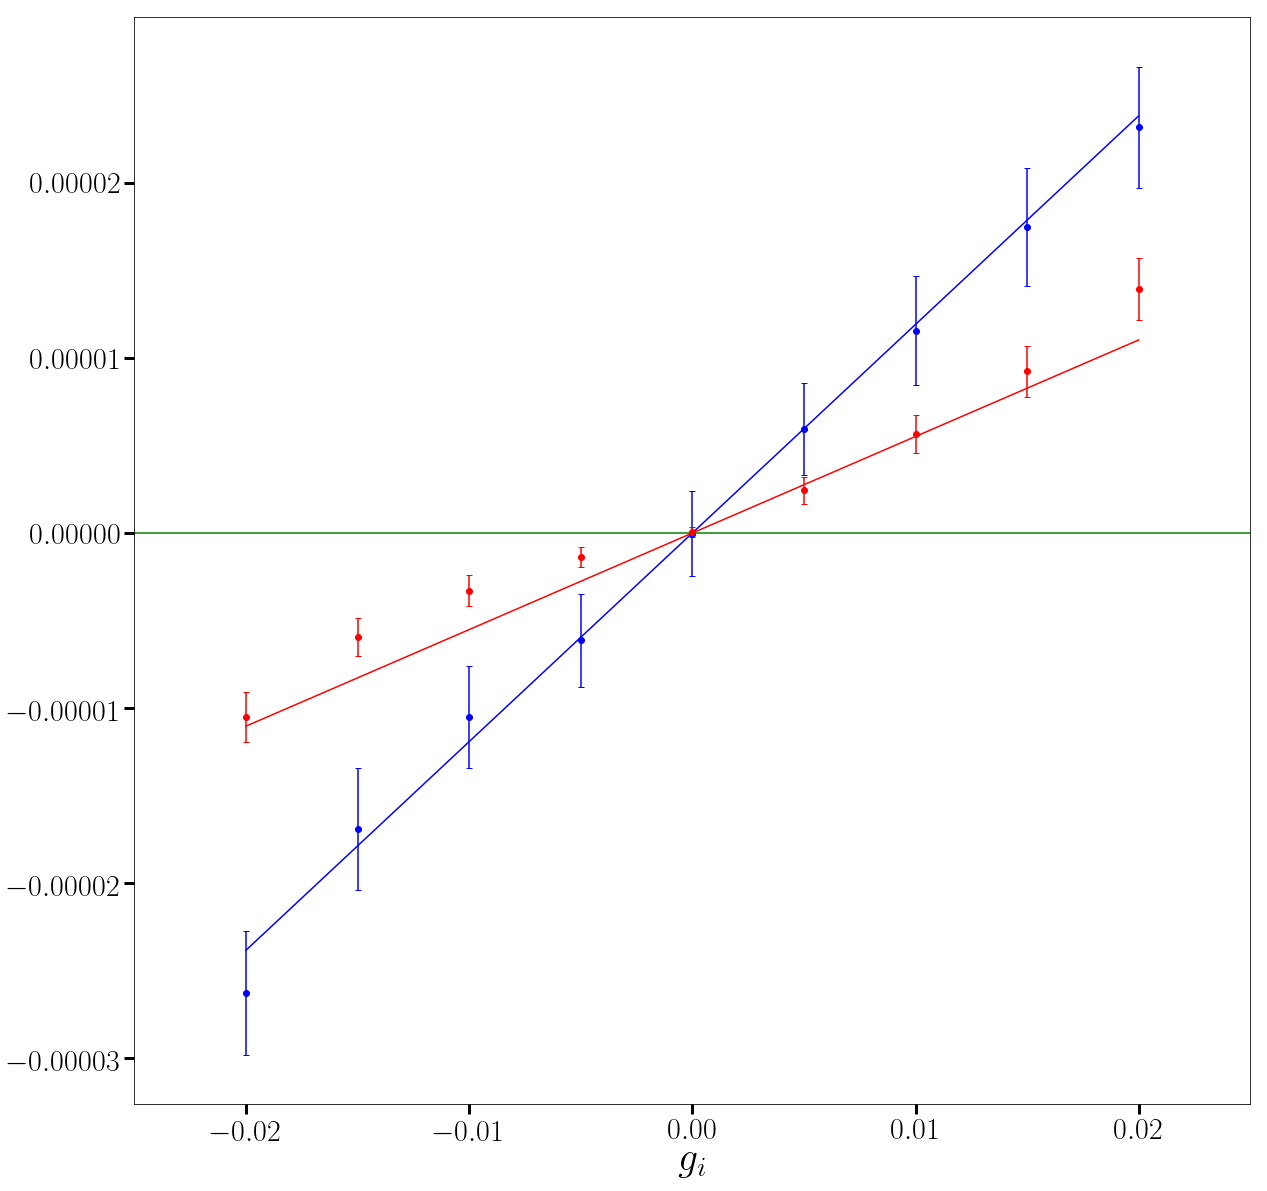

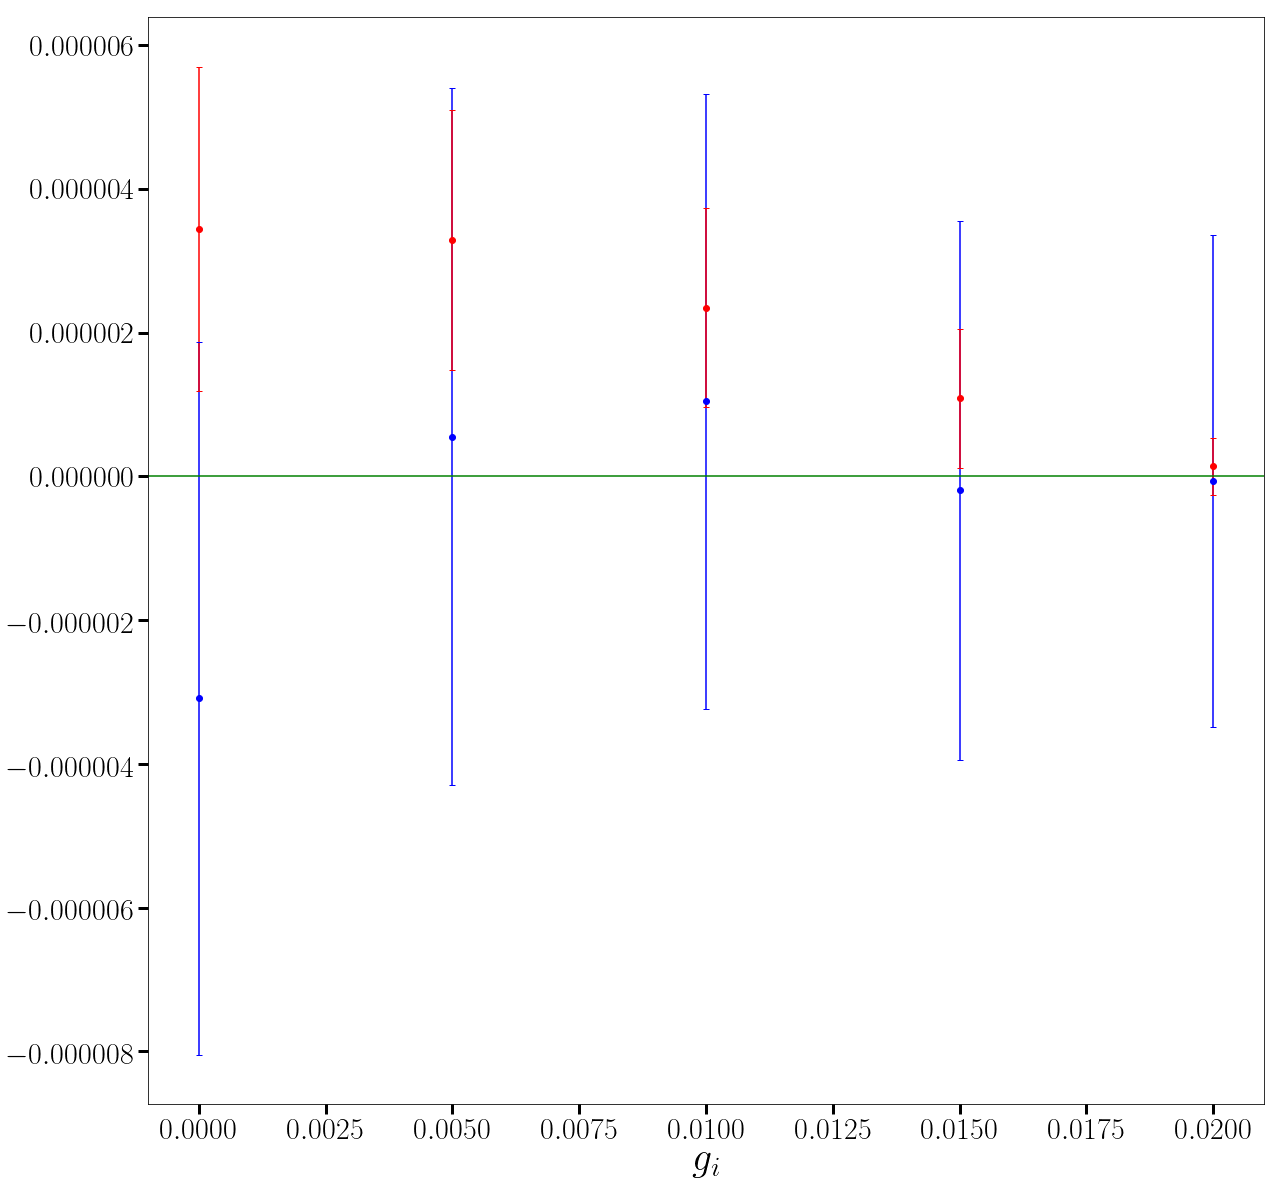

In [42]:
get_money_plot('g1', stds_HSCgood_g1grp,stds_HSCgood_g1iso,filters,main_catsHSC)

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgood_g2grp = sigma_med_boot(main_catsHSC,'bias_g2_grp',filters) 
stds_HSCgood_g2iso = sigma_med_boot(main_catsHSC,'bias_g2',filters) 

In [ ]:
get_money_plot('g2', stds_HSCgood_g2grp,stds_HSCgood_g2iso,filters,main_catsHSC)

# Selection Bias: Median noise bias for events selected at shear = 0 

## Histogram of Bias 

In [246]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_plots2(cat,good,gold,save=None):

    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 1,1
    #
    plt.subplot(nrow, ncol, 1) 
    plt.xlabel('$b[g_{1}]$',fontsize=25)




    plt.ylabel('Fraction of galaxies',fontsize=25)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlim(g_min,g_max)





#     plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_all',color='red',weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g1_grp_all',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(good['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_good',color='blue',weights=np.ones_like(good['bias_g1'])/len(good['bias_g1']))
    plt.hist(good['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='blue',histtype='step',label='bias_g1_grp_good',weights=np.ones_like(good['bias_g1_grp'])/len(good['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(gold['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g1_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g1']))
    plt.hist(gold['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='gold',histtype='step',label='bias_g1_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g1_grp']))
    plt.legend(prop={'size':15})
    plt.yscale('log')
    #
#     #
#     plt.subplot(nrow, ncol, 2) 
#     plt.tick_params(axis='both', which='minor',size=5)
#     plt.title('biases on g2',fontsize=14)
#     plt.xlabel('bias on g2',fontsize=14)
#     plt.ylabel('Fraction of galaxies',fontsize=14)
#     plt.xlim(g_min,g_max)
#     #
#     plt.hist(cat['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_all',color='red',weights=np.ones_like(cat['bias_g2'])/len(cat['bias_g2']))
#     plt.hist(cat['bias_g2_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g2_grp_all',weights=np.ones_like(cat['bias_g2_grp'])/len(cat['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')
#     #
#     plt.hist(good['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_good',color='blue',weights=np.ones_like(good['bias_g2'])/len(good['bias_g2']))
#     plt.hist(good['bias_g2_grp'],range=[g_min,g_max],bins=100,color='blue',ls='dashed',histtype='step',label='bias_g2_grp_good',weights=np.ones_like(good['bias_g2_grp'])/len(good['bias_g2_grp']))
#     plt.legend()
#     #
#     plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g2_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g2']))
#     plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='gold',ls='dashed',histtype='step',label='bias_g2_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')

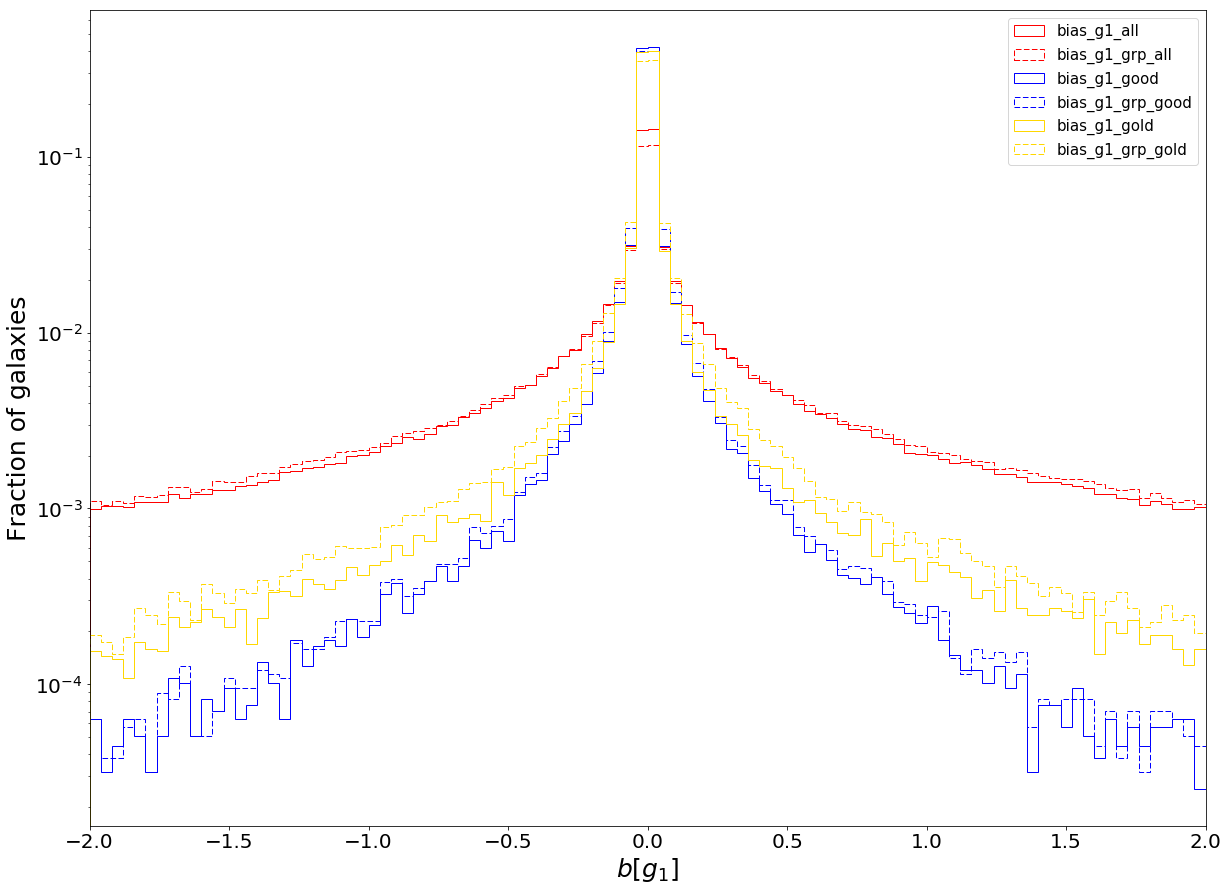

In [247]:
cat_plot = main_cats[0]
shear_biases_plots2(cat_plot,good(cat_plot),gold(cat_plot))

## Histograms of ab_mag 

In [24]:
def histograms_abmag(cat,good):
    plt.rc('text', usetex=True)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    
#     norm= 1./len(cat['ab_mag'])
#     weights = [norm] * len(good['ab_mag'])
    plt.hist(cat['ab_mag'], histtype='step', bins=50,color='blue',label='all galaxies',range=(14,30))
    plt.hist(good['ab_mag'], histtype='step',bins=50,color='red',label='lensing sample galaxies',range=(14,30))

    
    
    plt.ylabel(r'\rm Number of galaxies $[10^5]$', fontsize=25)
    plt.xlabel(r'\rm mag$_{AB}$',fontsize=25)
#     plt.title('Histogram of ab_mag for good galaxies')
    plt.legend(loc=2,prop={'size':18})
    plt.axvline(25.3,color='green',label='cut for golden sample') #this represents the gold sample cut. 
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.get_yaxis().get_offset_text().set_size(1)
    plt.savefig('/Users/Ismael/Desktop/hist_new1.pdf')



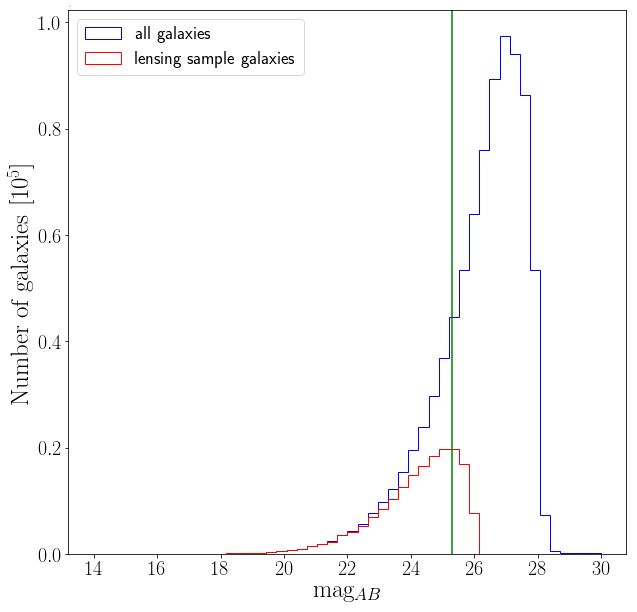

In [25]:
histograms_abmag(main_catsLSST[4],good(main_catsLSST[4]))

## Histogram for non-ambiguous blended and such, 

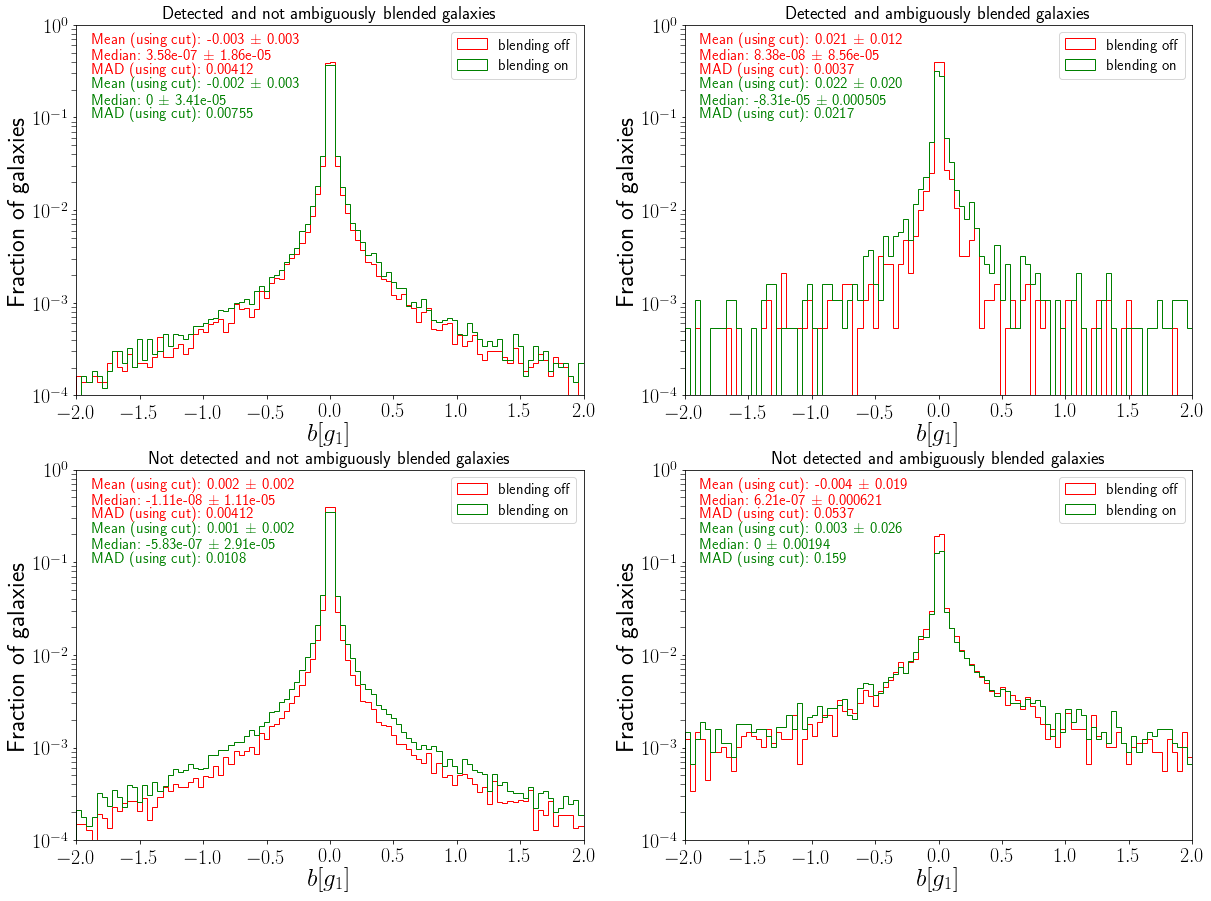

In [249]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2
g_min = -2. 
g_max = 2.
names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']

cats =[detc_and_notambig(gold(main_cats[0])),
detc_and_ambig(gold(main_cats[0])),
notdetc_and_notambig(gold(main_cats[0])),
notdetc_and_ambig(main_cats[0])]

colors = ('red','green')
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15})



## Investigate what is happening with DES g1,g2=0 

In [18]:
#median is systematically low
np.median(gold(best(main_catsDES[4]))['bias_g1_grp'])

-1.7860621e-05

In [19]:
np.median(gold(best(main_catsDES[4]))['bias_g2_grp'])

-8.4600324e-06

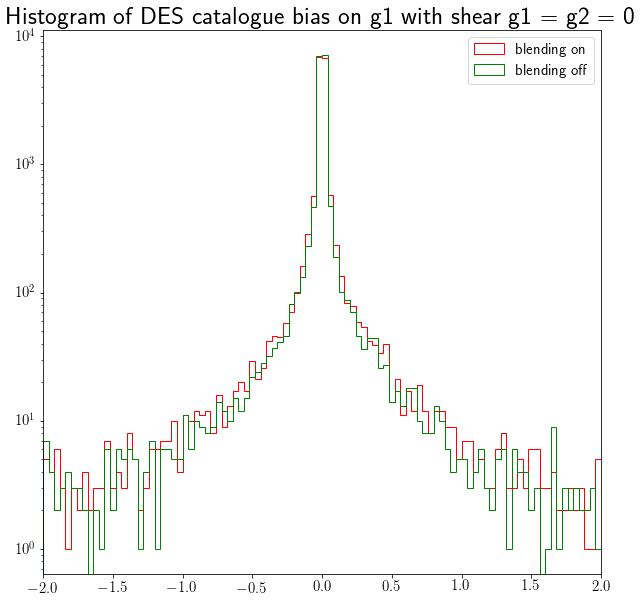

In [57]:
fig = plt.figure(figsize=(10,10))
g_min,g_max = -2,2
plt.hist(gold(best(main_catsDES[4]))['bias_g1_grp'],histtype='step',bins=100,range=[g_min,g_max],color='red',label='blending on')
plt.hist(gold(best(main_catsDES[4]))['bias_g1'],histtype='step',bins=100,range=[g_min,g_max],color='green',label='blending off')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(g_min,g_max)
plt.yscale('log')
plt.legend(prop={'size':15})
plt.title('Histogram of DES catalogue bias on g1 with shear g1 = g2 = 0',size=25)

## Shear bias histograms 

In [30]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)


def shear_biases_hists(cat,colors,g_min,g_max,err_mean_iso=None,err_median_iso=None,err_mean_grp=None,err_median_grp=None,save=None):
    
    #plt.title(name,fontsize=18)

    plt.xlabel(r'$b[g_{1}]$',fontsize=25)


    plt.ylabel(r'\rm Fraction of galaxies',fontsize=25)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.xticks(size=20)
    plt.yticks(size=20)
    
    
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.yscale('log')
    plt.ylim(10e-5,10e-1)
    plt.xlim(-1.5,1.5)
    
    if err_mean_iso != None and err_median_iso != None and err_mean_grp != None and err_median_grp != None: 
    
    
        #print mean and stuff 
        cut_cat = abs_cut(cat, 'bias_g1_grp', 1.5)
        print 'Mean bias_iso for cat: {}'.format(np.mean(cut_cat['bias_g1'])) 
        print 'Error on mean bias_iso for all cat: {}'.format(err_mean_iso) 
        print 'median bias_iso for cat: {}'.format(np.median(cat['bias_g1'])) 
        print 'error on median bias_iso for cat: {}'.format(err_median_iso) 

        print 'Mean bias_grp for cat: {}'.format(np.mean(cut_cat['bias_g1_grp'])) 
        print 'Error on mean bias_grp for all cat: {}'.format(err_mean_grp) 
        print 'median bias_grp for cat: {}'.format(np.median(cat['bias_g1_grp'])) 
        print 'error on median bias_grp for cat: {}'.format(err_median_grp) 


#     print 'Error on mean bias_iso for all cat: {}'.format(err_mean_iso) 

#     mean_cut_iso = np.mean(cut_biasiso(cat,10.)['bias_g1'])
#     std_cut_iso = np.std(cut_biasiso(cat,10.)['bias_g1'])
#     median_iso = np.median(cat['bias_g1'])
#     mad_iso = mad(cut_biasiso(cat,10.)['bias_g1'])
#     error_std_iso = std_cut_iso/np.sqrt(len(cut_biasiso(cat,10)))
#     error_mad_iso = mad_iso/np.sqrt(len(cut_biasiso(cat,10.)['bias_g1']))
    
#     mean_cut_grp = np.mean(cut_biasgrp(cat,10)['bias_g1_grp'])
#     std_cut_grp = np.std(cut_biasgrp(cat,10)['bias_g1_grp'])
#     median_grp = np.median(cat['bias_g1_grp'])
#     mad_grp = mad(cut_biasgrp(cat,10)['bias_g1_grp'])
#     error_std_grp = std_cut_grp/np.sqrt(len(cut_biasgrp(cat,10)))
#     error_mad_grp = mad_grp/np.sqrt(len(cut_biasgrp(cat,10)['bias_g1_grp']))
    
    #plt.annotate(r'Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_iso,error_std_iso), xy=(0.03, 0.95), xycoords='axes fraction',color=colors[0],fontsize=15)
    #plt.annotate(r'Median: {0:.3g} $\pm$ {1:.3g}'.format(median_iso, error_mad_iso), xy=(0.03, 0.91), xycoords='axes fraction',color=colors[0],fontsize=15)
    #plt.annotate(r'MAD (using cut): {0:.3g}'.format(mad_iso), xy=(0.03, 0.87), xycoords='axes fraction',color=colors[0],fontsize=15)
    #plt.annotate(r'Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_grp,error_std_grp), xy=(0.03, 0.83), xycoords='axes fraction',color=colors[1],fontsize=15)
    #plt.annotate(r'Median: {0:.3g} $\pm$ {1:.3g}'.format(median_grp, error_mad_grp), xy=(0.03, 0.79), xycoords='axes fraction',color=colors[1],fontsize=15)
    #plt.annotate(r'MAD (using cut): {0:.3g}'.format(mad_grp), xy=(0.03, 0.75), xycoords='axes fraction',color=colors[1],fontsize=15)

In [40]:
cat = main_catsLSST[4]
cut_cat = abs_cut(cat, 'bias_g1_grp', 1.5)



err_mean_iso = errs_mean_boot([good(best(cut_cat))],'bias_g1')[0]
err_median_iso = errs_med_boot([best(good(cat))],'bias_g1')[0]
err_mean_grp = errs_mean_boot([best(good(cut_cat))],'bias_g1_grp')[0]
err_median_grp = errs_med_boot([best(good(cat))],'bias_g1_grp')[0]




just to check that symmetry is respected print both percentiles: [ 0.00031133  0.00031369]
just to check that symmetry is respected print both percentiles: [  7.81939988e-08   2.34330198e-07]
just to check that symmetry is respected print both percentiles: [ 0.00035955  0.00034865]
just to check that symmetry is respected print both percentiles: [  3.05410742e-06   2.66964287e-06]


Mean bias_iso for cat: -0.000166170793818
Error on mean bias_iso for all cat: 0.000313685987494
median bias_iso for cat: 2.03614014538e-08
error on median bias_iso for cat: 2.34330197912e-07
Mean bias_grp for cat: -0.000171507839696
Error on mean bias_grp for all cat: 0.000348647155915
median bias_grp for cat: -1.19844196433e-06
error on median bias_grp for cat: 2.66964286766e-06


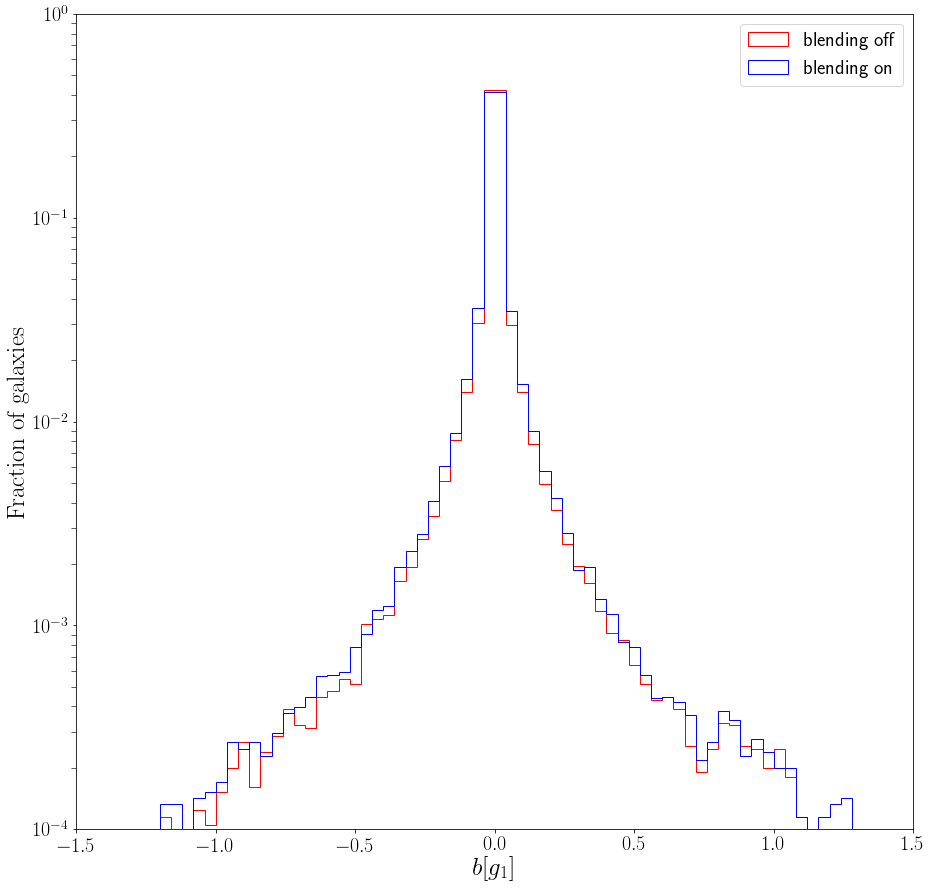

In [41]:
fig = plt.figure(figsize=(15,15))
nrow,ncol = 1,1
g_min = -2
g_max = 2


colors = ('red','blue')
plt.subplot(111)
shear_biases_hists(good(best(main_catsLSST[4])),colors,g_min,g_max,err_mean_iso,err_median_iso,err_mean_grp,err_median_grp)
plt.legend(prop={'size':20})

plt.savefig("/Users/Ismael/Desktop/hist-medians-no-shear.pdf")




# Misc. 

(array([   9990.,   13228.,   19319.,   32734.,  191091.,  191815.,
          32620.,   19113.,   13331.,   10268.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

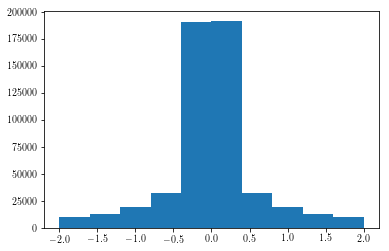

In [30]:
plt.hist(main_catsLSST[4]['bias_g1_grp'],range=(-2,2))

In [34]:
cat = good(best(main_catsLSST[4]))
len(cat[cat['bias_g1_grp'] > 2])

56

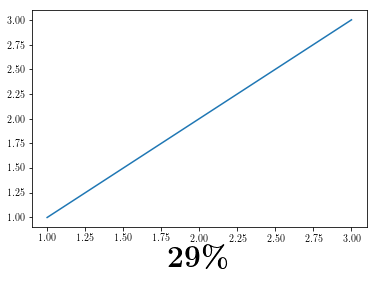

In [70]:
fig = plt.figure() 
plt.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


plt.xlabel(r'$\boldsymbol{29\%}$',size=30,)
# plt.ylabel(r'$x$',size=30)


plt.plot([1,2,3],[1,2,3])

In [44]:
main_catsLSST['bias_g1_grp']

TypeError: list indices must be integers, not str

In [27]:
np.max(abs_cut(best(good(main_catsLSST[4])),'bias_g1_grp',1.5)['bias_g1'])

1.4622716

In [34]:
x = np.array([1,2,3,4,5,6])
y = np.array([2,4,6,8,10,12])
errs = np.array([0.001,0.001,0.001,0.001,0.001,0.001]) 

## Sample optimization routine using chi-sq with arguments. 

In [35]:
def chisqfunc((a, b),data_x,data_y,data_err):
    model = a + b*data_x
    chisq = numpy.sum(((data_y - model)/data_err)**2)
    return chisq


In [36]:
x0 = np.array([0,0])
results = opt.minimize(chisqfunc, x0,args=(x,y,errs))
print results
assert results.success==True
a,b=results.x
print a,b

      fun: 1.5876204200953132e-08
 hess_inv: array([[  4.33333001e-07,  -9.99999224e-08],
       [ -9.99999224e-08,   2.85714105e-08]])
      jac: array([  1.66089365e-07,   3.81916723e-08])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([  9.68576164e-08,   1.99999997e+00])
9.68576163793e-08 1.9999999702


## By how much fraction of galaxies passing criteria for lensing sample change 

In [43]:
print len(main_catsLSST)

9


In [47]:
print len(best(good(main_catsLSST[4])))
print len(best(good(main_catsLSST[8])))

print 1 - float(len(best(good(main_catsLSST[8]))))/len(best(good(main_catsLSST[4])))

105015
104948
0.000638004094653


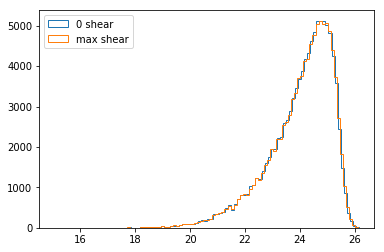

In [22]:
## also compare distribtuions of mag_AB, first just plot it

plt.hist(best(good(main_catsLSST[4]))['ab_mag'], bins=100,histtype='step',label='0 shear')
plt.hist(best(good(main_catsLSST[8]))['ab_mag'], bins=100,histtype='step',label='max shear')

plt.legend(loc=2) 



## SNR binning of isolated galaxies to potentially compare to other papers 

In [38]:
cat = main_catsLSST[4]
isolated_cat = iso_gal(cat)

(array([ 106863.,   81498.,   38954.,   23225.,   16105.,   11873.,
           9132.,    7062.,    5835.,    4886.,    4204.,    3666.,
           3059.,    2727.,    2487.,    2214.,    1907.,    1808.,
           1646.,    1416.,    1326.,    1271.,    1121.,    1032.,
           1037.,     952.,     842.,     800.,     791.,     708.,
            703.,     607.,     601.,     537.,     533.,     521.,
            504.,     433.,     439.,     422.,     429.,     410.,
            397.,     332.,     334.,     311.,     319.,     306.,
            280.,     272.]),
 array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
          18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
          36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
          54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
          72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
          90.,   92.,   94.,   96.,   98.,  100.]),
 <a list of 50 Patc

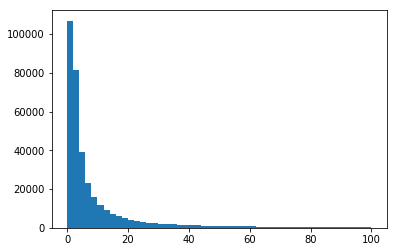

In [40]:
#histogram of snr_grpf 
plt.hist(isolated_cat['snr_grpf'],bins=50,range=(0,100))

3.55261e-06 23287.2
[0.00013962723, -6.4400429e-06, 5.0299896e-05, 1.0795158e-05, -9.9367382e-05, 1.3827674e-05, 9.7584678e-05, -9.6106625e-05, -3.0514537e-05, 2.3456278e-05, 8.2546221e-06, -2.1014494e-06, -1.8853796e-05, -4.0748528e-05, 0.00010224035, 0.00011461518, -1.5588233e-06, -2.1693584e-05, 2.2868169e-06, 3.0663605e-06, -1.9472609e-05, -1.0151981e-05, -2.2684459e-05, -1.5993346e-05, -8.2685059e-05, 2.4395871e-05, -8.3213981e-06, 2.1598542e-05, -4.532536e-06, -5.3185472e-06, -7.6712386e-06, 3.3599685e-05, -6.8374884e-06, -4.0614203e-05, 5.119948e-05, -8.1481894e-06, 1.9468134e-05, -5.0995982e-06, 1.0476881e-05, 6.397564e-06, 2.2423754e-05, 3.9981067e-09, 2.4879593e-05, -1.2687875e-06, -1.9632642e-05, -1.2121865e-05, -1.0810177e-06, 5.8785636e-06, -6.7852097e-06, -2.4929031e-06, 3.0452316e-07, 1.3435718e-05, -2.4670062e-06, 3.1864194e-05, 4.4407057e-06, -5.2069731e-06, -1.9729183e-05, 1.6567257e-05, 2.0631394e-06, -7.2401472e-06, 1.0959354e-05, -5.0129902e-06, 6.2125855e-06, -1.1

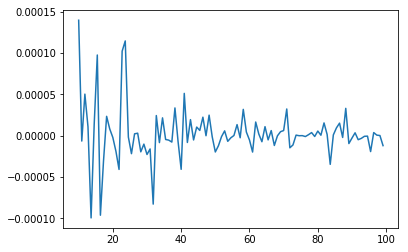

In [44]:
cat = main_catsLSST[4]
isolated_cat = iso_gal(cat)
snr_min,snr_max = np.min(cat['snr_grpf']), np.max(cat['snr_grpf'])
print snr_min, snr_max
snrs = np.linspace(10,100, 100)
y = []
for i in range(len(snrs)-1):
    small_cat = down_cut(up_cut(isolated_cat,'snr_grpf',snrs[i]),'snr_grpf',snrs[i+1])
    small_g1 = np.median(small_cat['bias_g1'])
    y.append(small_g1)
print y   
plt.plot(snrs[0:99],y)